# Note Detection using Binary Classificaiton and Logistic Regression
 by Gregory Aschenbrenner and Noah Ligouri-Bills 

## Basic Libraries and Sound Creation
We first import the fundamental libaries. These include Librosa, an audio processing library, Pandas to do calculations with time-series data, numpy for calculations, matplotlib for plots, pickle to save our models, wave for creation of our own sound waves and struct to emulate C structures (bytes as binary packed data) for sine wave creation. 

In [ ]:
import os 
import numpy as np
import wave
import struct
import matplotlib.pyplot as plt
import math 
import pandas
import pickle
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import IPython.display
import librosa
import librosa.display
from sklearn import datasets, svm, metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Creating a sound wave
We create a function to sine wave, which has a second of silence and then a second of sound at a given frequency, if unspecified the frequency is 1000Hz (1000 Cycles/Second), which will be used for example calculations. 

In [ ]:
num_samples = 41100
sampling_rate = 41100.0
amplitude = 16000
def make_sine(freq=1000):
    frequency = freq
    sine_wave_part = [np.sin(2 * np.pi * frequency * x/sampling_rate) for x in range(num_samples)] + [0] * num_samples
    return sine_wave_part

We now define a function to save to a .wav file as this is used heavily later in the program.

In [ ]:
nframes=num_samples
comptype="NONE"
compname="not compressed"
nchannels=1
sampwidth=2
def save_wav(sine_wave, file = "test.wav"):
    wav_file=wave.open(file, 'w')
    wav_file.setparams((nchannels, sampwidth, int(sampling_rate), nframes, comptype, compname))
    for s in sine_wave:
       wav_file.writeframes(struct.pack('h', int(s*amplitude)))

Now we generate a sine wave with a frequency of 1000Hz.

In [ ]:
little_sine_wave = make_sine(1000)

print(little_sine_wave[:10])
print(len(little_sine_wave))

save_wav(little_sine_wave, "shortt.wav")

[0.0, 0.15228077625453543, 0.30100953426472493, 0.44271710822445204, 0.574098104633321, 0.6920880021007617, 0.7939346326988125, 0.8772623775285731, 0.940127579109596, 0.9810638780730726]
82200


# Preprocessing
We split the created .wav file into sampling rate and amplitude. We can plot this function over short frequencies and see a sine wave of 1000Hz, but since we have silence after 44100Hz the plot stops afterwards.

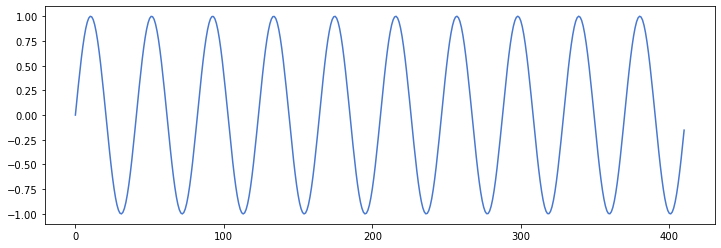

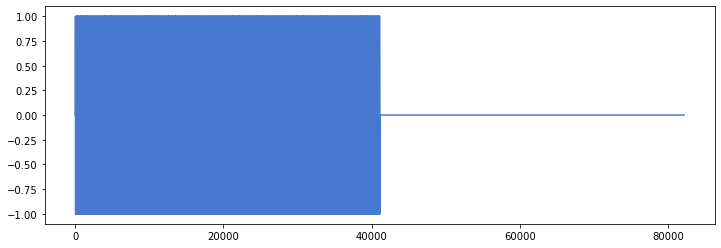

In [ ]:
y, sr = librosa.load("shortt.wav")
plt.figure(figsize=(12,4))
plt.plot(range(len(little_sine_wave[:411])),little_sine_wave[:411])
IPython.display.Audio(data=y, rate=sr)
plt.figure(figsize=(12,4))
plt.plot(range(len(little_sine_wave)),little_sine_wave)

# Mel-Spectrum Cepestrum Coordinates (MFCC)
We will be using Mel-Spectrum Cepestrum Coordinates as our primary feature. This metric gives an idea of the short term power spectrum of a sound signal. Between notes such power spectra change drastically, this allows us to use MFCC to classify a span of time as having a sound or not. 
Below we create a sine wave of frequency multiples of 500Hz. This may seem an odd thing to do, but the below plots of MFCC should clarify any confusion.

In [ ]:
sine_wave=[]
for i in range(1,11):
    sine_wave += make_sine(500*i)
print(sine_wave[:10])
print(len(sine_wave))
save_wav(sine_wave, "longt.wav")

[0.0, 0.07636336493694144, 0.15228077625453543, 0.22730888465333024, 0.30100953426472493, 0.3729523214328617, 0.44271710822445204, 0.5098964759879159, 0.574098104633321, 0.6349470637383889]
822000


In [ ]:
y, sr = librosa.load("longt.wav")
IPython.display.Audio(data=y, rate=sr)

Below is the MFCC plot of the previously described sine wave. 

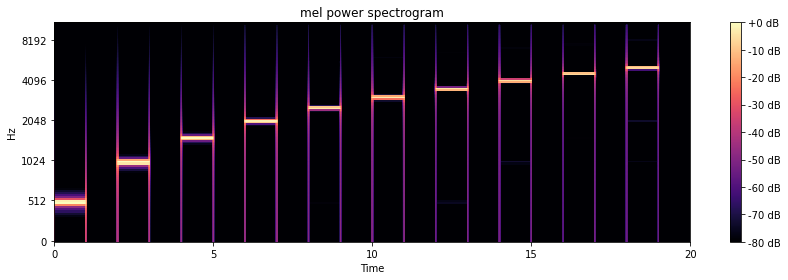

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.savefig("testSpectrogram.png")

Below is the preprocessing for the binary classification. We read in the audio file, split the file in second intervals and take the Mel-Frequency Power Spectogram of the signal. Due to how we created our function only even numbers of samples will be a sound, odd numbers will be silent. 
(0 for silence and 1 for sound)

In [ ]:
# create a dataset with each second of a wav
def create_dataset(audio_path, dataset_name="dataset"):
    
    y, sr = librosa.load(audio_path)

    #use sr (sampling rate) to split data in seconds
    if not os.path.exists(dataset_name):
        os.makedirs(dataset_name)

    initial = 0
    final = sr
    for i in range(math.ceil(len(y)/sr)):
        # Let's make and display a mel-scaled power (energy-squared) spectrogram
        S = librosa.feature.melspectrogram(y=y[initial:final], sr=sr, n_mels=128)

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)

        # Make a new figure
        plt.figure(figsize=(12,4))


        # Display the spectrogram on a mel scale
        # sample rate and hop length parameters are used to render the time axis
        librosa.display.specshow(log_S, sr=sr)    

        #create dataset with 0 for silence and 1 for sound
        if i % 2 == 0:
            plt.savefig(dataset_name + "/second_"+str(i)+"_label_1.png")
        else:
            plt.savefig(dataset_name + "/second_"+str(i)+"_label_0.png")
        initial += sr
        final += sr

Now we create a example dataset to test our code. 

441000
22050


20.0

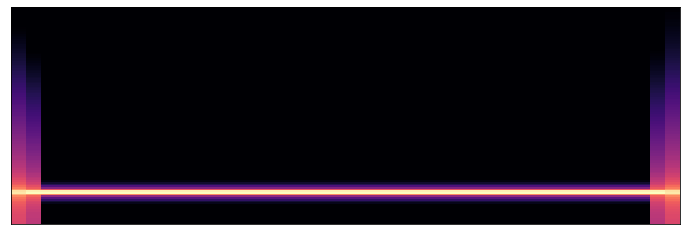

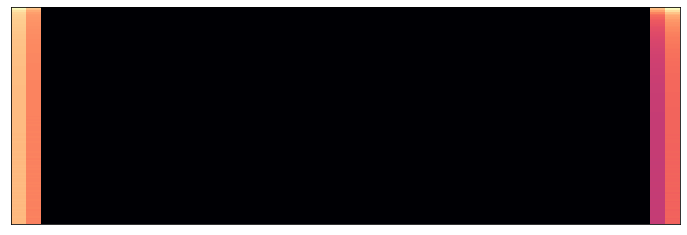

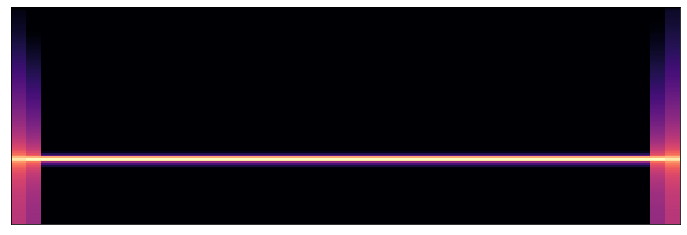

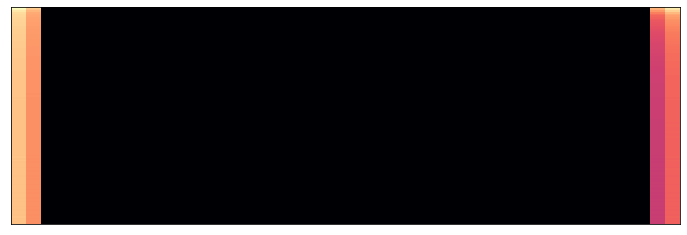

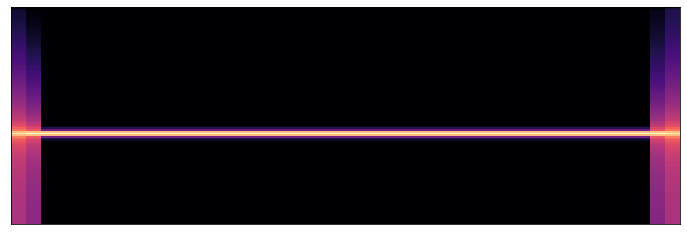

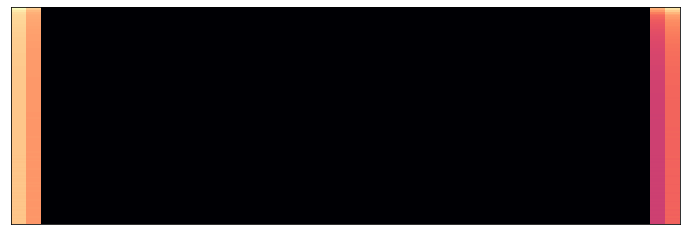

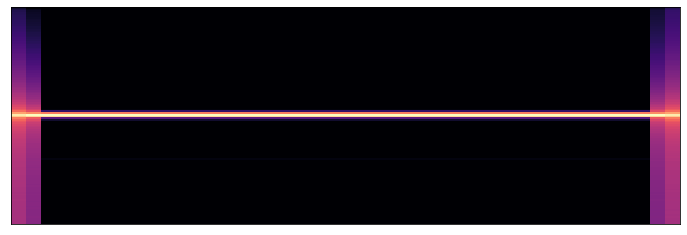

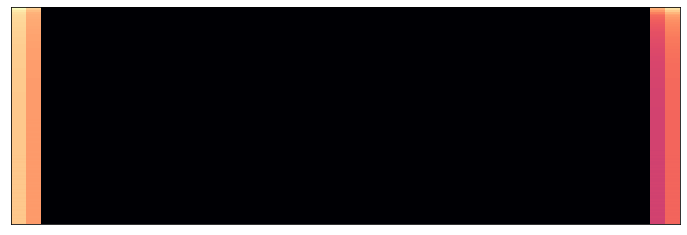

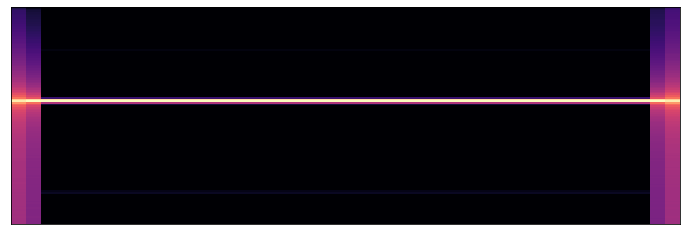

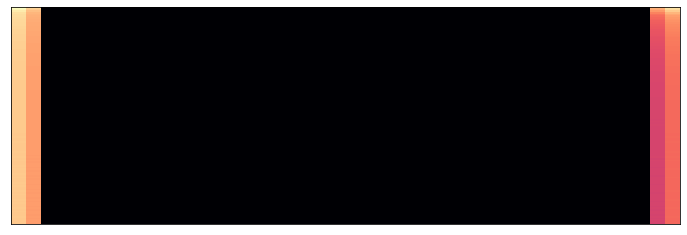

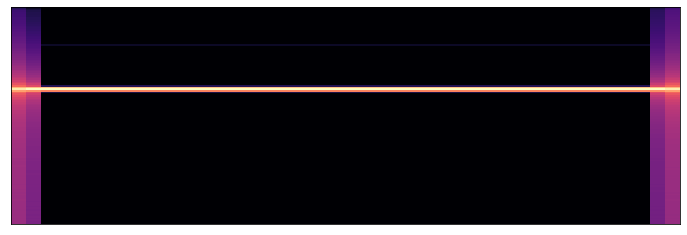

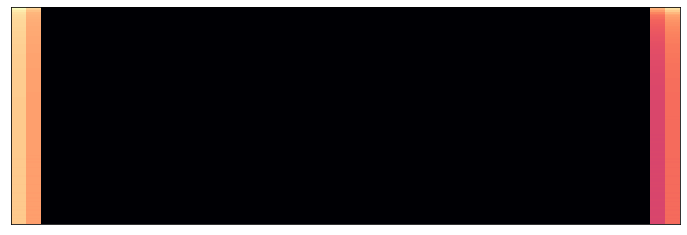

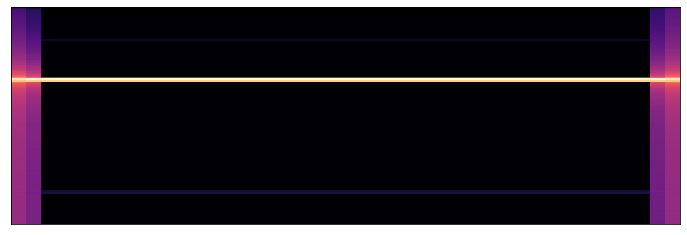

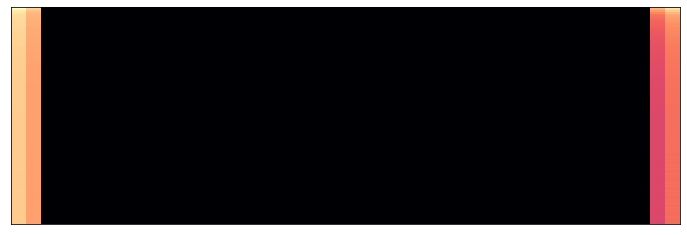

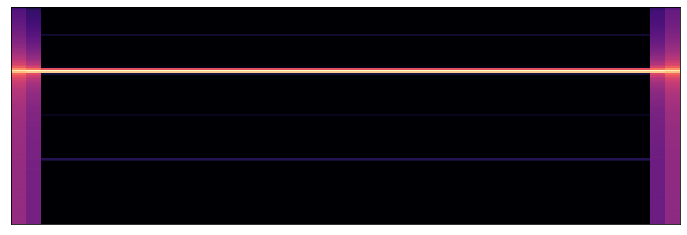

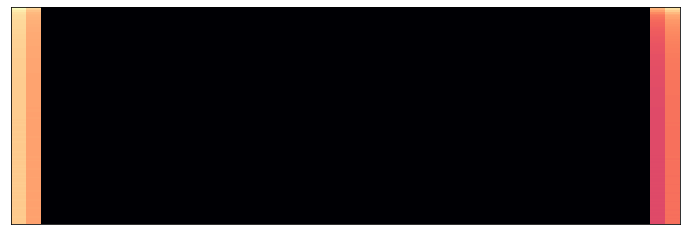

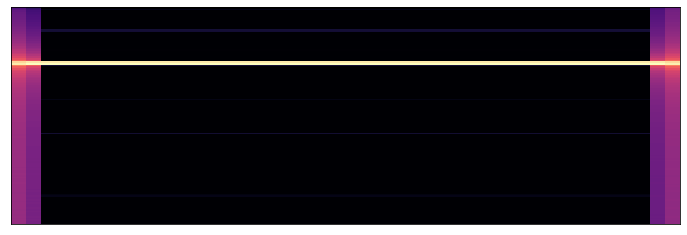

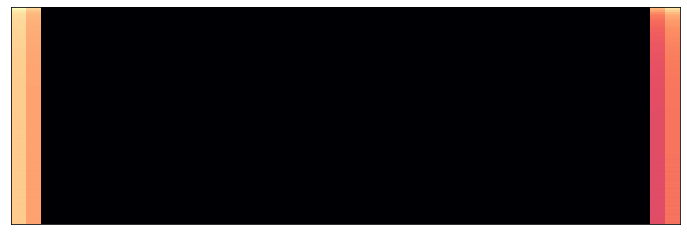

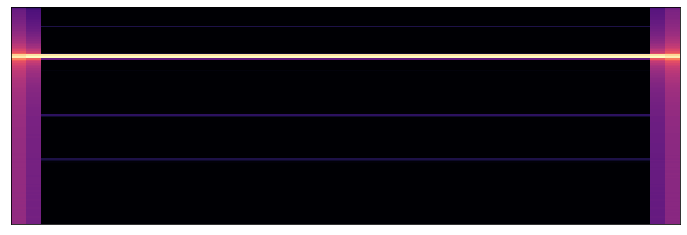

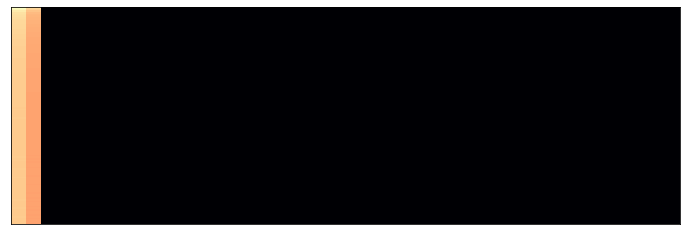

In [ ]:
create_dataset("longt.wav")

print(len(y))
print(sr)
len(y)/sr

## Binary classification
Below we actually preform the binary classification. By reading the label on the previously created file we determine if a sample has a sound in it or not. This will allow us to preform logistic regression to determine if there is a sound or not. 

In [ ]:
def load_data(folder = "dataset"):
    images = []
    labels = []

    for image in os.listdir(folder):
        print(image)
        images.append(plt.imread(folder + "/" + image))
        labels.append(int(image.split("_")[3].split(".")[0]))

    images = np.array(images)
    labels = np.array(labels)
    print(labels)
    images.shape

    # To apply a classifier on this data, we need to flatten the image, to
    # turn the data in a (samples, feature) matrix:
    n_samples = len(images)
    data = images.reshape((n_samples, -1))
    
    return data, images, labels


Here we split our file into labels and used this to preform latter operations. 

In [ ]:
data, images, labels = load_data()

second_0_label_1.png
second_10_label_1.png
second_11_label_0.png
second_12_label_1.png
second_13_label_0.png
second_14_label_1.png
second_15_label_0.png
second_16_label_1.png
second_17_label_0.png
second_18_label_1.png
second_19_label_0.png
second_1_label_0.png
second_20_label_1.png
second_21_label_0.png
second_22_label_1.png
second_23_label_0.png
second_24_label_1.png
second_25_label_0.png
second_26_label_1.png
second_27_label_0.png
second_28_label_1.png
second_29_label_0.png
second_2_label_1.png
second_30_label_1.png
second_31_label_0.png
second_32_label_1.png
second_33_label_0.png
second_34_label_1.png
second_35_label_0.png
second_36_label_1.png
second_37_label_0.png
second_38_label_1.png
second_39_label_0.png
second_3_label_0.png
second_40_label_1.png
second_41_label_0.png
second_42_label_1.png
second_43_label_0.png
second_44_label_1.png
second_45_label_0.png
second_46_label_1.png
second_47_label_0.png
second_48_label_1.png
second_49_label_0.png
second_4_label_1.png
second_5_label_

## Logistic Regression 

The basic idea is to $\beta_0$ and $\beta_1$ that optimize the logistic function

$$LogisticReg(x)=\frac{1}{(1+e^{-(\beta_0+\beta_1 x)})}$$

which has and a range between 0 and 1 (the labels). Below we train our data on basic sine wave.

Predictions for test:
[1 1 0 0 0 0 0 0 1 0 1 0 0 1 1]
score:
1.0


<Figure size 1440x288 with 0 Axes>

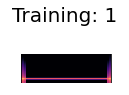

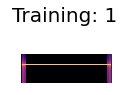

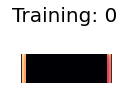

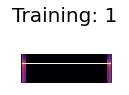

In [ ]:
plt.figure(figsize=(20,4))
images_and_labels = list(zip(images, labels))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i\n' % label, fontsize = 20)  
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=5)
logisticRegr = LogisticRegression(max_iter=150)
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
print("Predictions for test:")
print(predictions)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print("score:")
print(score)


We now create our dictionary of notes and frequency. The notes dictionary will relate notes to frequency and labels_dict will relate notes to a integer for labeling purposes. We used a standard note library from Michigan Technological University, https://pages.mtu.edu/~suits/notefreqs.html which tunes A4=440Hz.

In [ ]:
freq_lib = [16.35,17.32,18.35,19.45,20.60,21.83,23.12,24.50,25.96,27.50,29.14,30.87,32.70,34.65,36.71,38.89,41.20,43.65,46.25,49.00,51.91,55.00,58.27,61.74,65.41,69.30,73.42,77.78,82.41,87.31,92.50,98.00,103.83,110.00,116.54,
            123.47,130.81,138.59,146.83,155.56,164.81,174.61,185.00,196.00,207.65,220.00,233.08,246.94,261.63,277.18,293.66,311.13,329.63,349.23,369.99,392.00,415.30,440.00,466.16,493.88,523.25,554.37,587.33,622.25,659.26,698.46,
            739.99,783.99,830.61,880.00,932.33,987.77,1046.50,1108.73,1174.66,1244.51,1318.51,1396.91,1479.98,1567.98,1661.22,1760.00,1864.66,1975.53,2093.00,2217.46,2349.32,2489.02,2637.02,2793.83,2959.96,3135.96,3322.44,3520.00,
            3729.31,3951.07,4186.01,4434.92,4698.64,4978.03,5274.04,5587.65,5919.91,6271.93,6644.88,7040.00,7458.62,7902.13,8000]
note_lib = ["C0","C#0","D0","D#0","E0","F0","F#0","G0","G#0","A0","A#0","B0","C1","C#1","D1","D#1","E1","F1",
            "F#1","G1","G#1","A1","A#1","B1","C2","C#2","D2","D#2","E2","F2","F#2","G2","G2#","A2","A2#","B2",
            "C3","C3#","D3","D3#","E3","F3","F3#","G3","G3#","A3","A3#","B3","C4","C4#","D4","D4#","E4","F4","F4#",
            "G4","G4#","A4","A4#","B4","C5","C5#","D5","D5#","E5","F5","F5#","G5","G5#","A5","A5#","B5","C6","C6#","D6",
            "D6#","E6","F6","F6#","G6","G6#","A6","A6#","B6","C7","C7#","D7","D7#","E7","F7","F7#","G7","G7#","A7","A7#",
            "B7","C8","C8#","D8","D8#","E8","F8","F8#","G8","G8#","A8","A8#","B8","Beyond B8"]
notes = {}
labels_dict = {}
for i in range(len(note_lib)):
    notes[note_lib[i]] = freq_lib[i]
    labels_dict["silence"] =  0
    labels_dict[note_lib[i]] = i+1

In [ ]:
labels_dict

{'silence': 0,
 'C0': 1,
 'C#0': 2,
 'D0': 3,
 'D#0': 4,
 'E0': 5,
 'F0': 6,
 'F#0': 7,
 'G0': 8,
 'G#0': 9,
 'A0': 10,
 'A#0': 11,
 'B0': 12,
 'C1': 13,
 'C#1': 14,
 'D1': 15,
 'D#1': 16,
 'E1': 17,
 'F1': 18,
 'F#1': 19,
 'G1': 20,
 'G#1': 21,
 'A1': 22,
 'A#1': 23,
 'B1': 24,
 'C2': 25,
 'C#2': 26,
 'D2': 27,
 'D#2': 28,
 'E2': 29,
 'F2': 30,
 'F#2': 31,
 'G2': 32,
 'G2#': 33,
 'A2': 34,
 'A2#': 35,
 'B2': 36,
 'C3': 37,
 'C3#': 38,
 'D3': 39,
 'D3#': 40,
 'E3': 41,
 'F3': 42,
 'F3#': 43,
 'G3': 44,
 'G3#': 45,
 'A3': 46,
 'A3#': 47,
 'B3': 48,
 'C4': 49,
 'C4#': 50,
 'D4': 51,
 'D4#': 52,
 'E4': 53,
 'F4': 54,
 'F4#': 55,
 'G4': 56,
 'G4#': 57,
 'A4': 58,
 'A4#': 59,
 'B4': 60,
 'C5': 61,
 'C5#': 62,
 'D5': 63,
 'D5#': 64,
 'E5': 65,
 'F5': 66,
 'F5#': 67,
 'G5': 68,
 'G5#': 69,
 'A5': 70,
 'A5#': 71,
 'B5': 72,
 'C6': 73,
 'C6#': 74,
 'D6': 75,
 'D6#': 76,
 'E6': 77,
 'F6': 78,
 'F6#': 79,
 'G6': 80,
 'G6#': 81,
 'A6': 82,
 'A6#': 83,
 'B6': 84,
 'C7': 85,
 'C7#': 86,
 'D7': 87,
 

In [ ]:
notes

{'C0': 16.35,
 'C#0': 17.32,
 'D0': 18.35,
 'D#0': 19.45,
 'E0': 20.6,
 'F0': 21.83,
 'F#0': 23.12,
 'G0': 24.5,
 'G#0': 25.96,
 'A0': 27.5,
 'A#0': 29.14,
 'B0': 30.87,
 'C1': 32.7,
 'C#1': 34.65,
 'D1': 36.71,
 'D#1': 38.89,
 'E1': 41.2,
 'F1': 43.65,
 'F#1': 46.25,
 'G1': 49.0,
 'G#1': 51.91,
 'A1': 55.0,
 'A#1': 58.27,
 'B1': 61.74,
 'C2': 65.41,
 'C#2': 69.3,
 'D2': 73.42,
 'D#2': 77.78,
 'E2': 82.41,
 'F2': 87.31,
 'F#2': 92.5,
 'G2': 98.0,
 'G2#': 103.83,
 'A2': 110.0,
 'A2#': 116.54,
 'B2': 123.47,
 'C3': 130.81,
 'C3#': 138.59,
 'D3': 146.83,
 'D3#': 155.56,
 'E3': 164.81,
 'F3': 174.61,
 'F3#': 185.0,
 'G3': 196.0,
 'G3#': 207.65,
 'A3': 220.0,
 'A3#': 233.08,
 'B3': 246.94,
 'C4': 261.63,
 'C4#': 277.18,
 'D4': 293.66,
 'D4#': 311.13,
 'E4': 329.63,
 'F4': 349.23,
 'F4#': 369.99,
 'G4': 392.0,
 'G4#': 415.3,
 'A4': 440.0,
 'A4#': 466.16,
 'B4': 493.88,
 'C5': 523.25,
 'C5#': 554.37,
 'D5': 587.33,
 'D5#': 622.25,
 'E5': 659.26,
 'F5': 698.46,
 'F5#': 739.99,
 'G5': 783.99,
 

We now generate our 11 files with all of our notes in it. We choose 11 as our total number of notes is 109, with this many notes we could not use our naming scheme to name to one file due to Windows file name length. Note this is not quick by any means, to run its takes approximately 25 minutes, so be aware when running. 

In [ ]:
keys = list(labels_dict)
wav_nam = []
for j in range(0,11):
    sine_wave=[]
    file_name = ""
    notesub = []
    for i in range(1,11):
        #bit of a hitch where 109 would throw an error so I just hard coded it in
        if (j == 10):
            if (i>9):
                file_name += str(109) + "_"
                sine_wave += make_sine(notes[keys[109]])
            else: 
                file_name += str(100+i) + "_"
                sine_wave += make_sine(notes[keys[100+i]])
        else:
            file_name += str(10*j+i) + "_"
            sine_wave += make_sine(notes[keys[10*j+i]])
    wav_name = file_name + "notes.wav"
    wav_nam.append(wav_name)
    save_wav(sine_wave, wav_nam[j])

Using the created files we put them into a single dataset.

C:\Users\gja17002\AppData\Local\Temp/ipykernel_18768/3803057483.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,4))


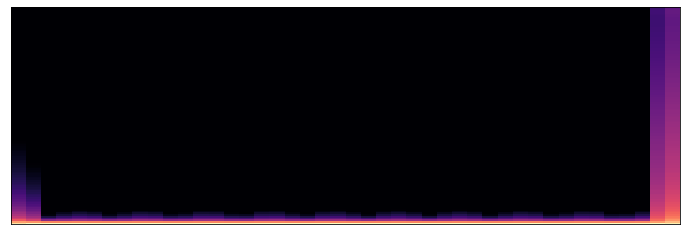

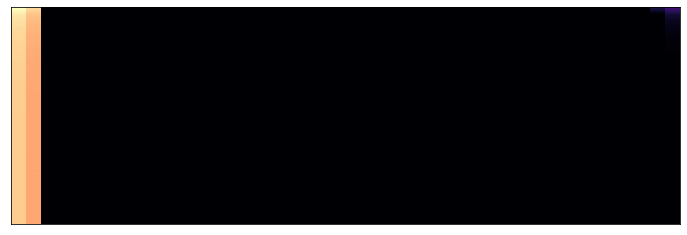

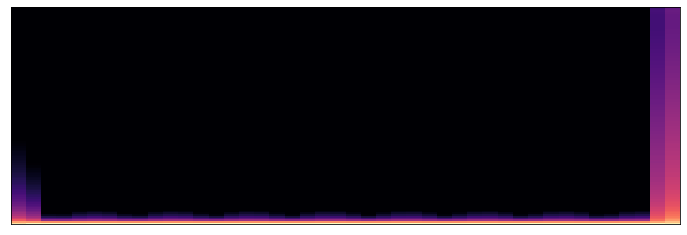

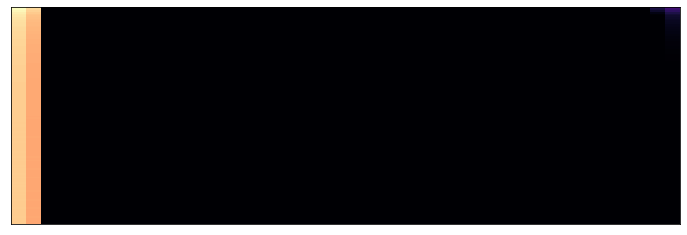

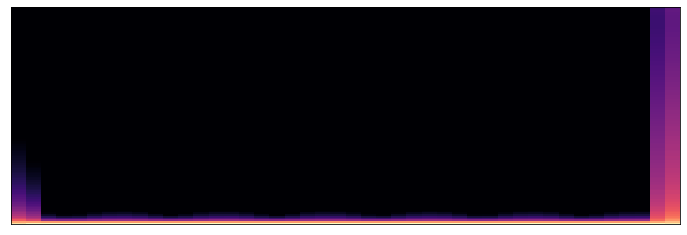

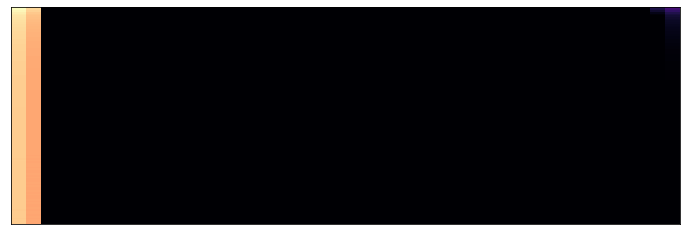

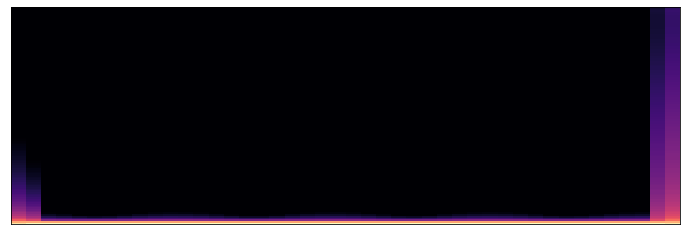

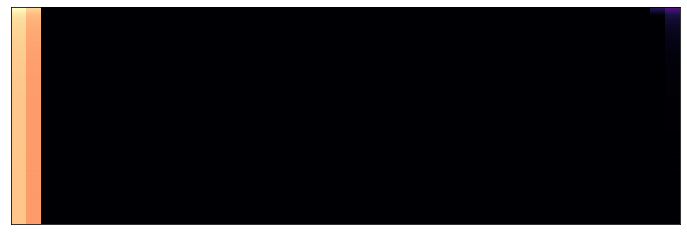

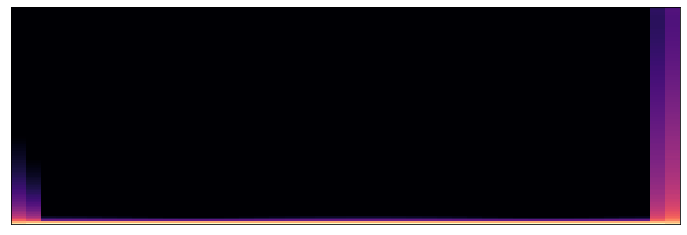

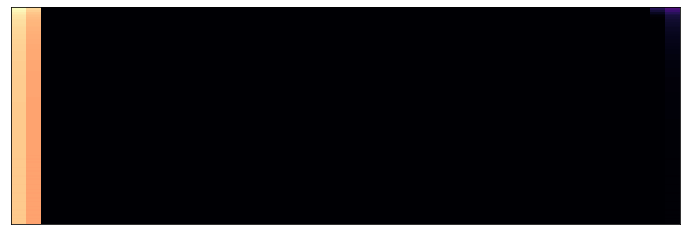

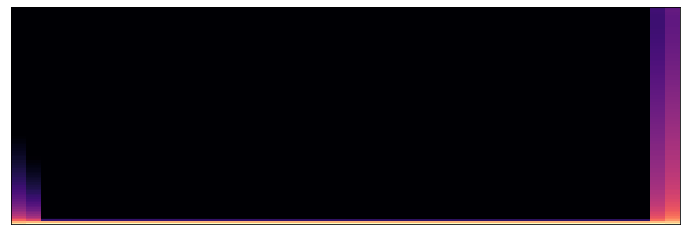

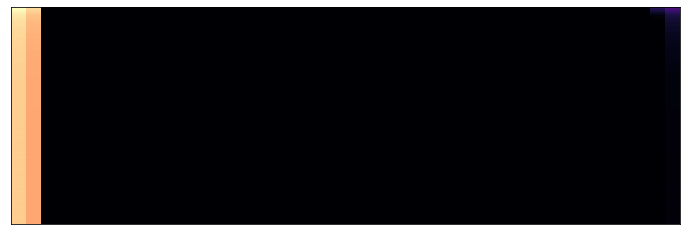

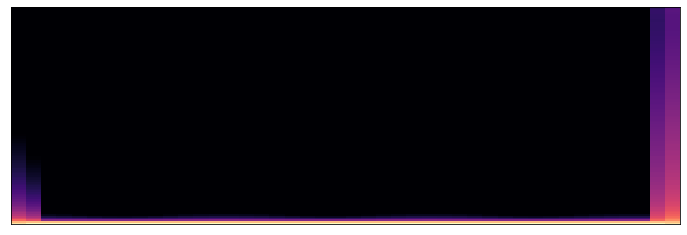

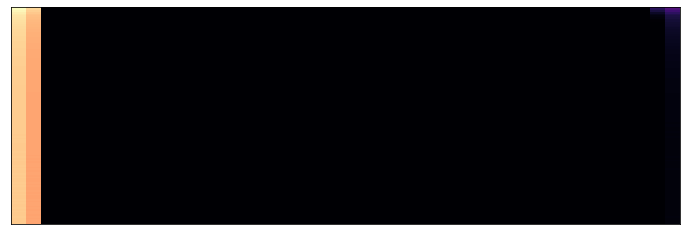

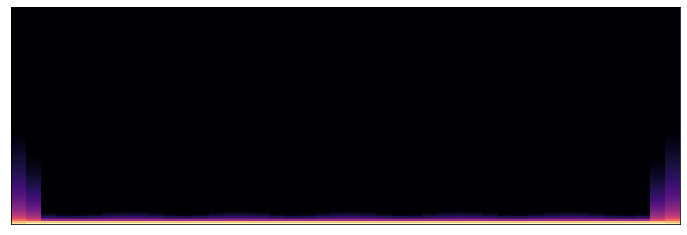

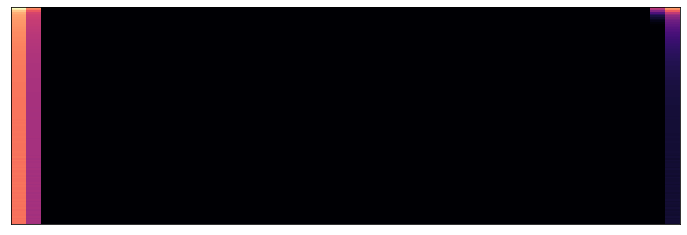

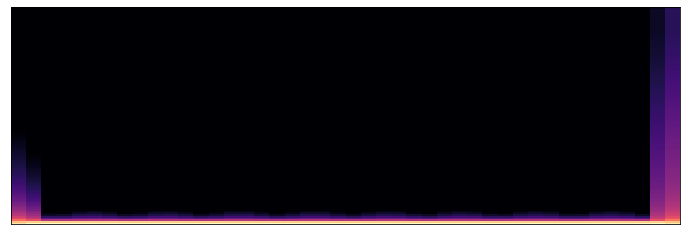

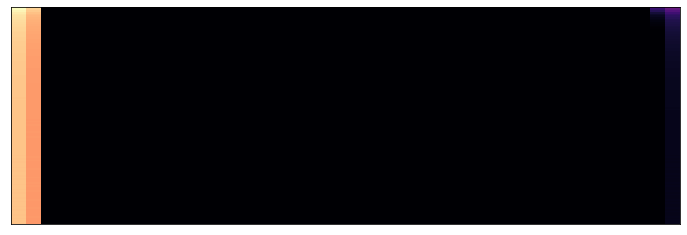

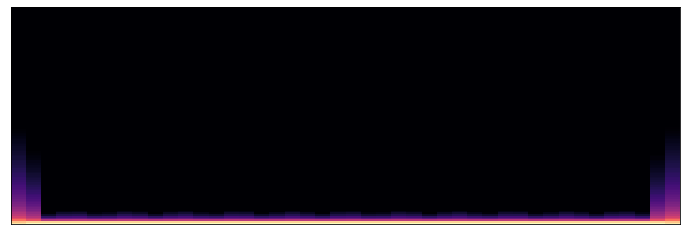

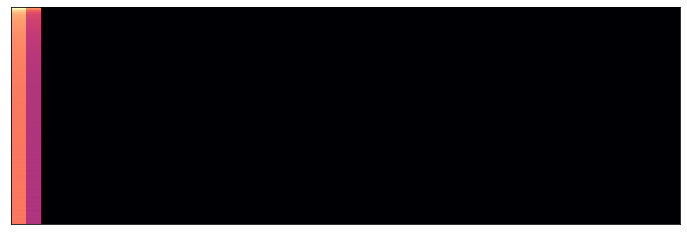

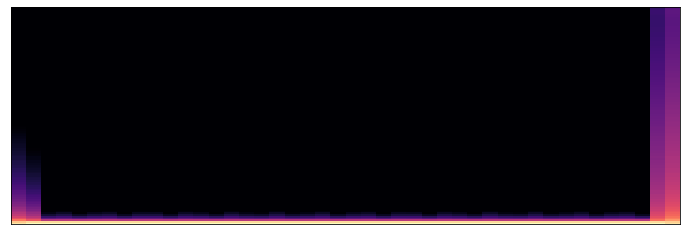

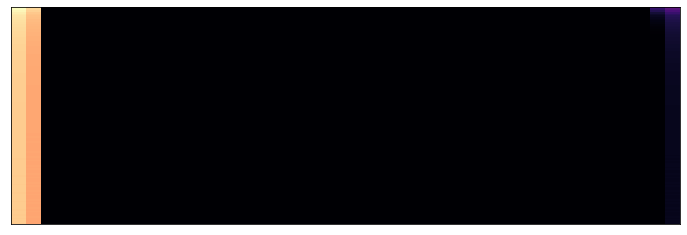

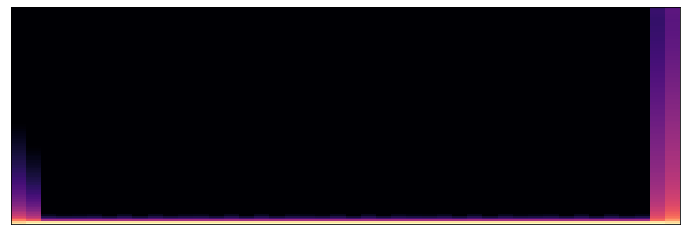

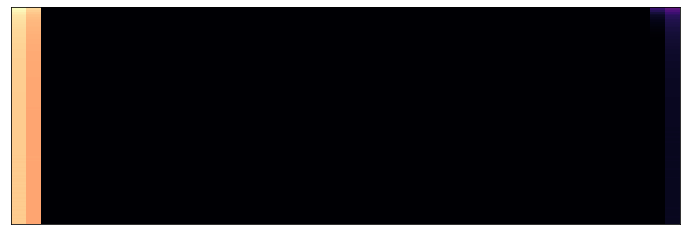

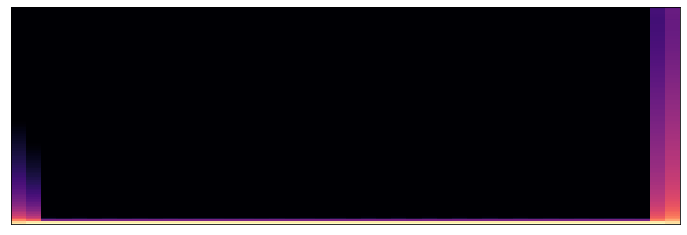

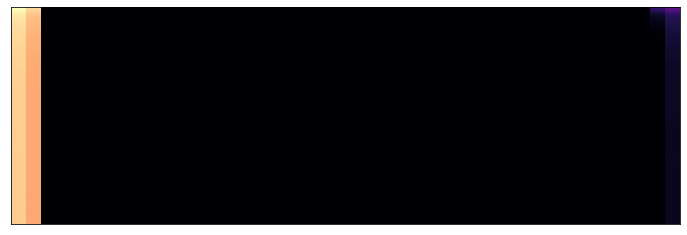

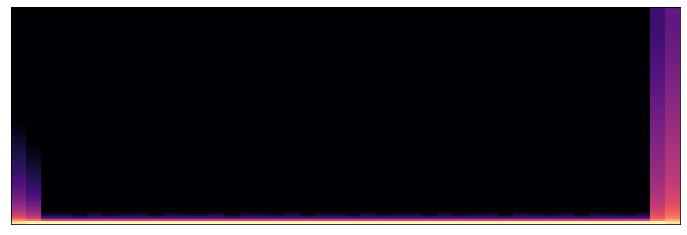

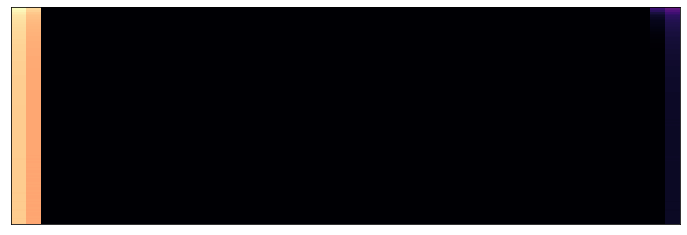

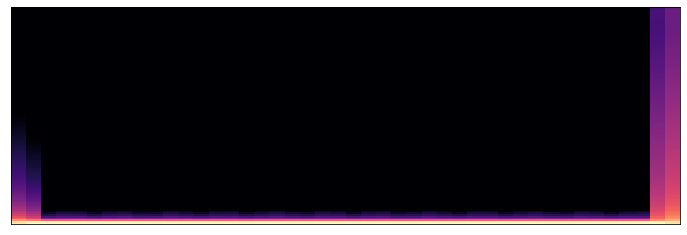

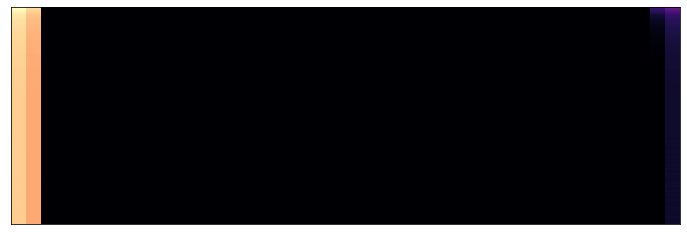

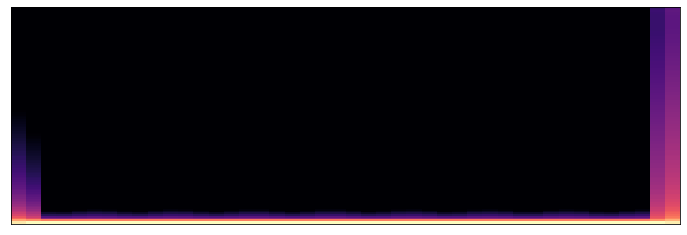

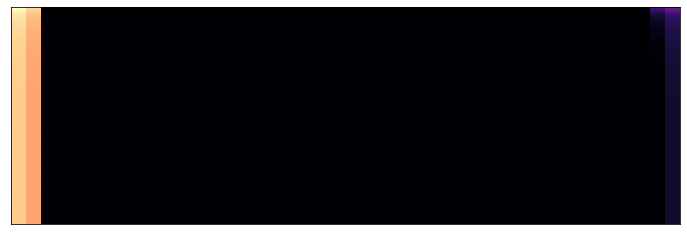

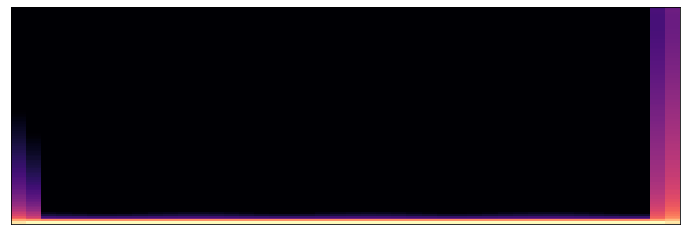

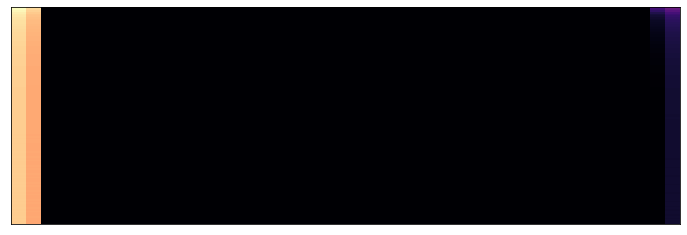

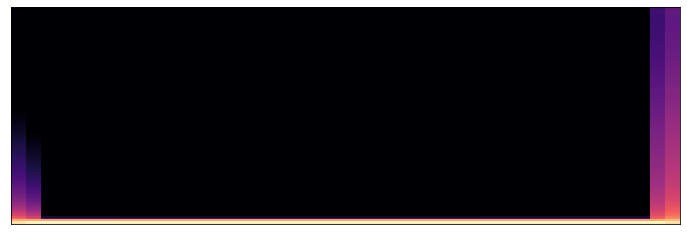

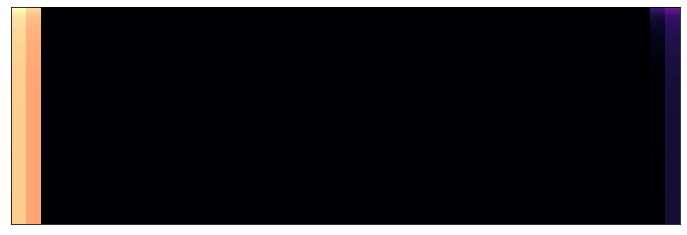

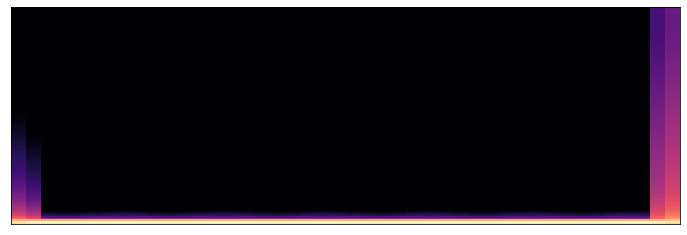

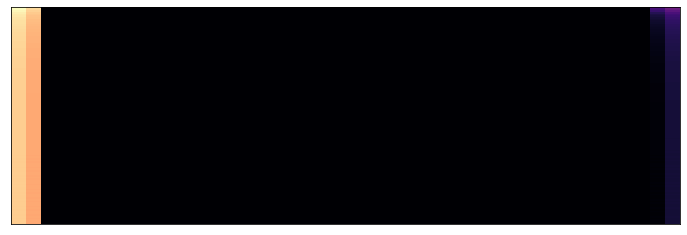

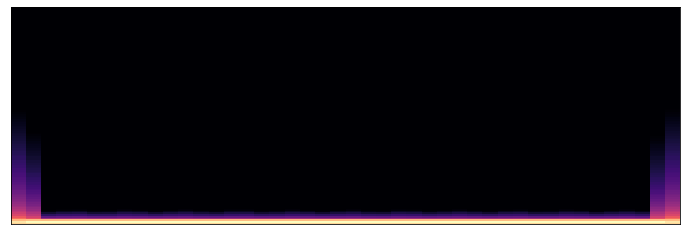

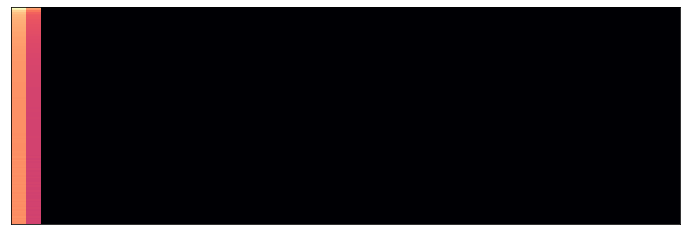

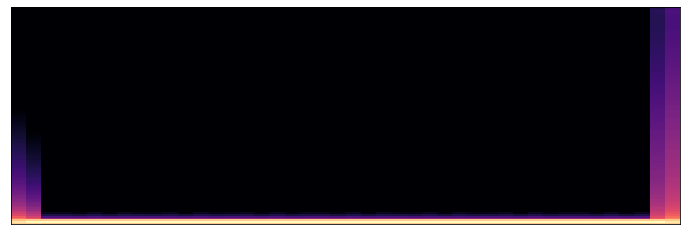

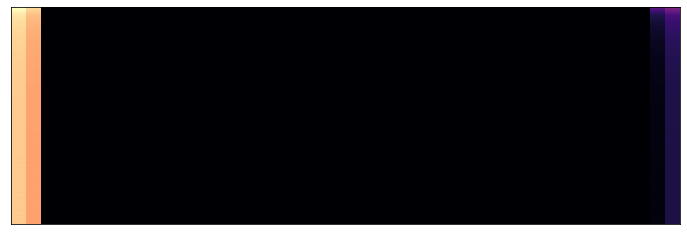

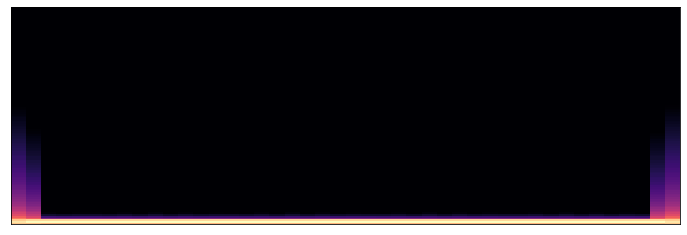

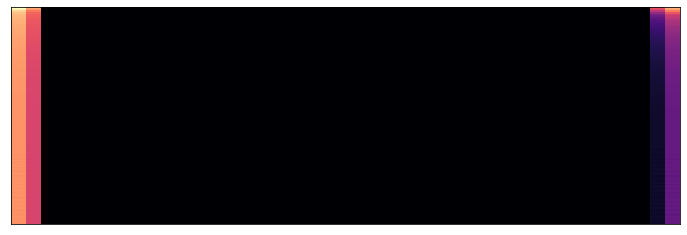

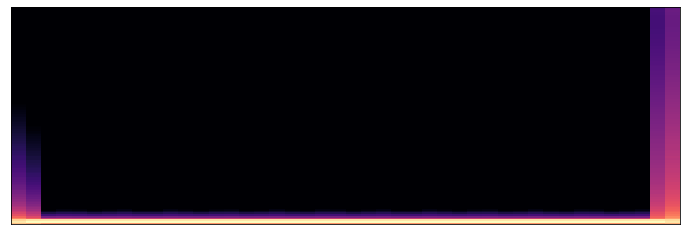

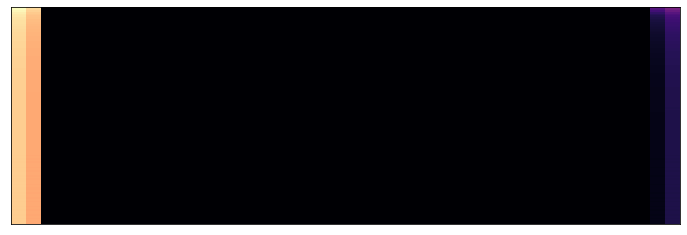

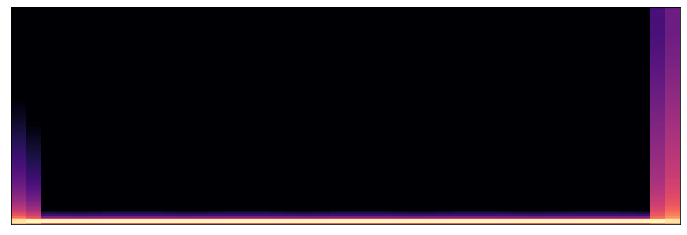

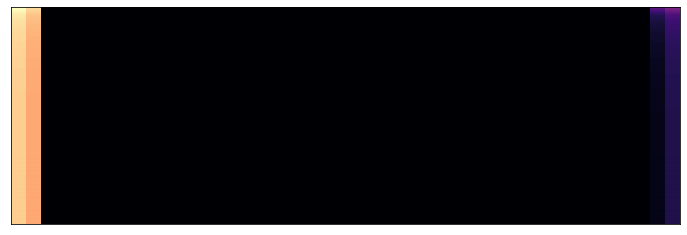

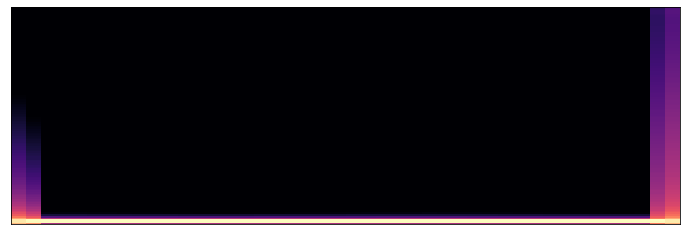

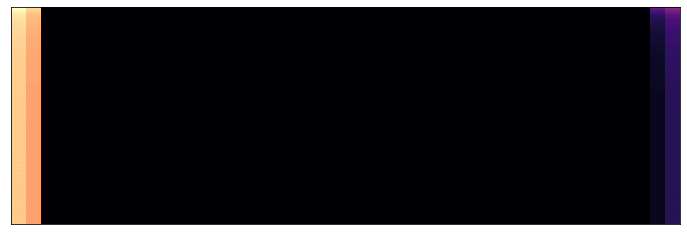

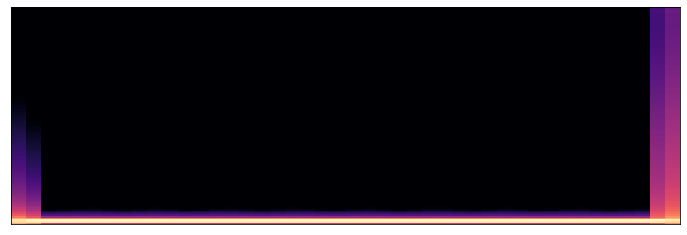

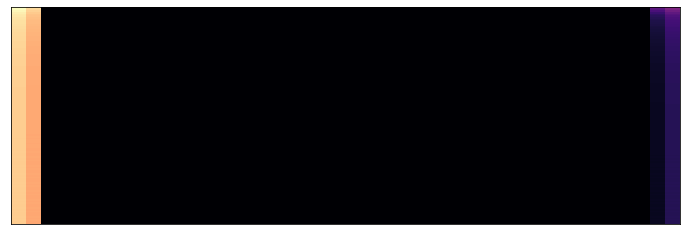

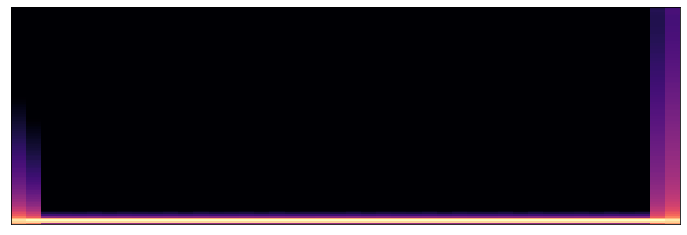

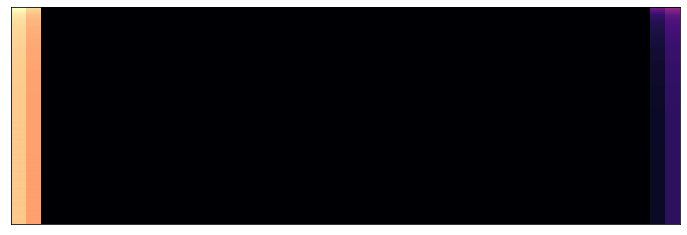

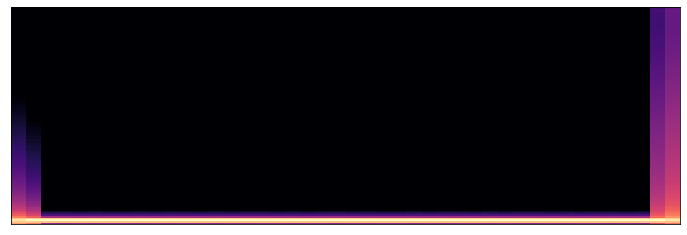

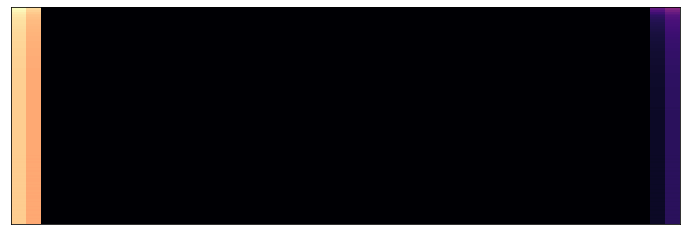

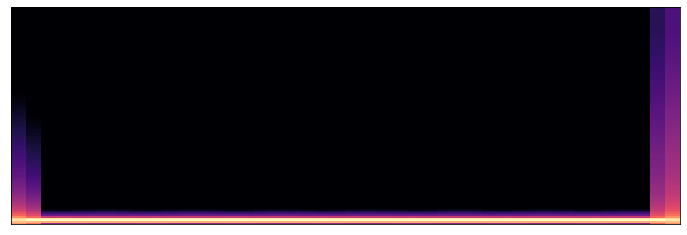

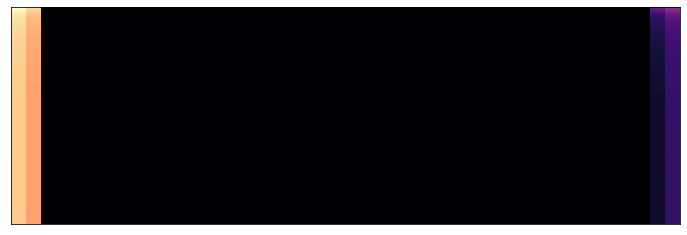

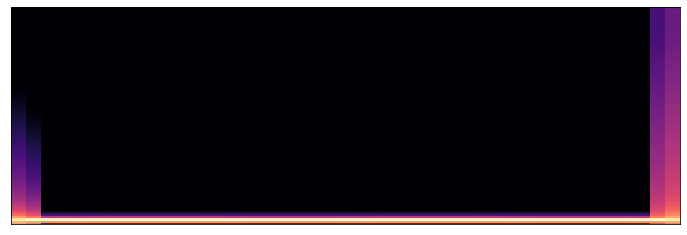

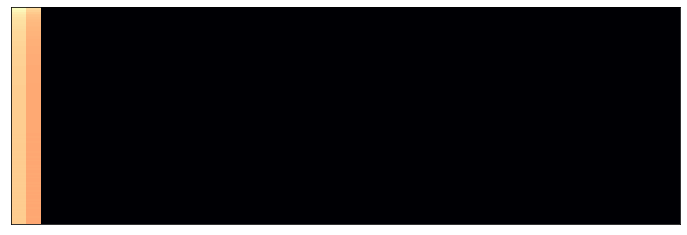

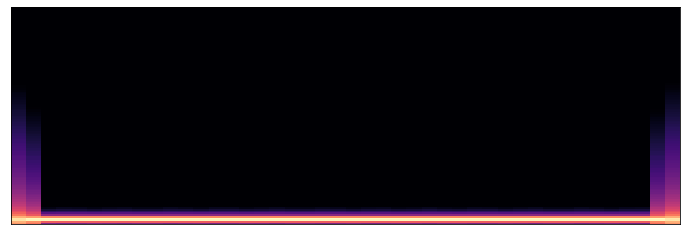

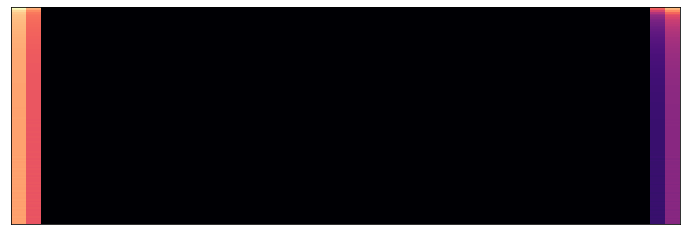

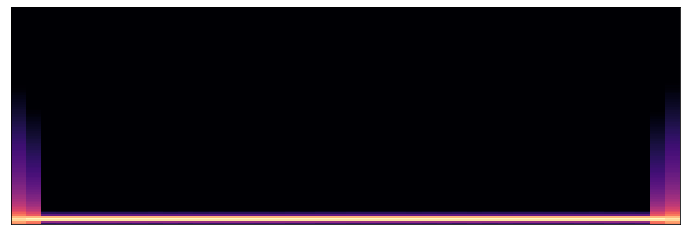

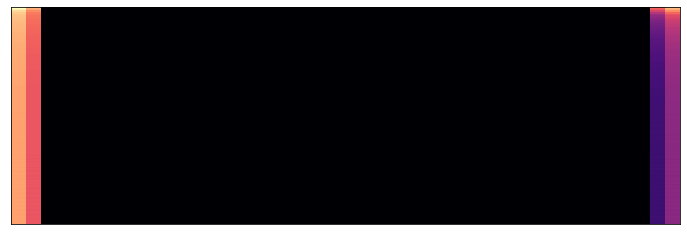

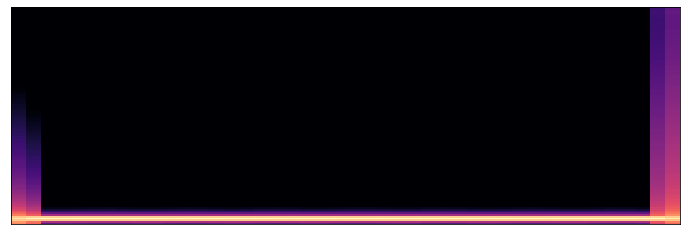

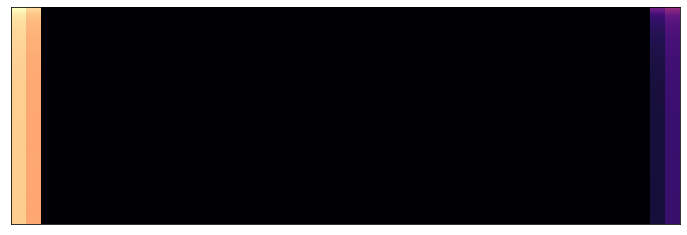

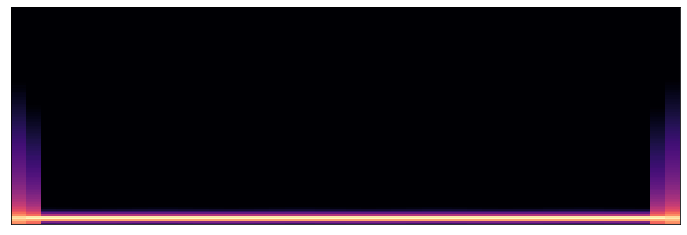

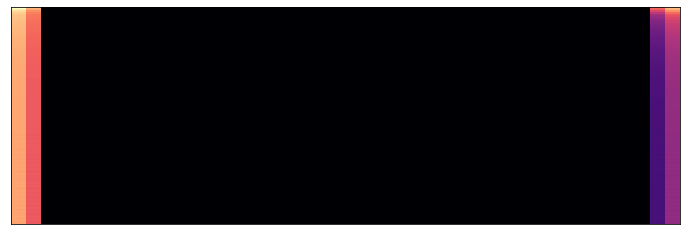

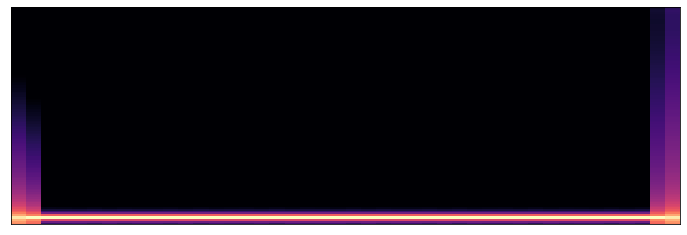

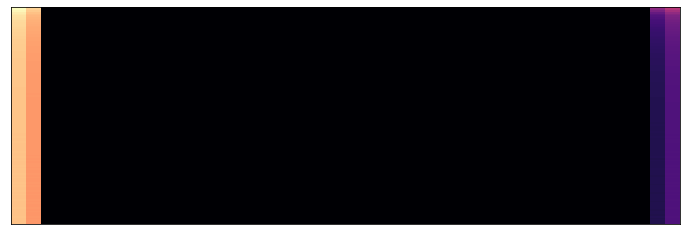

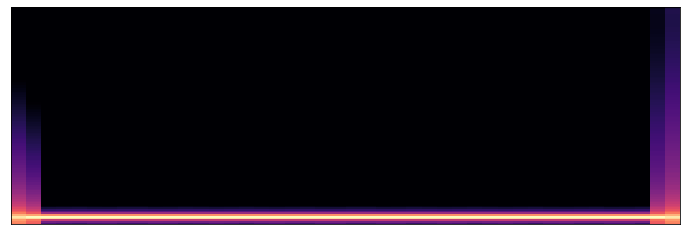

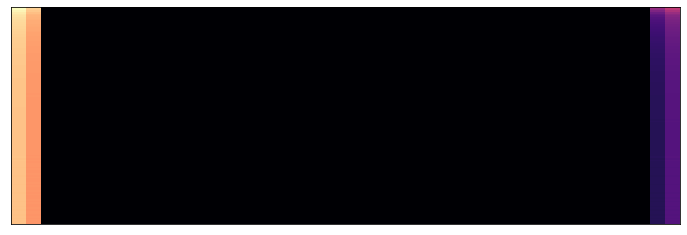

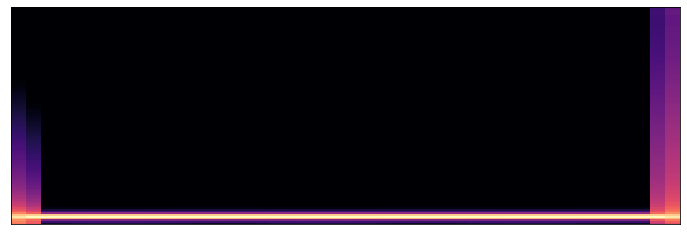

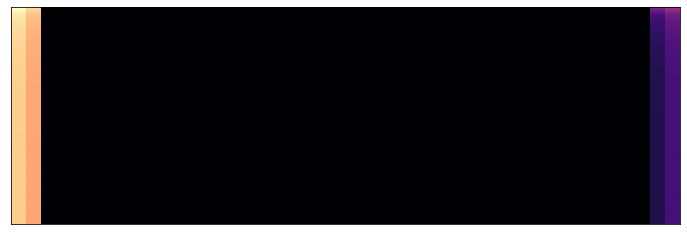

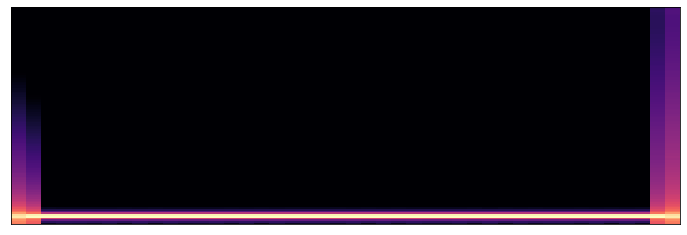

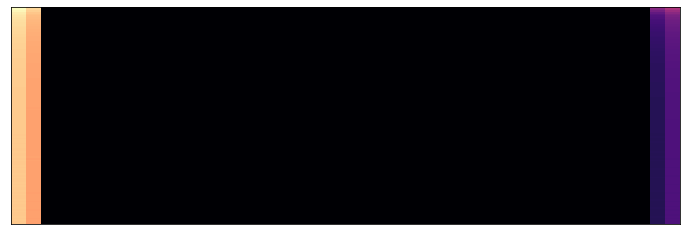

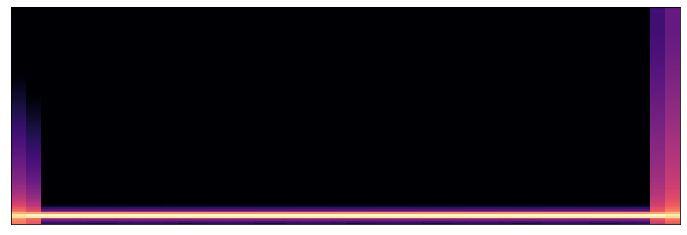

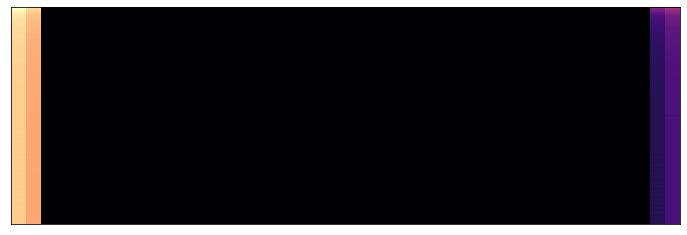

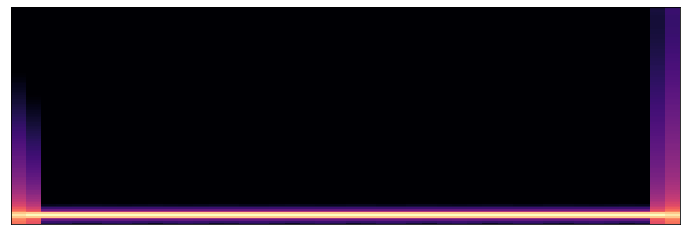

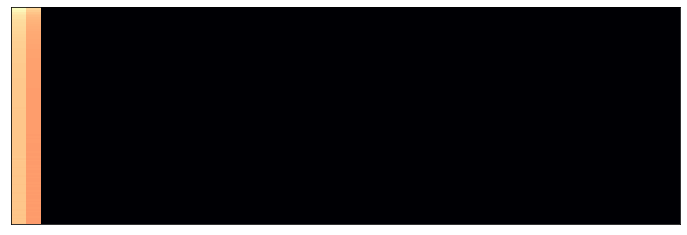

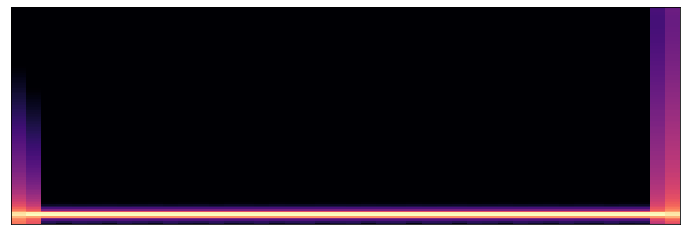

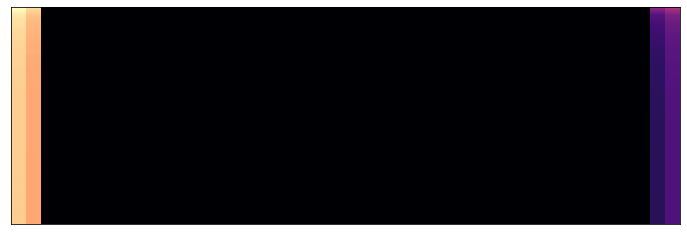

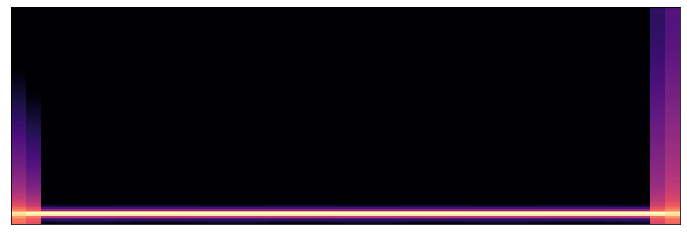

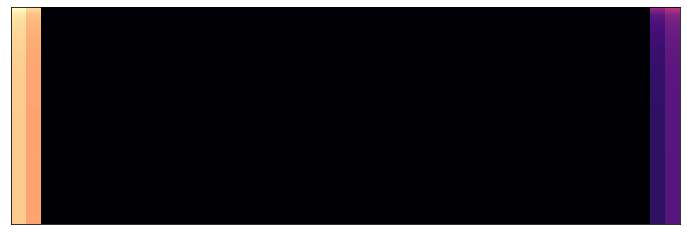

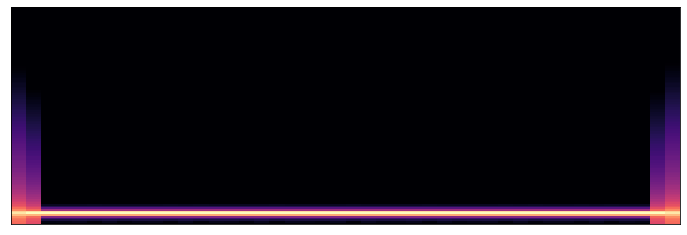

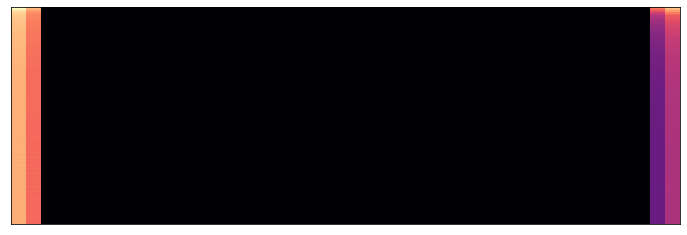

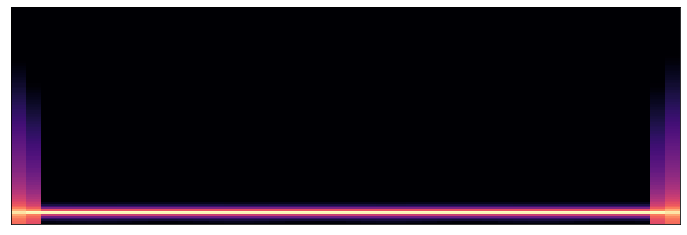

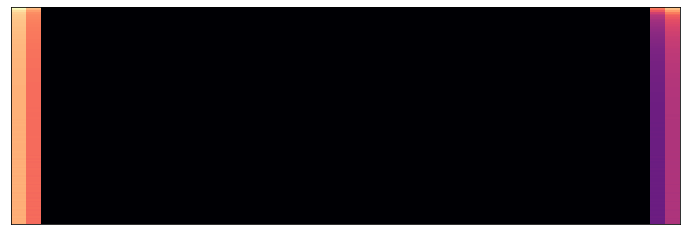

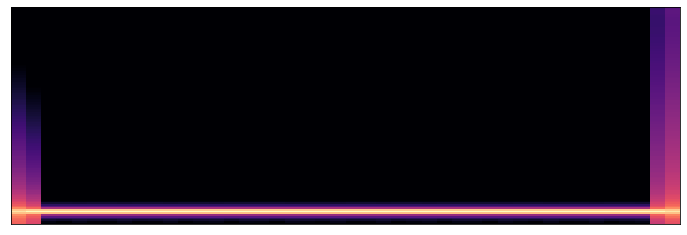

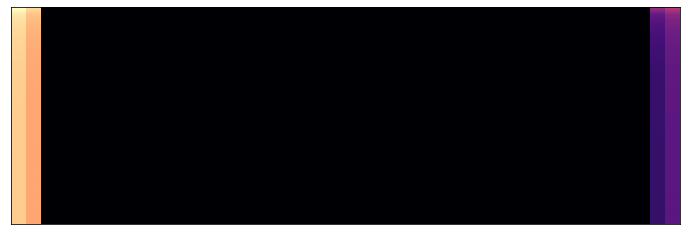

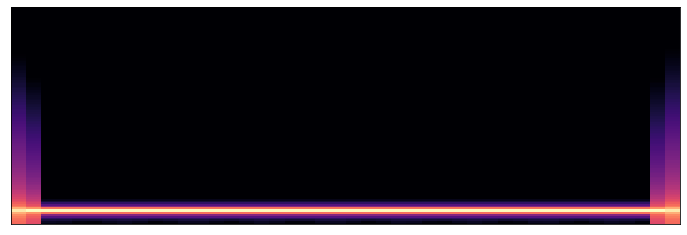

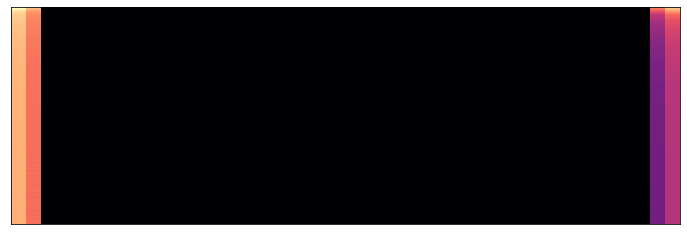

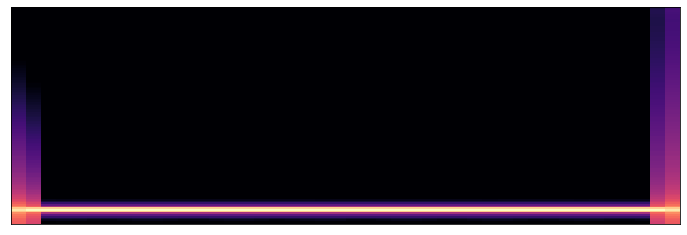

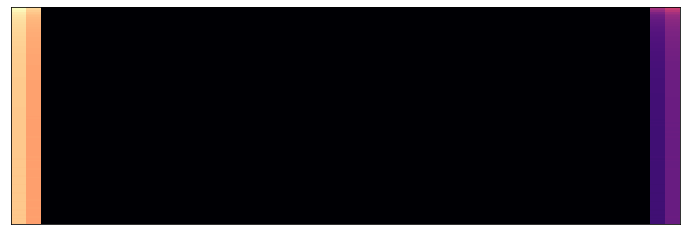

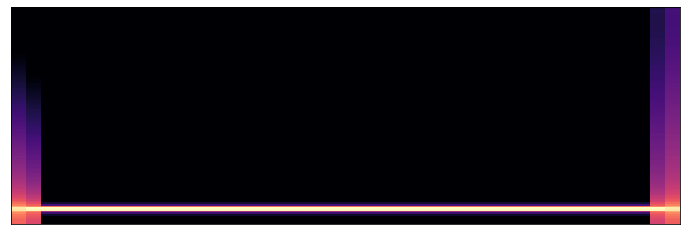

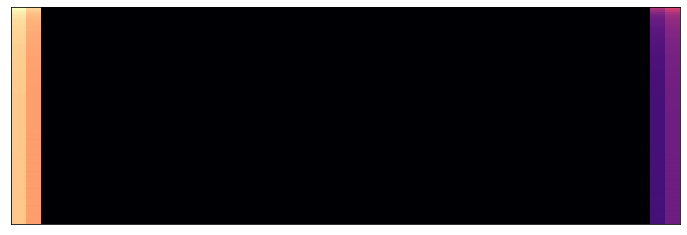

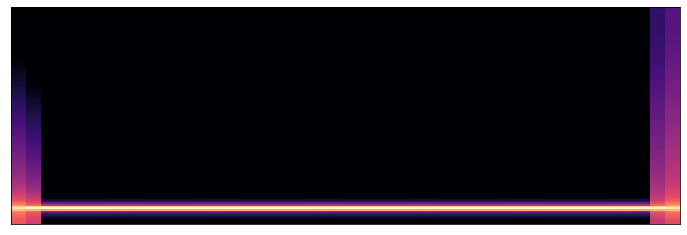

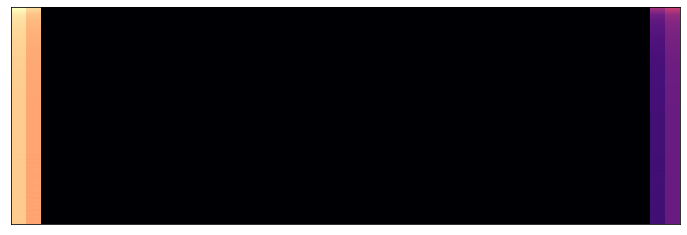

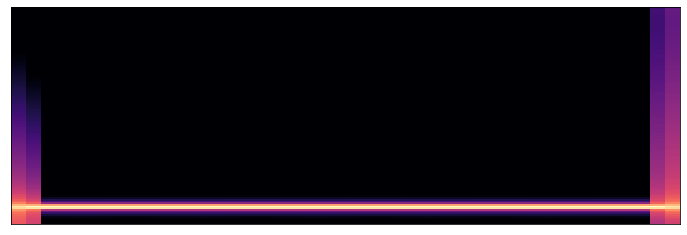

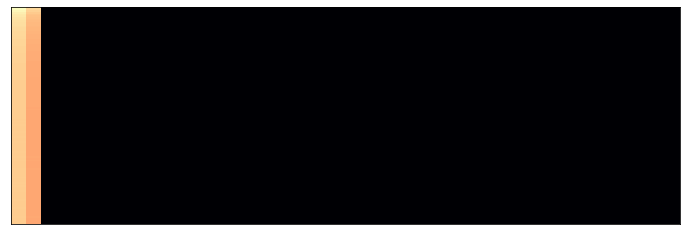

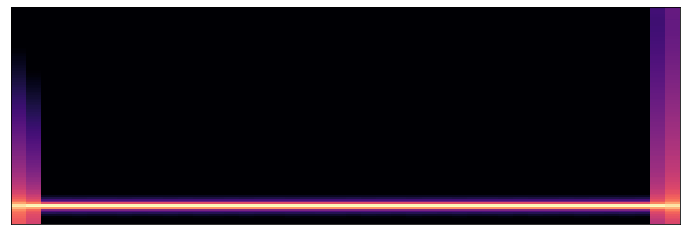

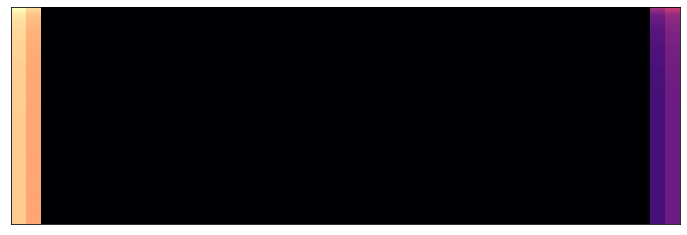

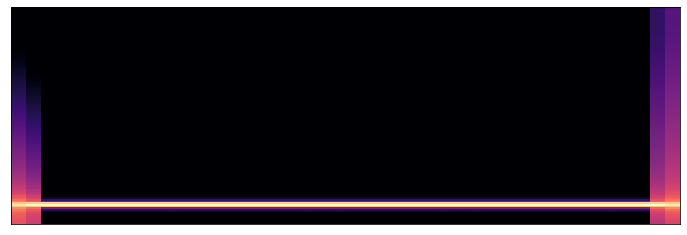

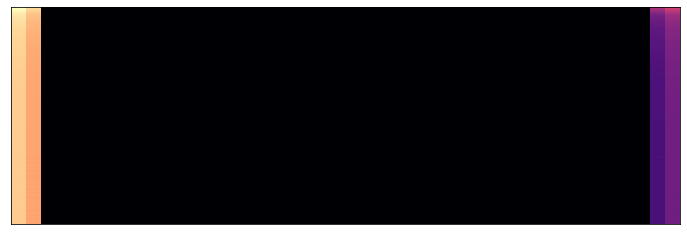

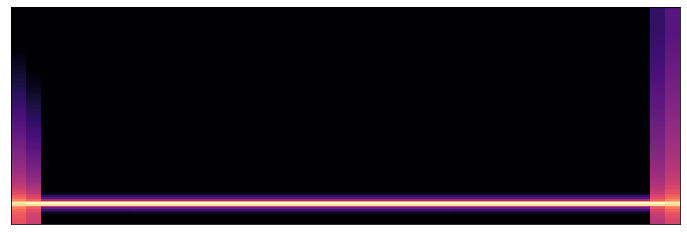

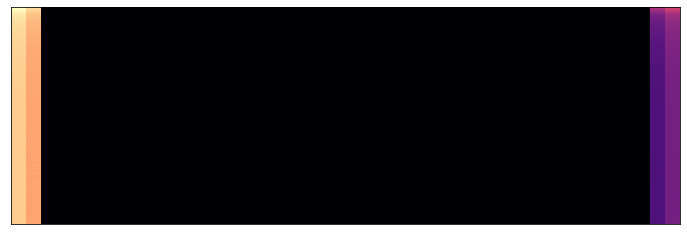

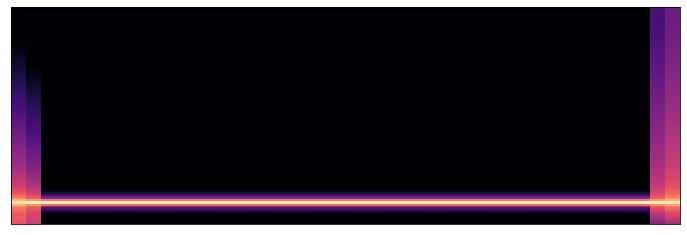

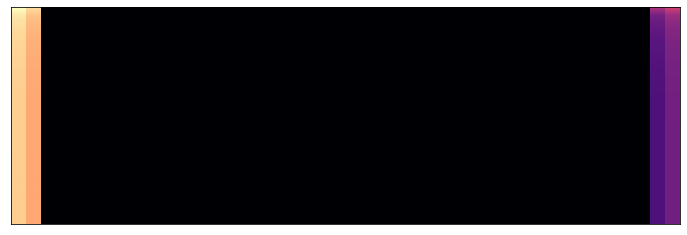

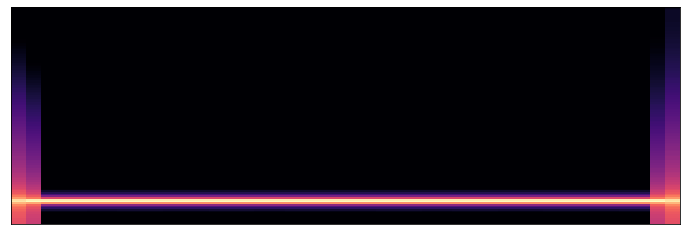

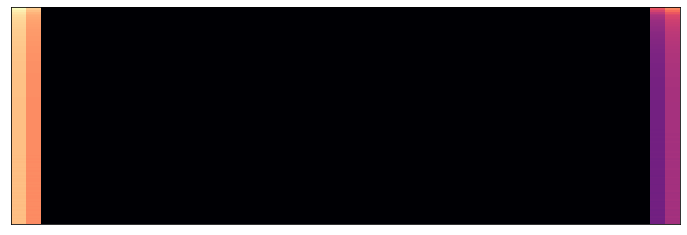

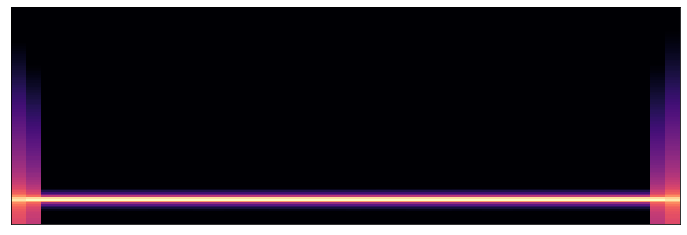

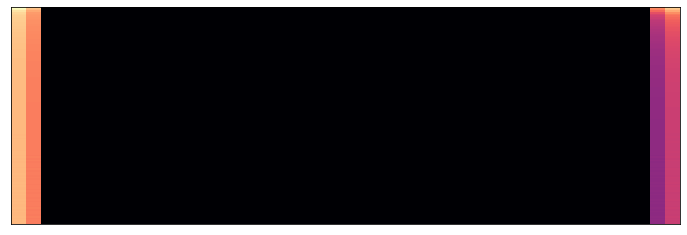

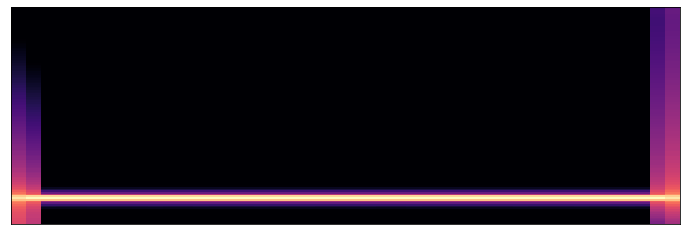

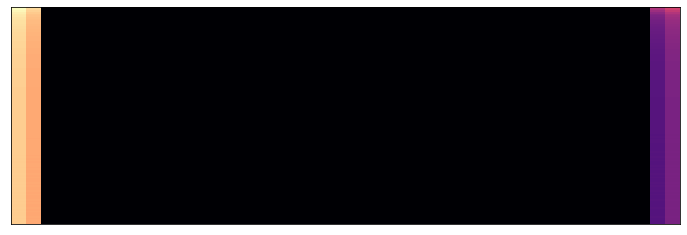

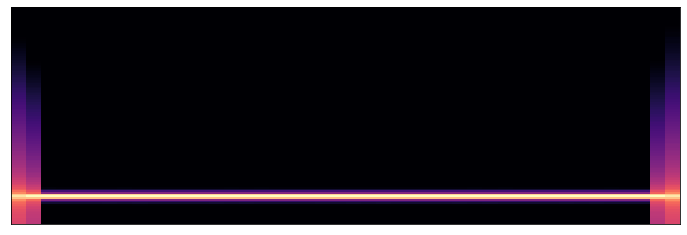

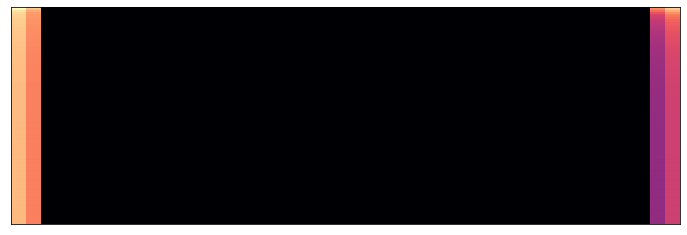

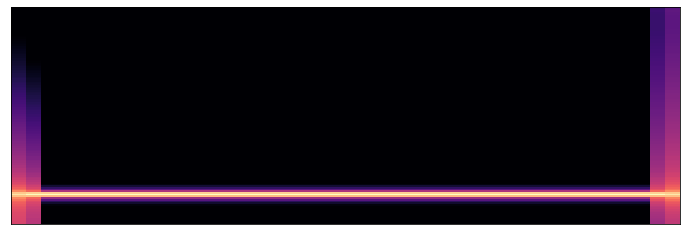

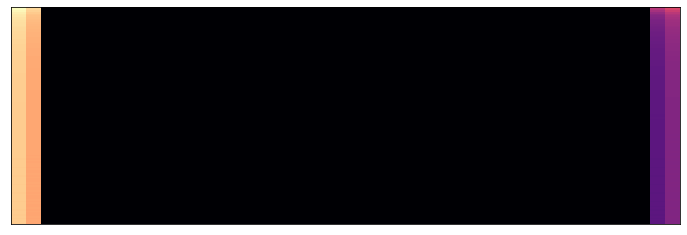

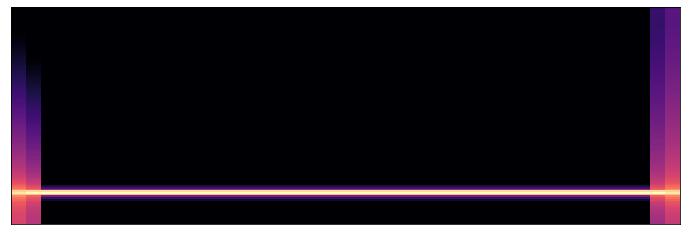

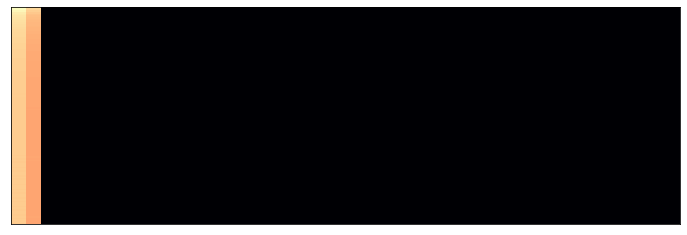

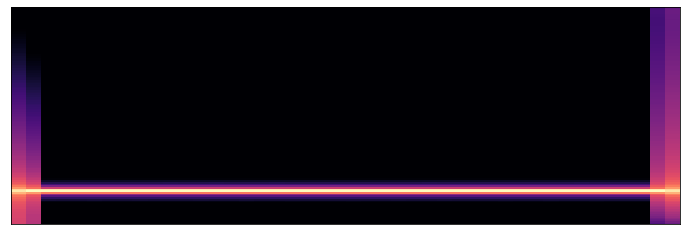

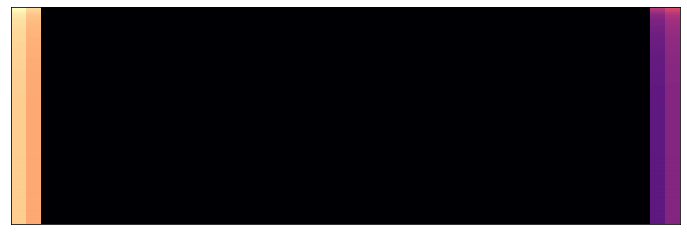

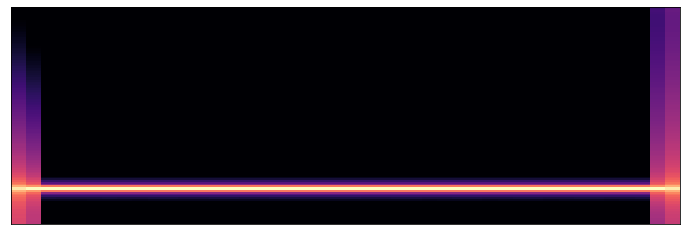

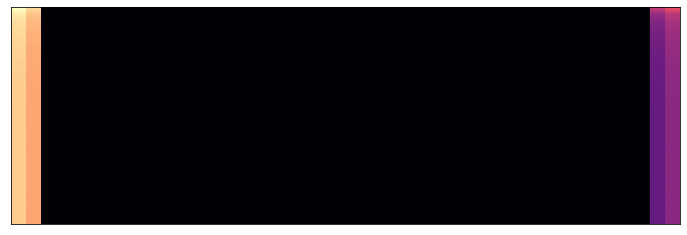

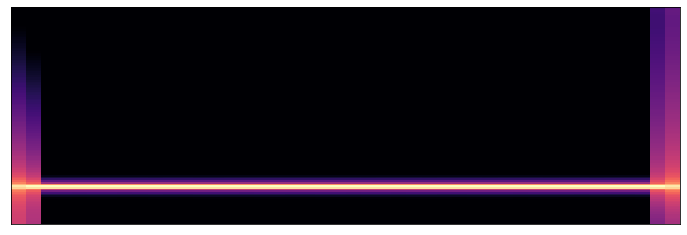

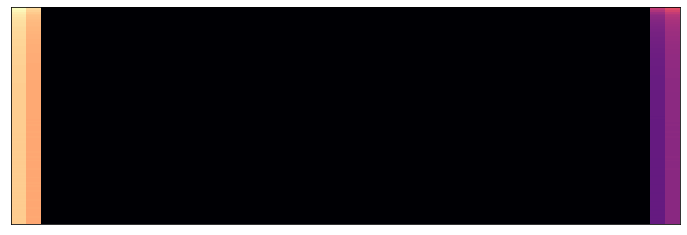

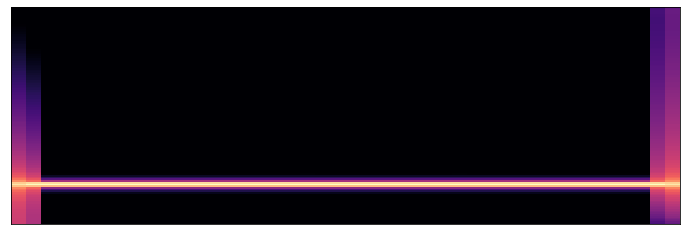

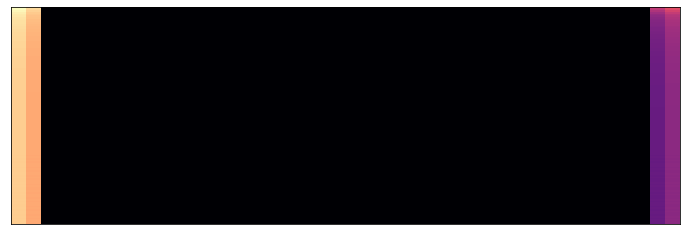

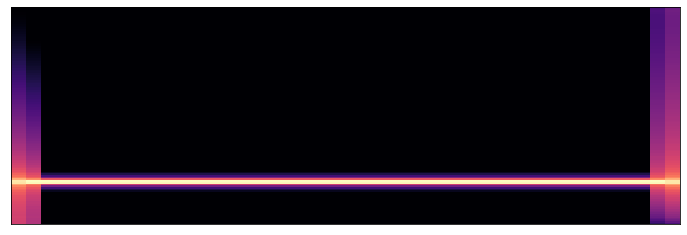

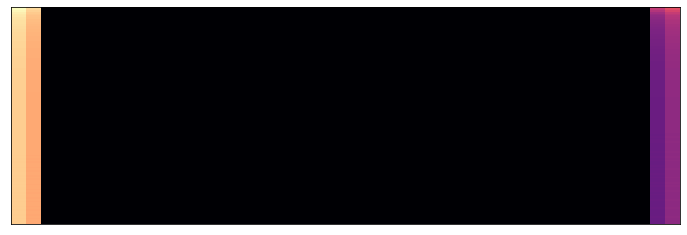

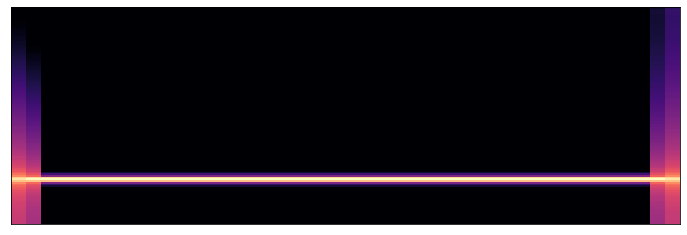

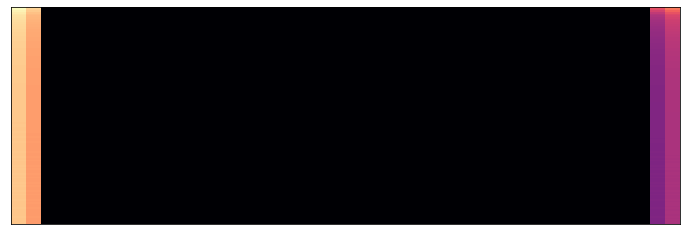

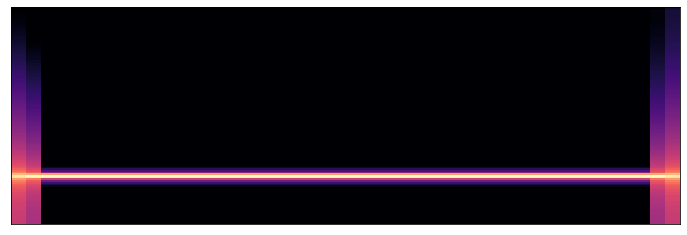

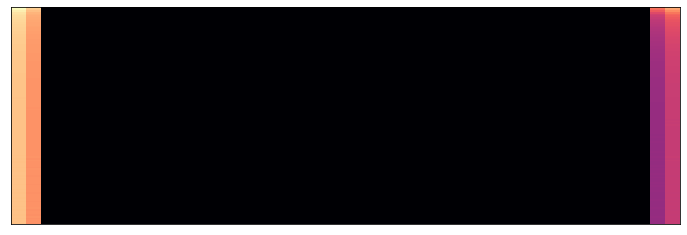

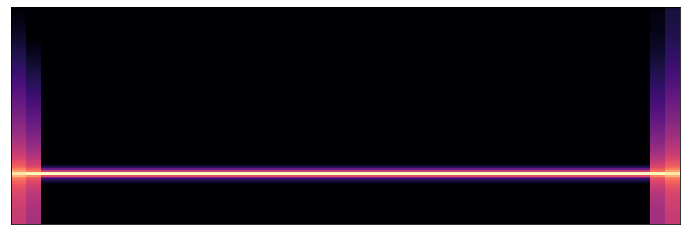

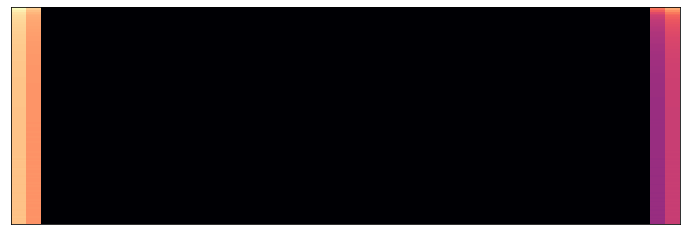

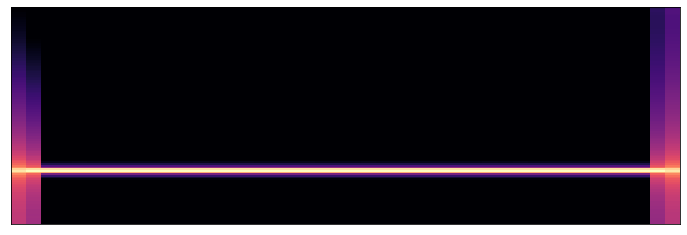

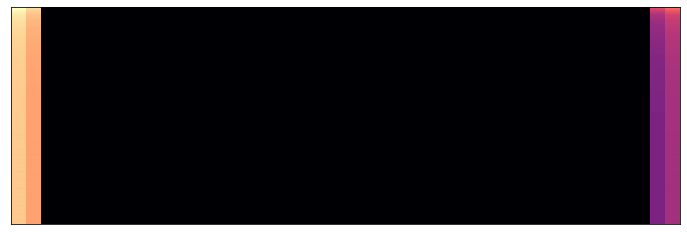

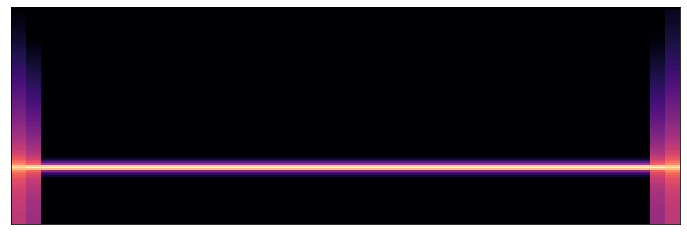

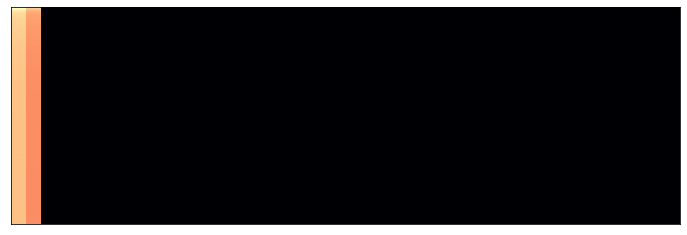

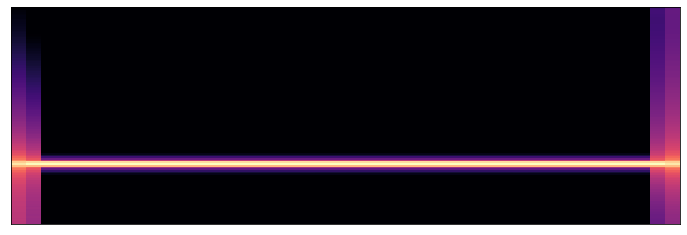

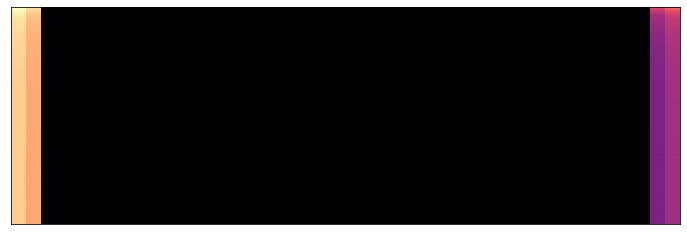

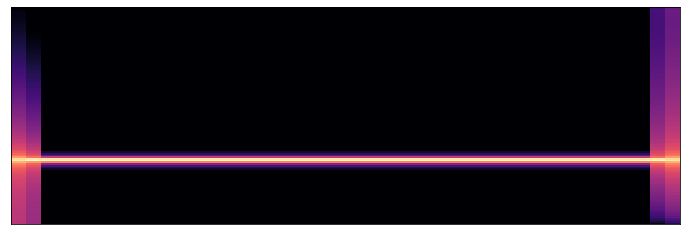

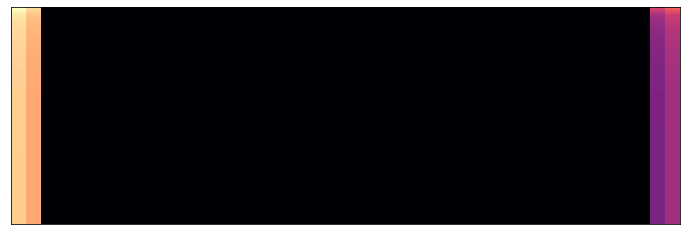

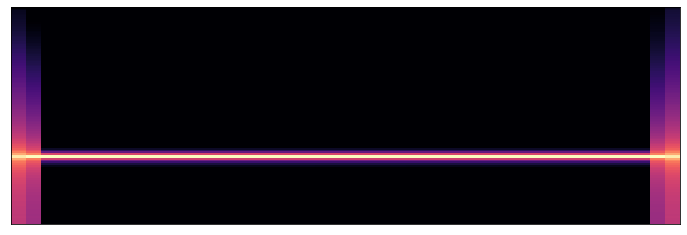

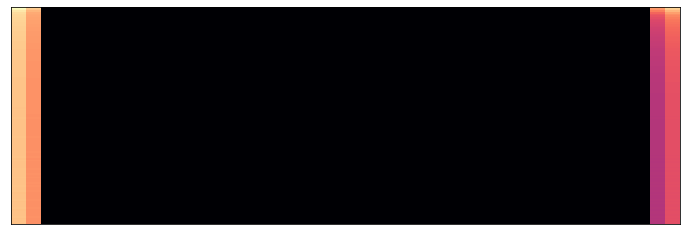

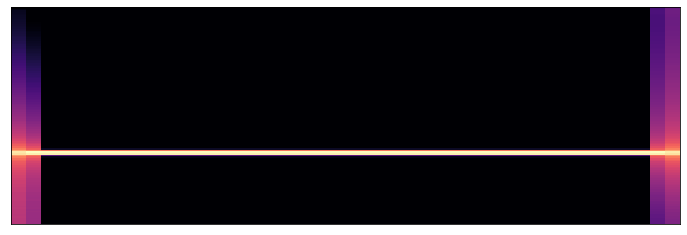

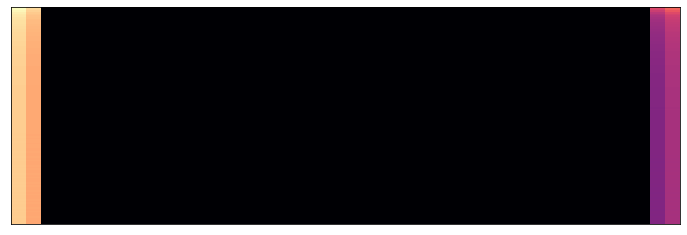

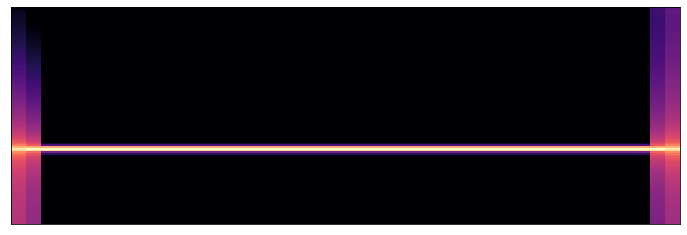

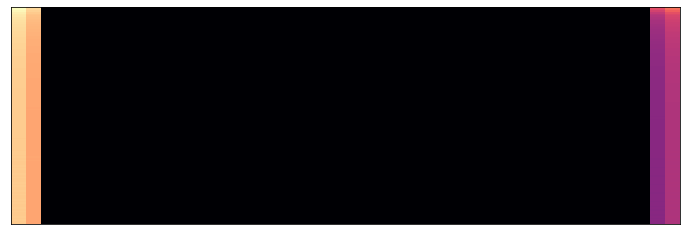

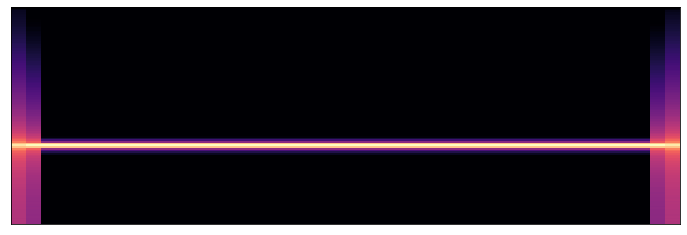

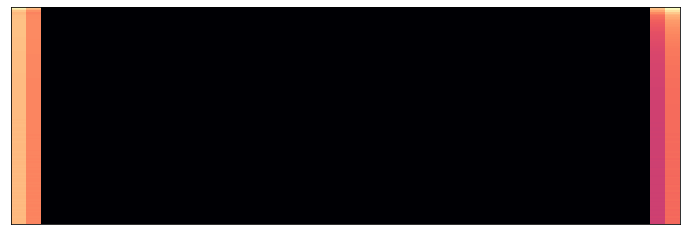

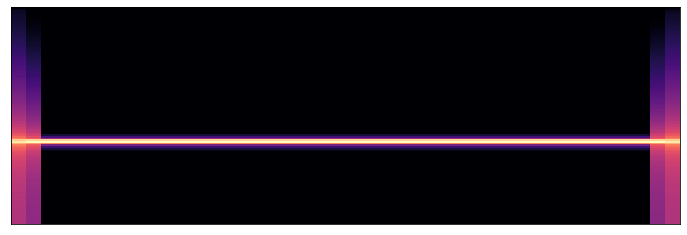

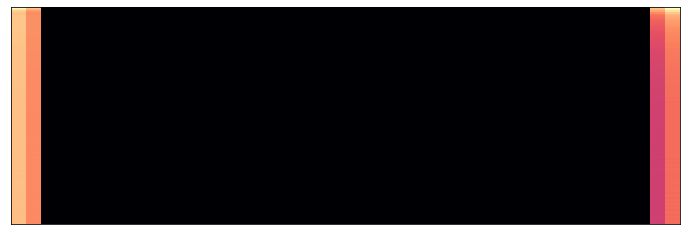

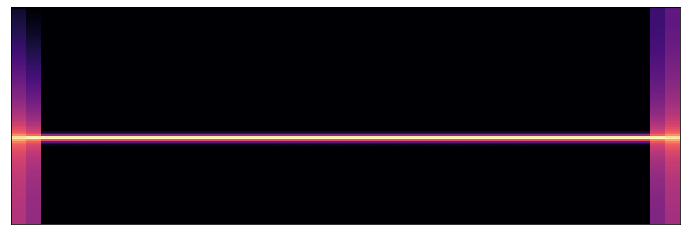

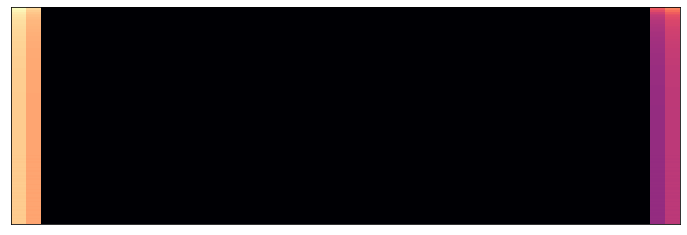

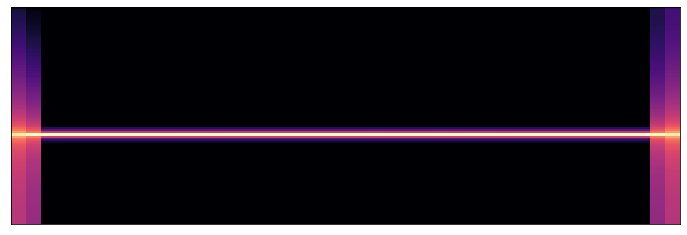

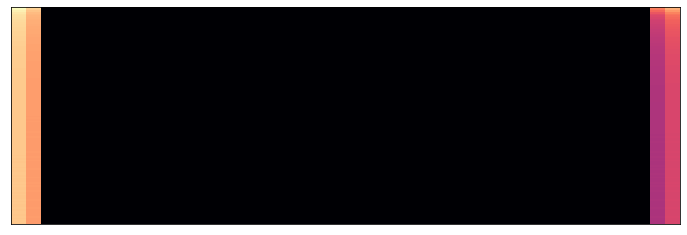

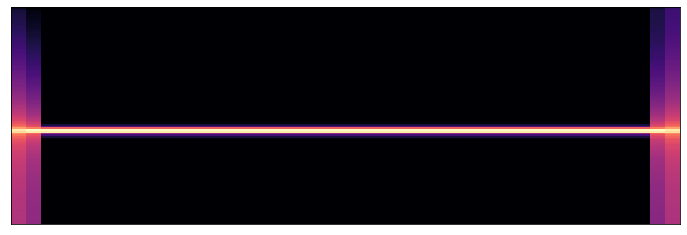

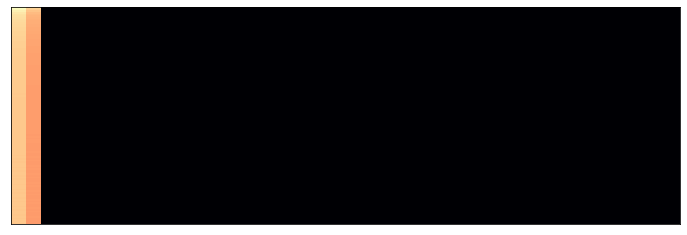

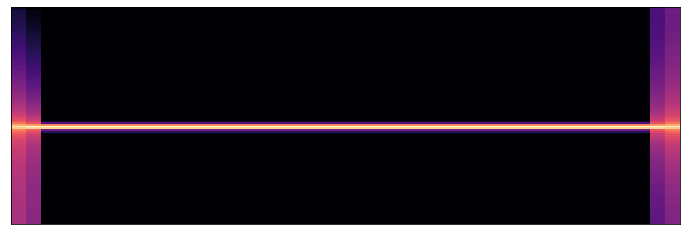

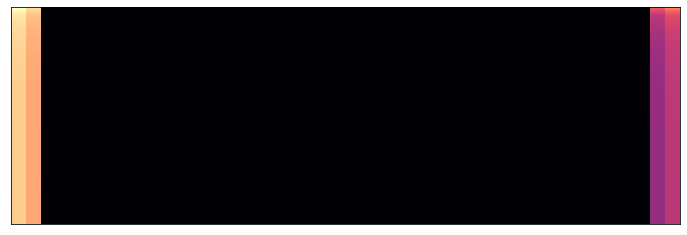

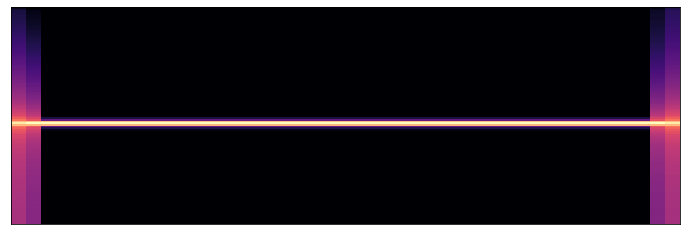

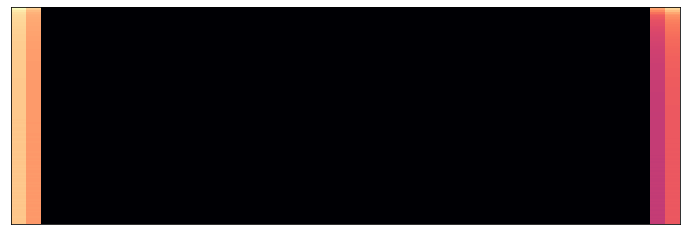

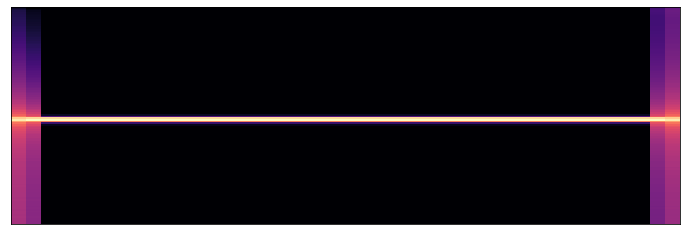

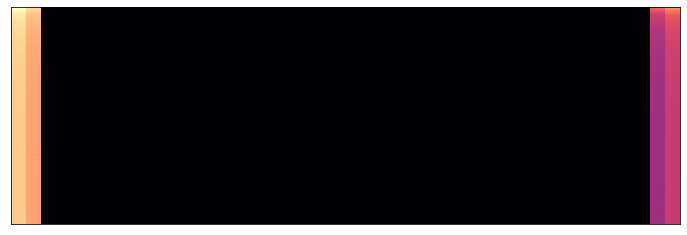

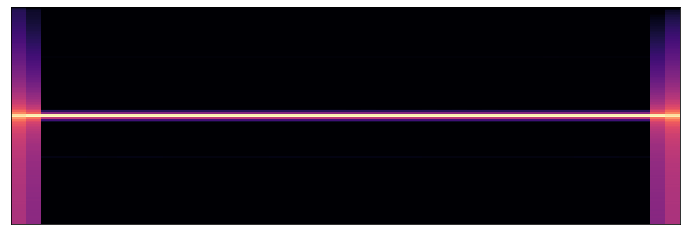

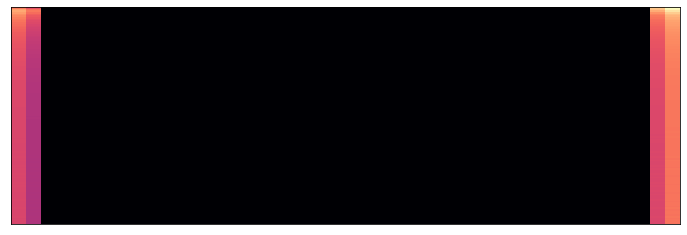

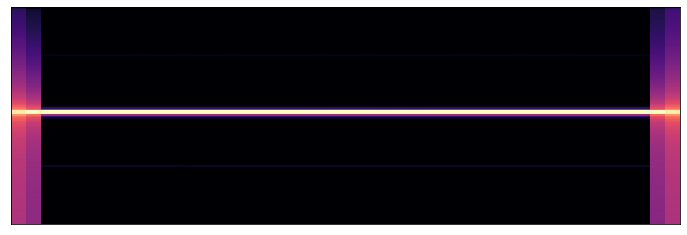

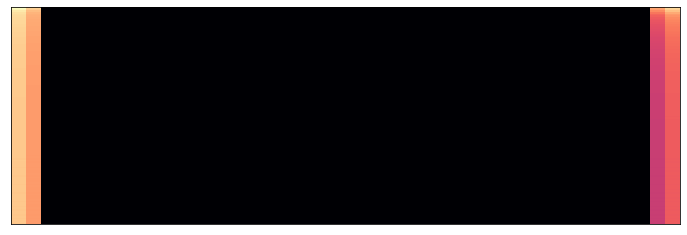

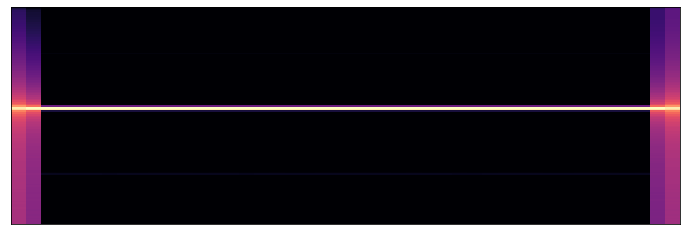

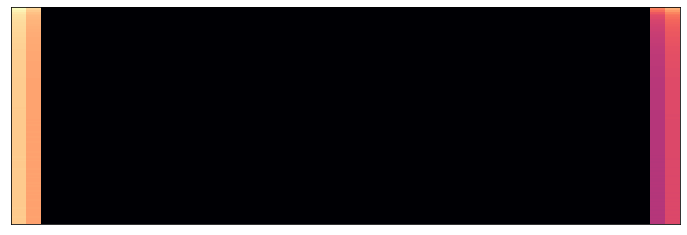

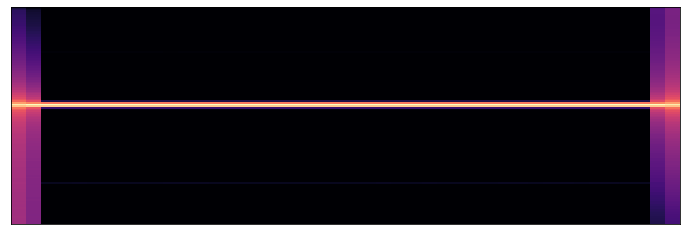

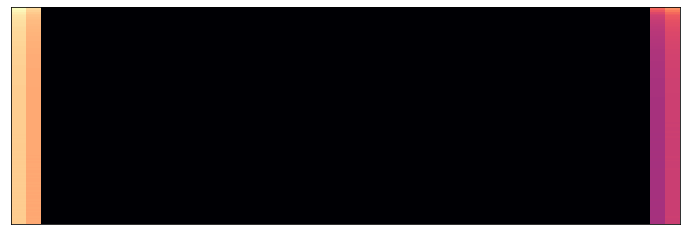

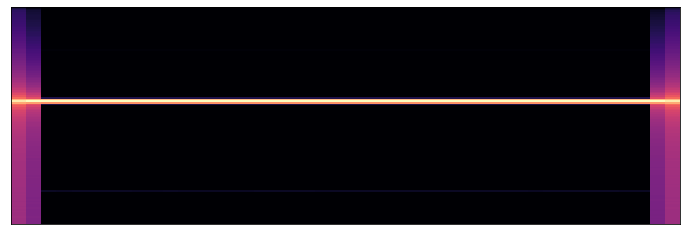

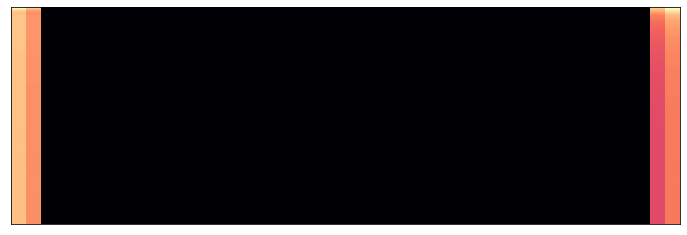

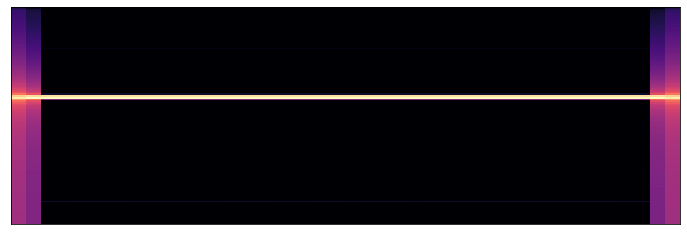

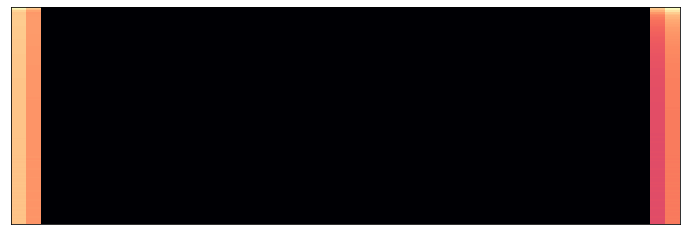

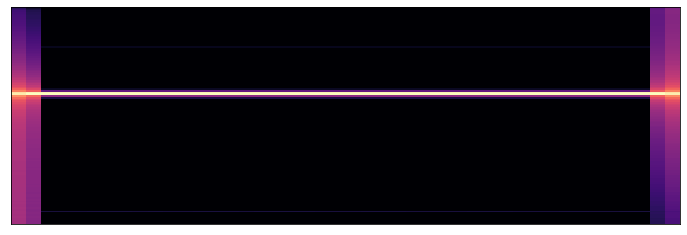

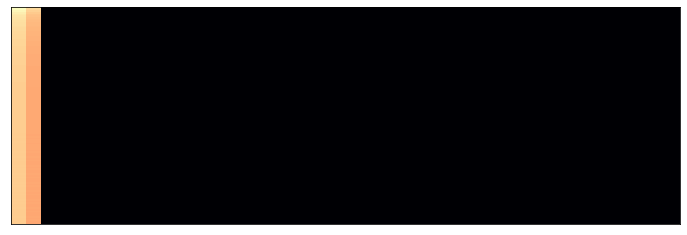

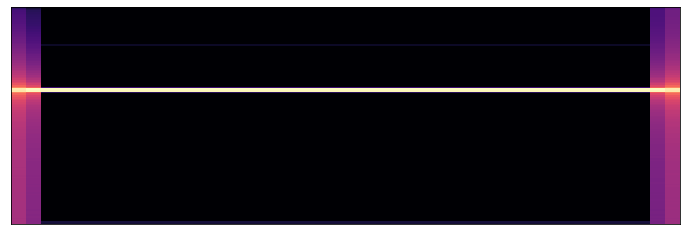

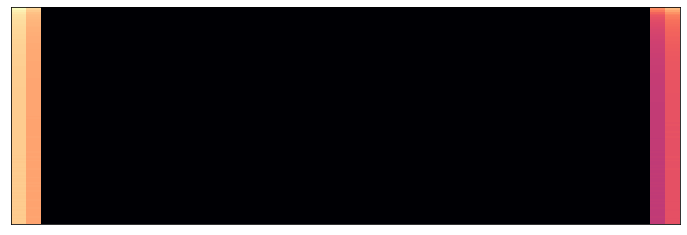

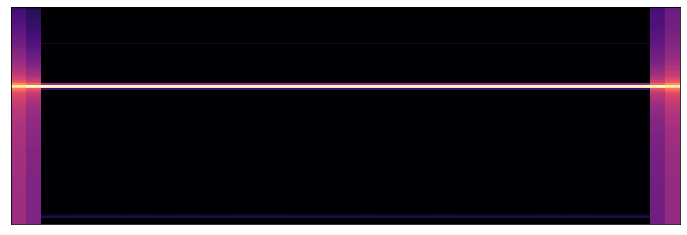

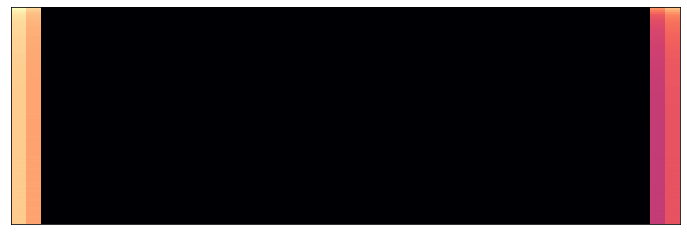

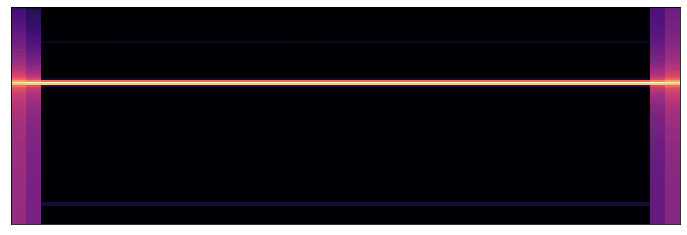

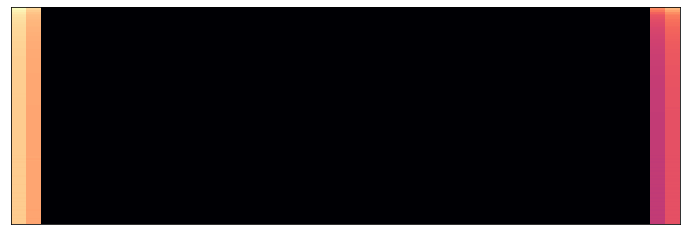

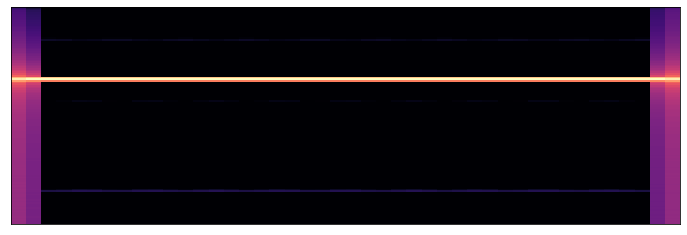

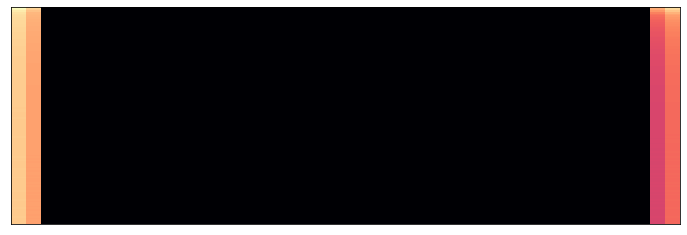

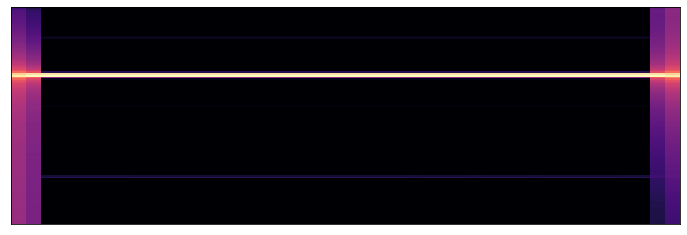

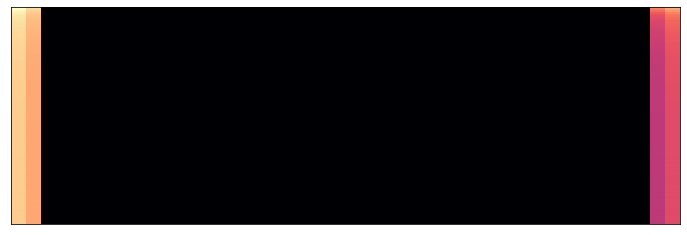

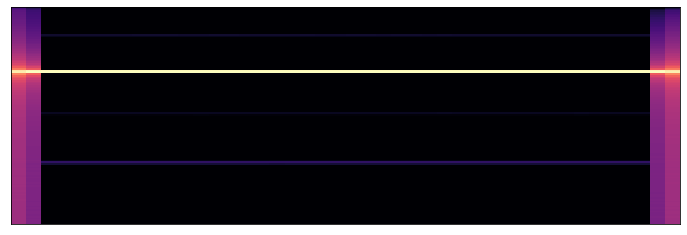

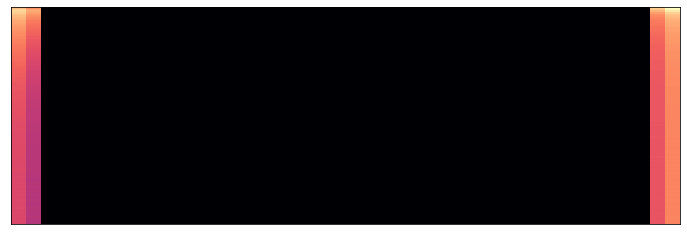

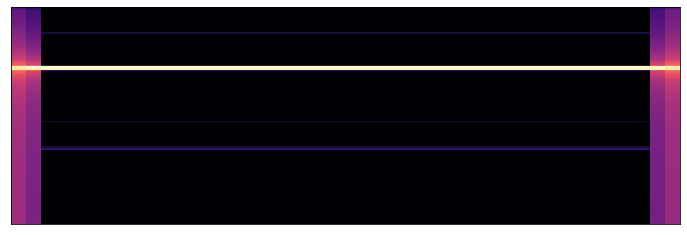

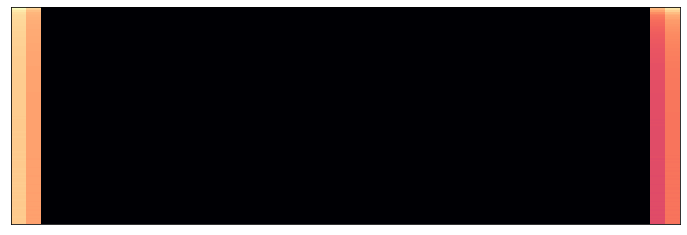

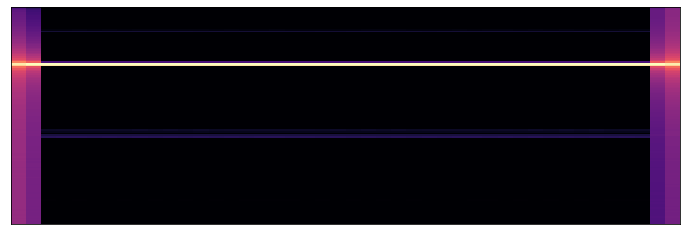

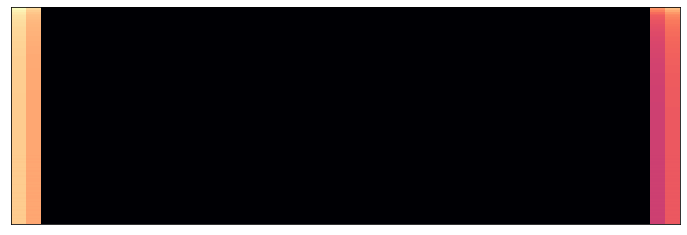

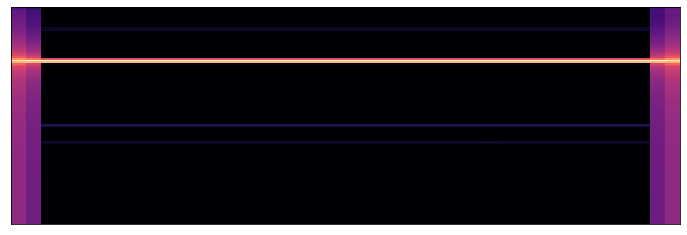

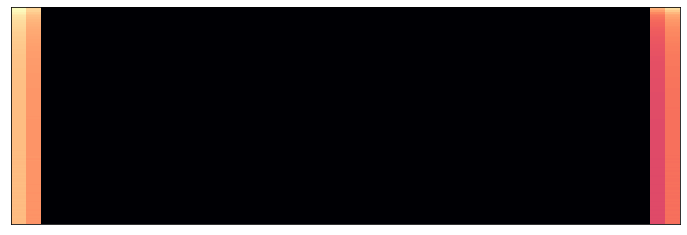

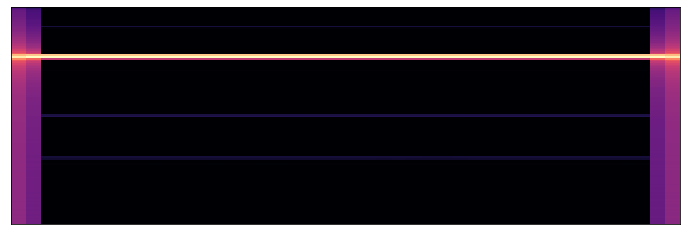

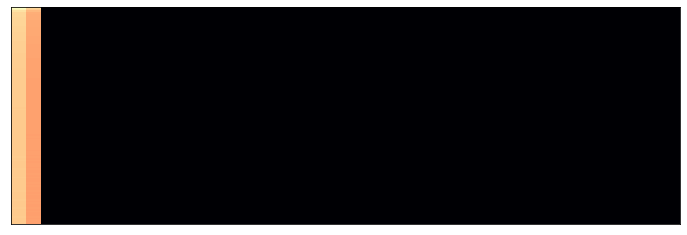

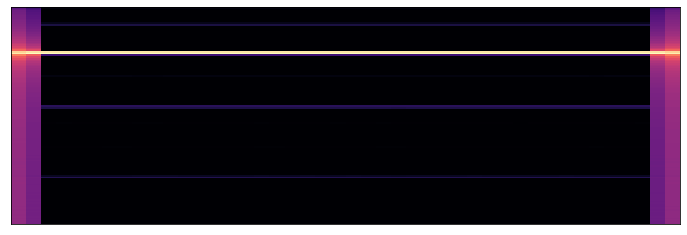

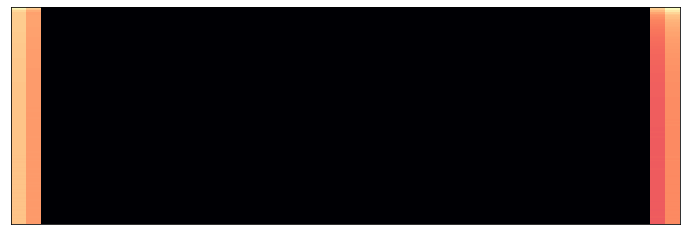

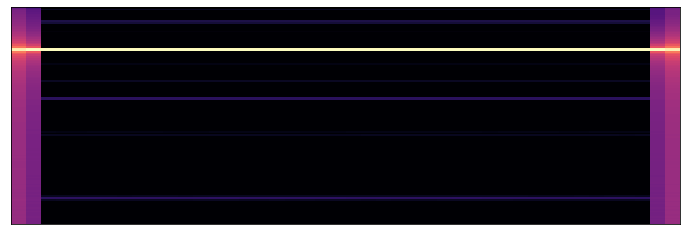

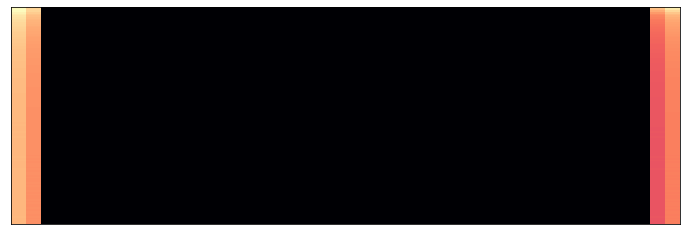

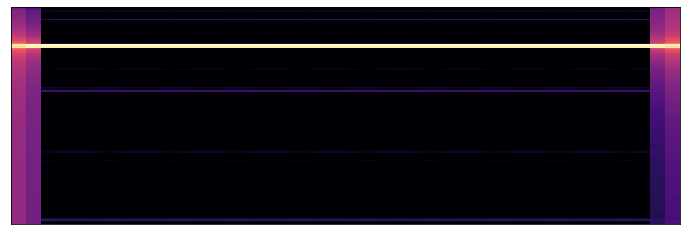

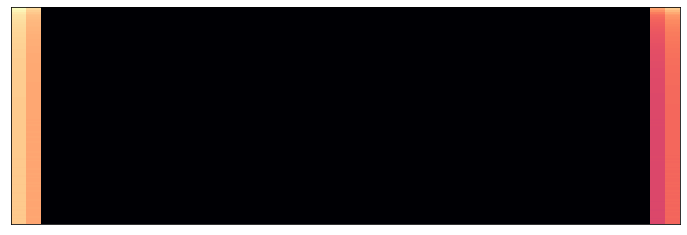

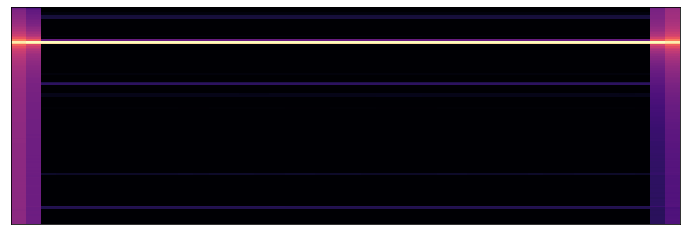

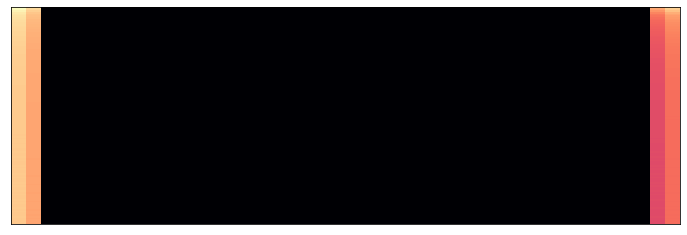

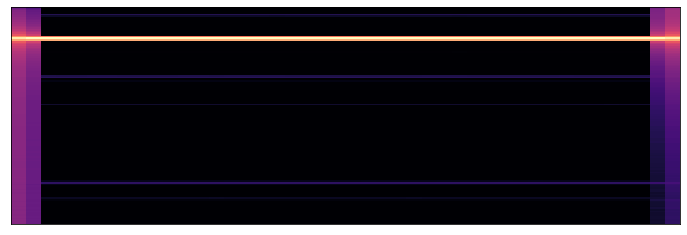

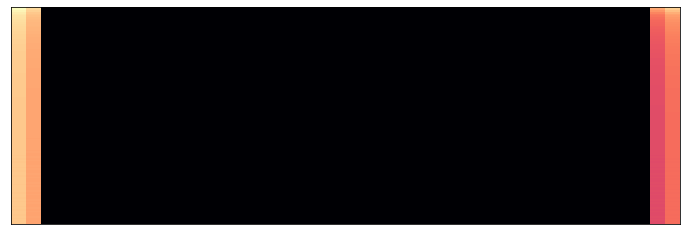

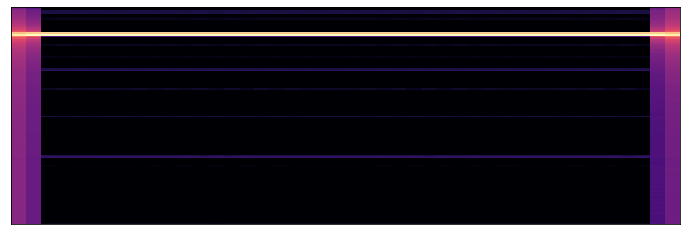

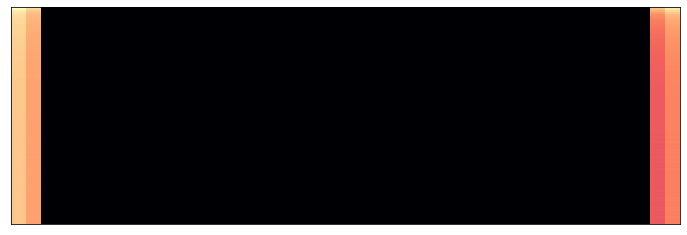

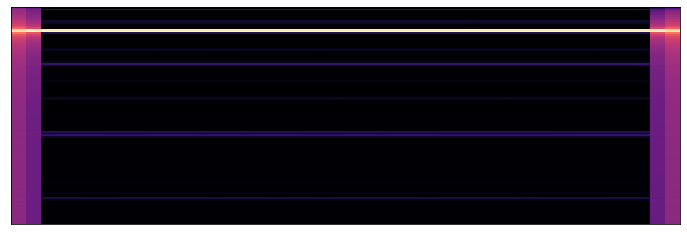

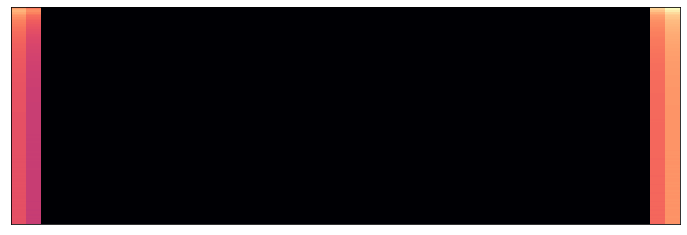

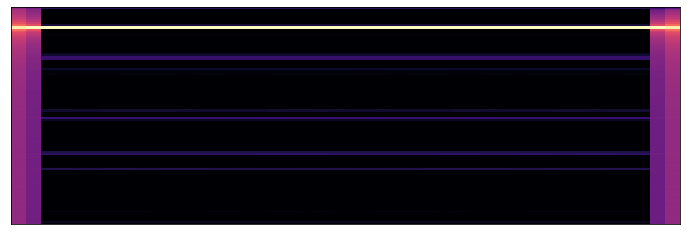

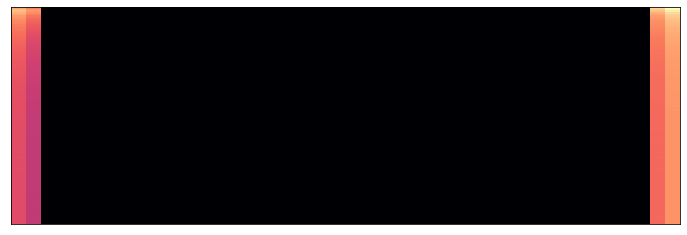

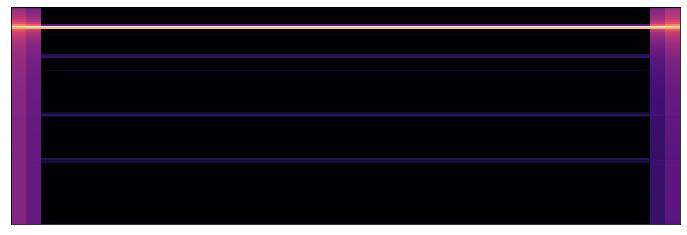

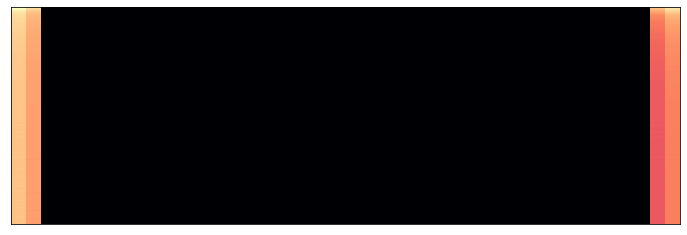

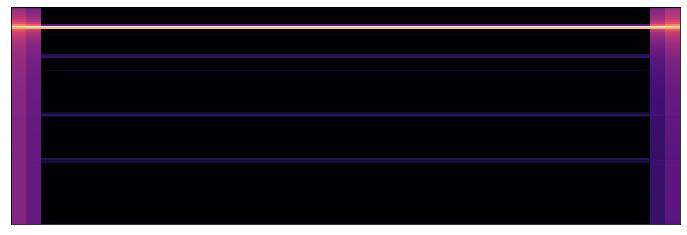

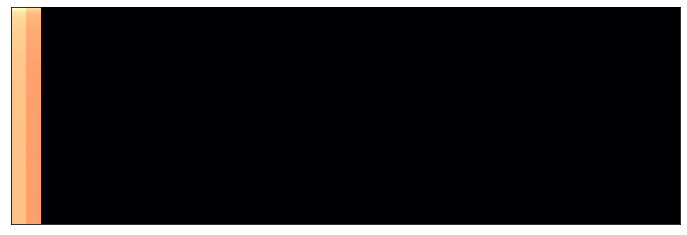

In [ ]:
for j in range(0,11):
    create_dataset(wav_nam[j], "logregdatasetmega"+str(j))

In [ ]:
pickle.dump(logisticRegr, open('logisticRegr.p','wb'))
pretrained_logreg = pickle.load(open('logisticRegr.p', 'rb'))
results = {}
images_and_labels = {}
for j in range(0,11):
    data, images, labels = load_data("logregdatasetmega"+str(j))
    print(pretrained_logreg.predict(data))
    results[j] = pretrained_logreg.score(data, labels)
    print(pretrained_logreg.score(data, labels))

second_0_label_1.png
second_10_label_1.png
second_11_label_0.png
second_12_label_1.png
second_13_label_0.png
second_14_label_1.png
second_15_label_0.png
second_16_label_1.png
second_17_label_0.png
second_18_label_1.png
second_19_label_0.png
second_1_label_0.png
second_2_label_1.png
second_3_label_0.png
second_4_label_1.png
second_5_label_0.png
second_6_label_1.png
second_7_label_0.png
second_8_label_1.png
second_9_label_0.png
[1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0]
[1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0]
1.0
second_0_label_1.png
second_10_label_1.png
second_11_label_0.png
second_12_label_1.png
second_13_label_0.png
second_14_label_1.png
second_15_label_0.png
second_16_label_1.png
second_17_label_0.png
second_18_label_1.png
second_19_label_0.png
second_1_label_0.png
second_2_label_1.png
second_3_label_0.png
second_4_label_1.png
second_5_label_0.png
second_6_label_1.png
second_7_label_0.png
second_8_label_1.png
second_9_label_0.png
[1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0]
[1 1 0 1 0

As we can see Logistic Regression works beautifully on this!

In [ ]:
print(results)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}


## Basic Support Vector Machine Classifier
Even though this method was not covered in class so far, when we looked into research articles concerning our topic this was the most simple implementation short of a Convolutional Neural Net or an Artifical Neural Net. By no means is this an end all be all model as accuracy remains very low over the large span of notes. 
We now create a dataset for our notes. While this has no impact on Logistic Regression we did attempt to input to a Support Vector Machine, for which this database will function.

In [ ]:
def create_dataset_notes(audio_path, dataset_name="notesdataset"):
    
    y, sr = librosa.load(audio_path)
    
    labels = audio_path.split("_")

    #use sr (sampling rate) to split data in seconds
    if not os.path.exists(dataset_name):
        os.makedirs(dataset_name)

    initial = 0
    final = sr
    for i in range(math.ceil(len(y)/sr)):
        # Let's make and display a mel-scaled power (energy-squared) spectrogram
        S = librosa.feature.melspectrogram(y=y[initial:final], sr=sr, n_mels=128)

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)

        # Make a new figure
        plt.figure(figsize=(12,4))


        # Display the spectrogram on a mel scale
        # sample rate and hop length parameters are used to render the time axis
        librosa.display.specshow(log_S, sr=sr)    

        #create dataset with 0 for silence and 1 for sound
        if i % 2 == 0:
            plt.savefig(dataset_name + "/second_"+str(int(i))+"_label_" + labels[int(i/2)] + ".png")
        else:
            # we only want the notes in this case
            print("silence")
            #plt.savefig(dataset_name + "/second_"+str(i)+"_label_0.png")
        initial += sr
        final += sr
    

silence
silence
silence
silence
silence
silence
silence
silence
silence
silence


C:\Users\gja17002\AppData\Local\Temp/ipykernel_18768/4079669513.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,4))


silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence
silence


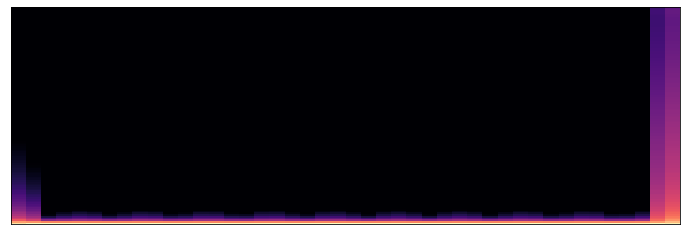

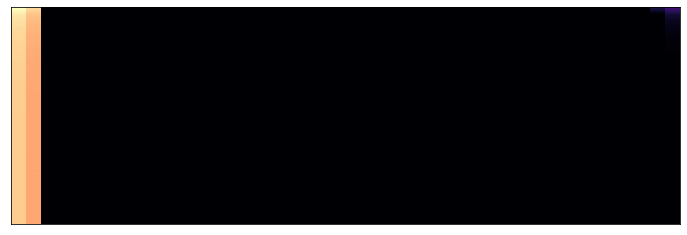

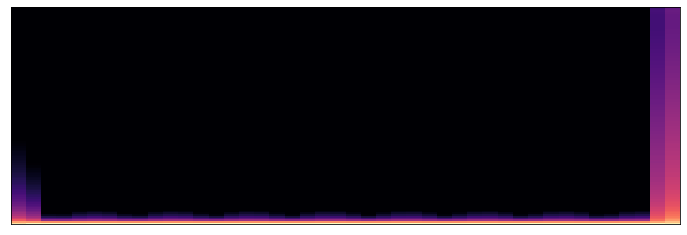

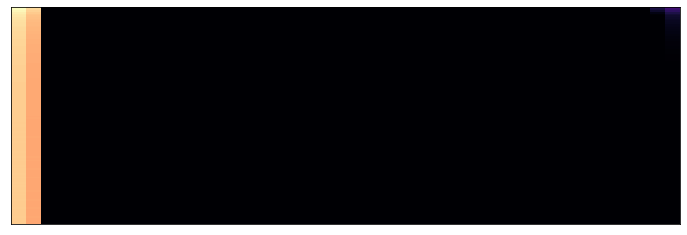

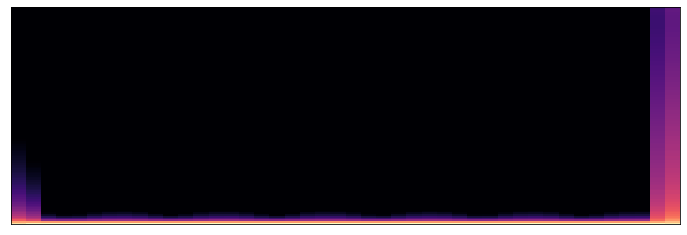

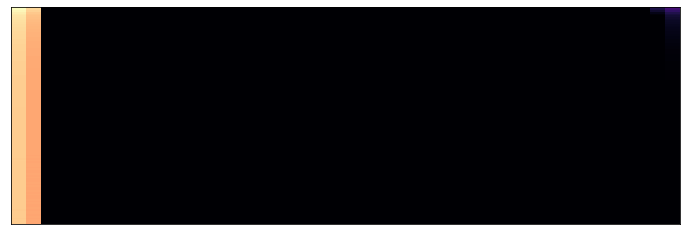

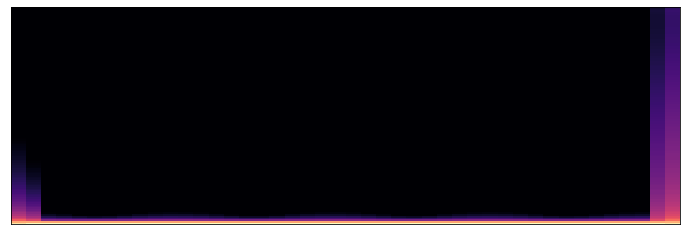

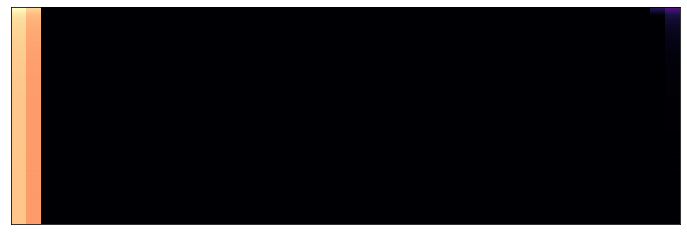

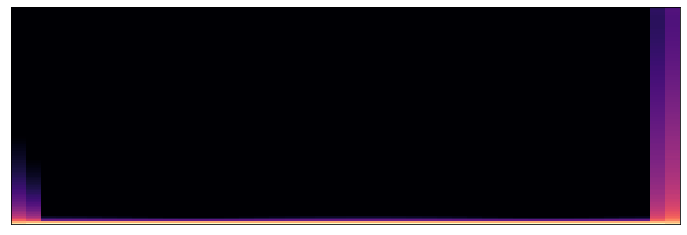

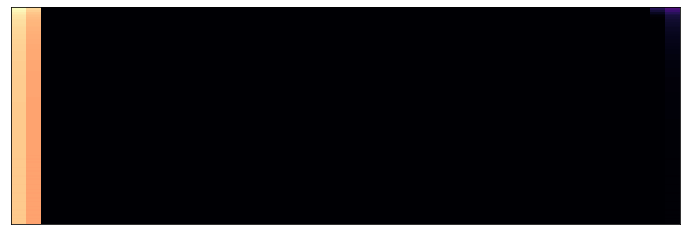

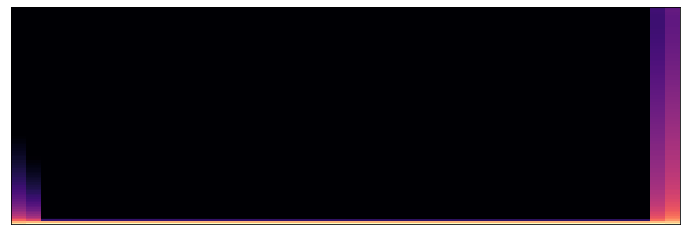

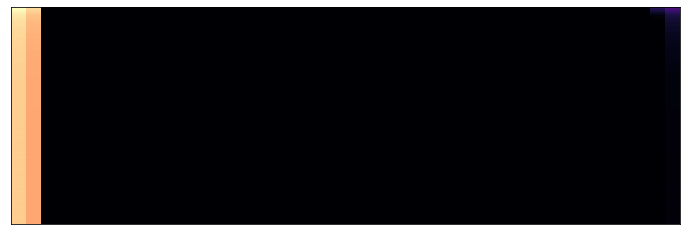

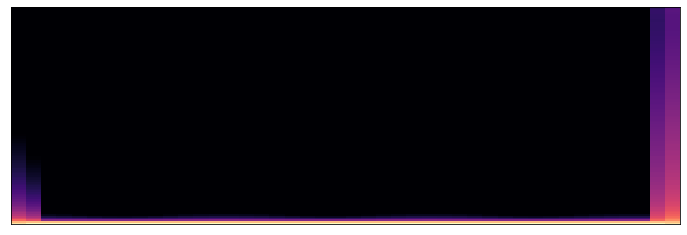

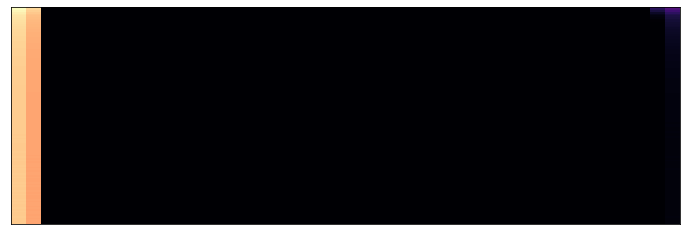

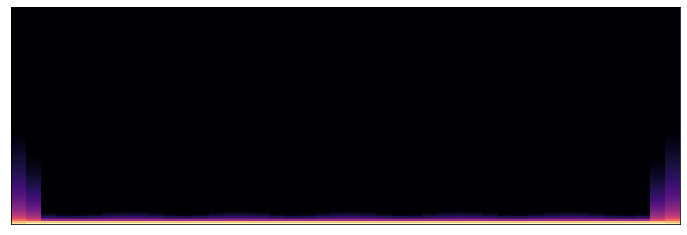

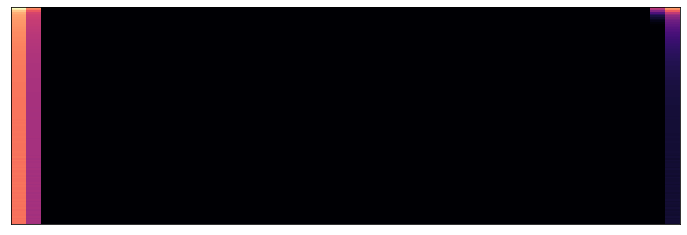

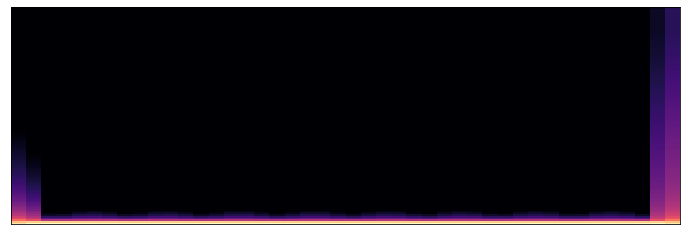

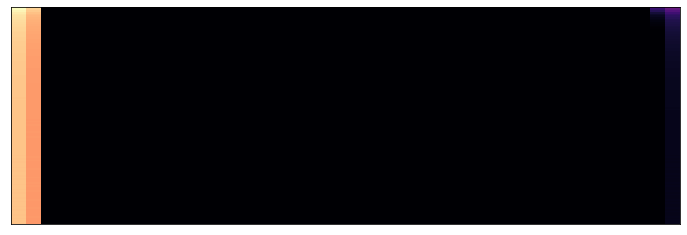

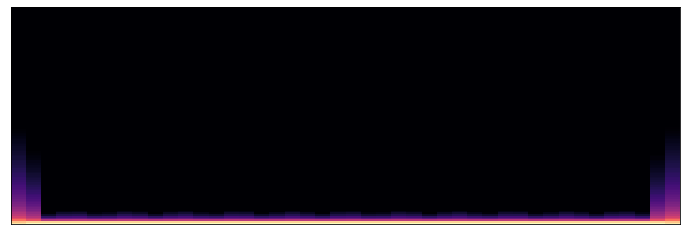

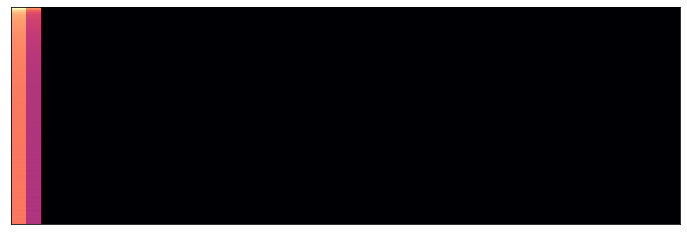

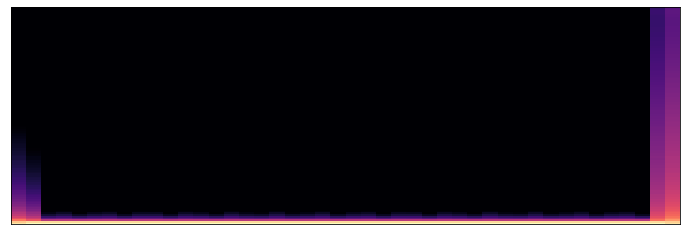

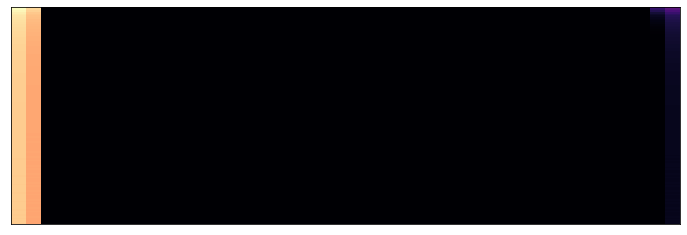

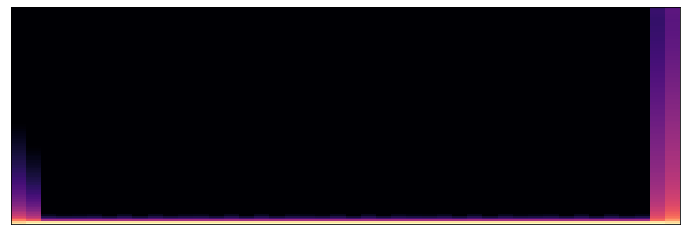

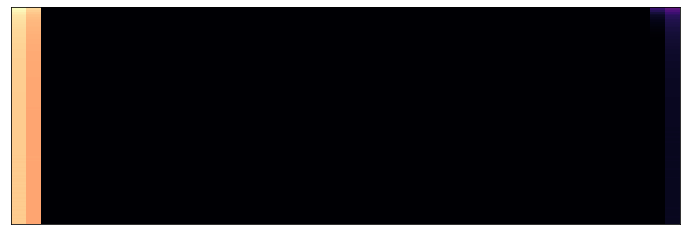

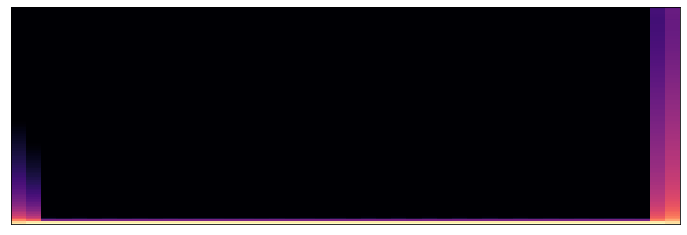

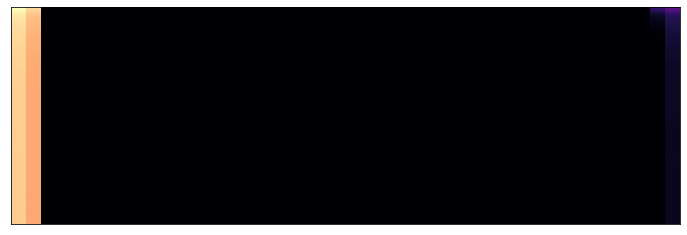

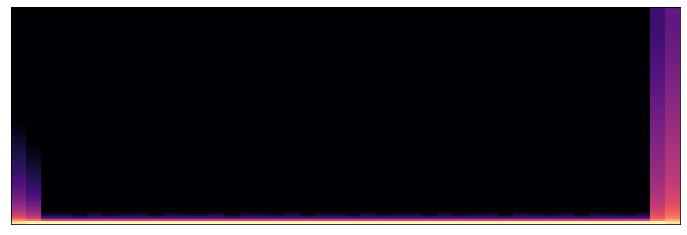

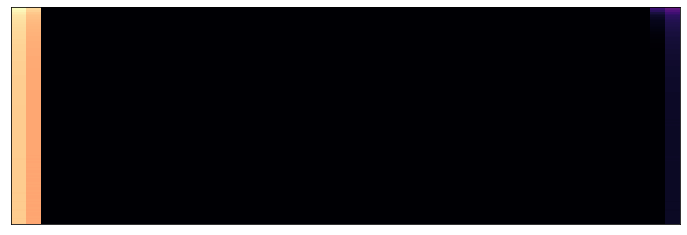

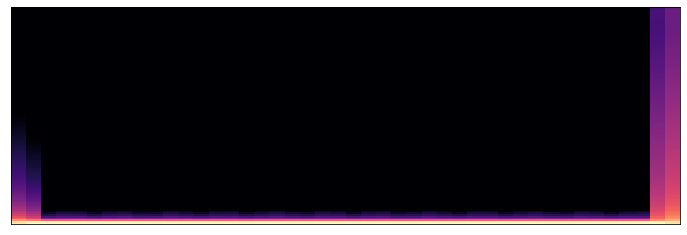

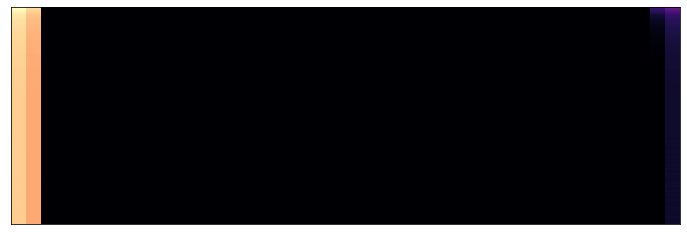

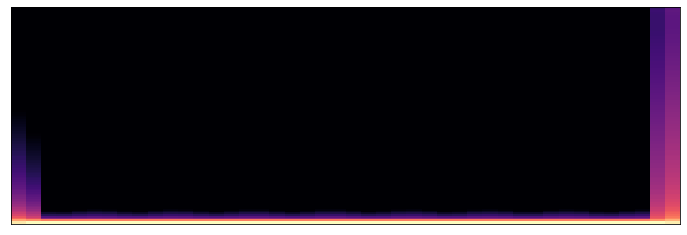

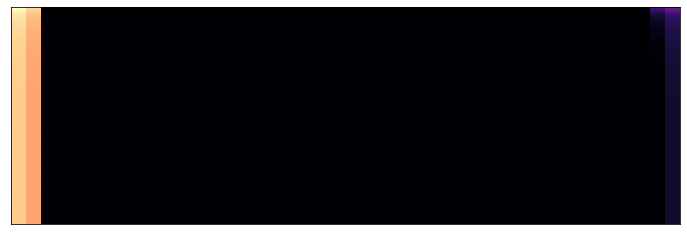

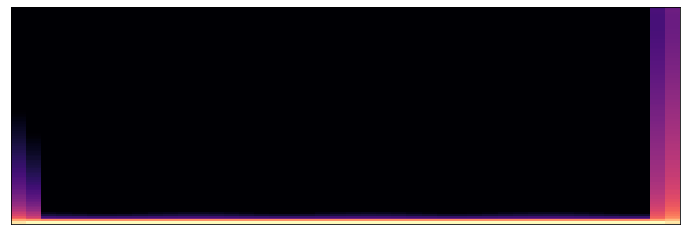

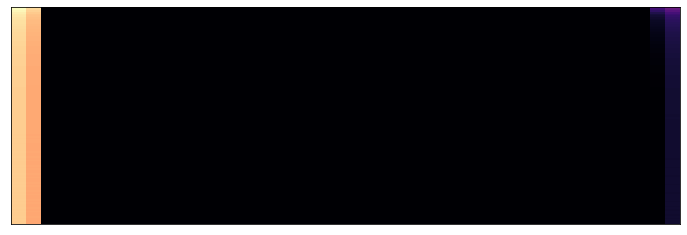

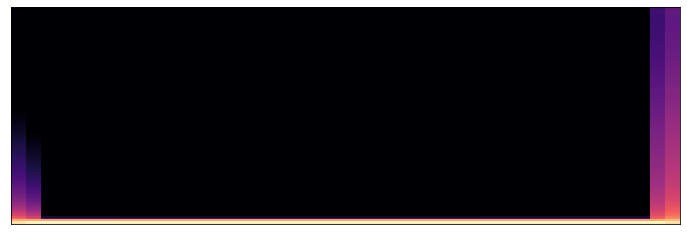

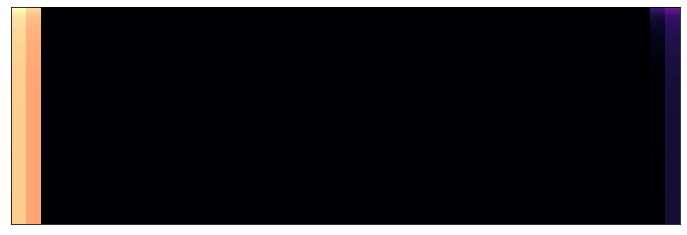

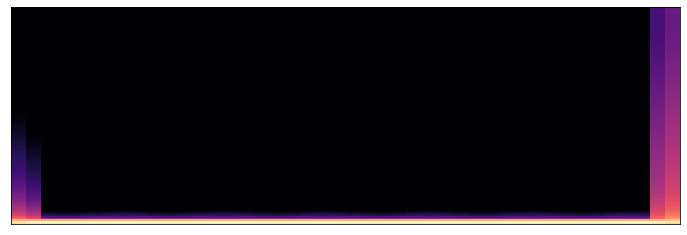

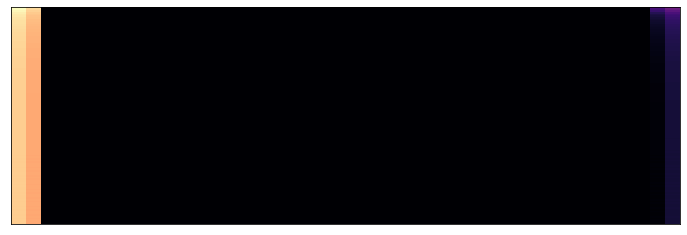

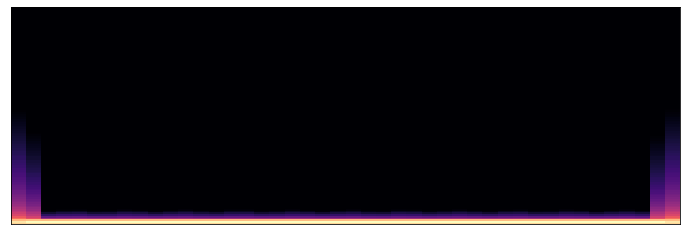

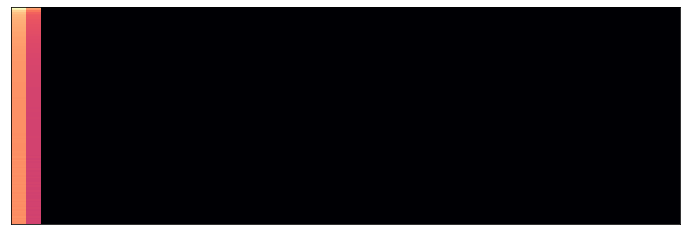

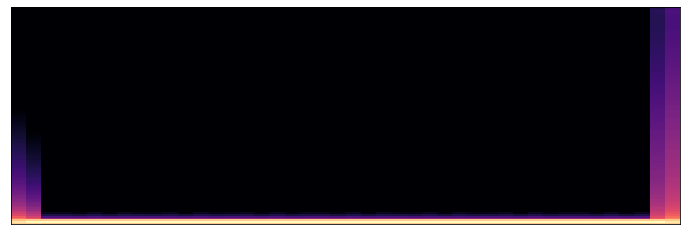

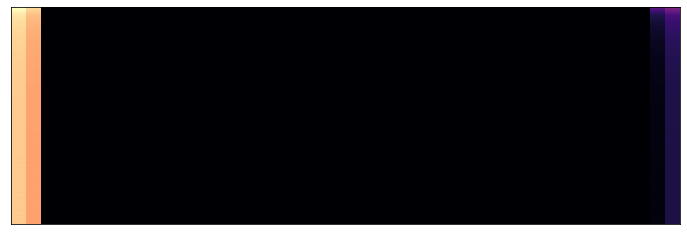

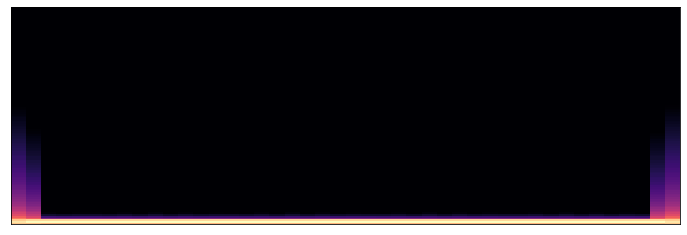

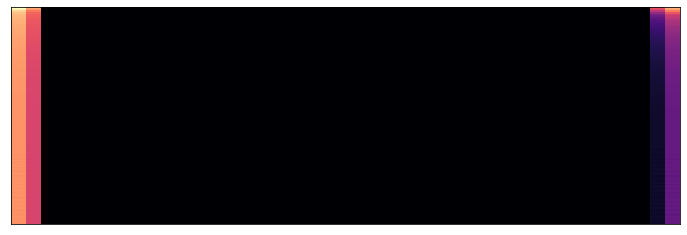

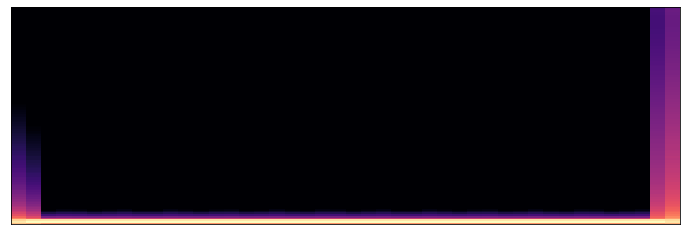

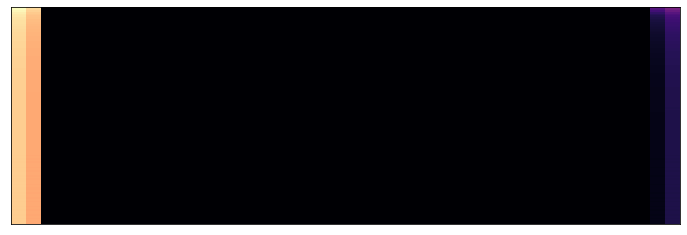

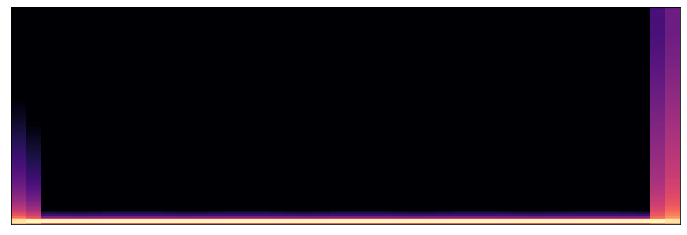

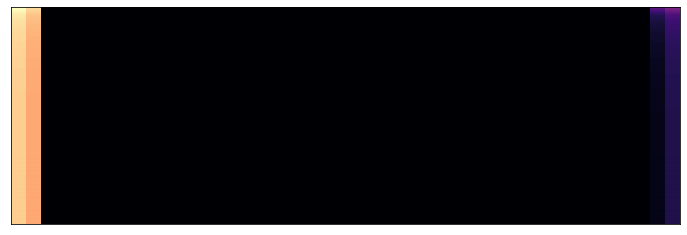

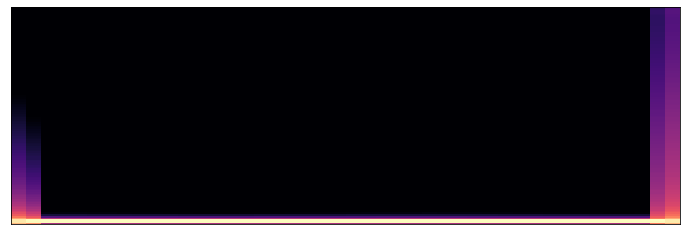

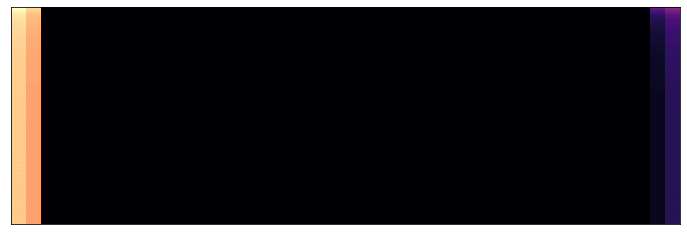

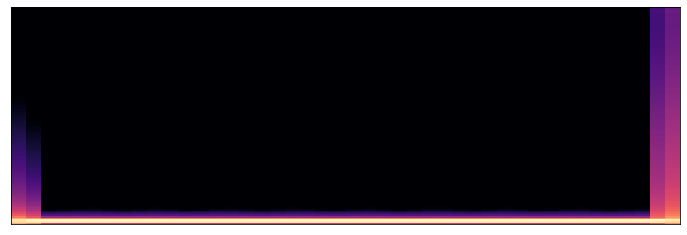

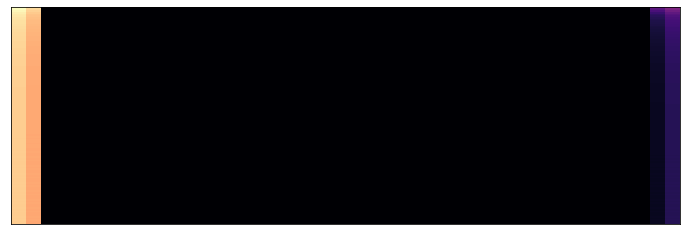

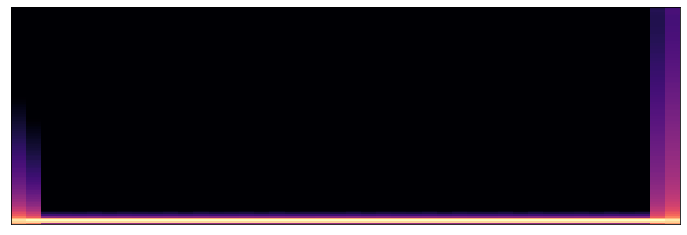

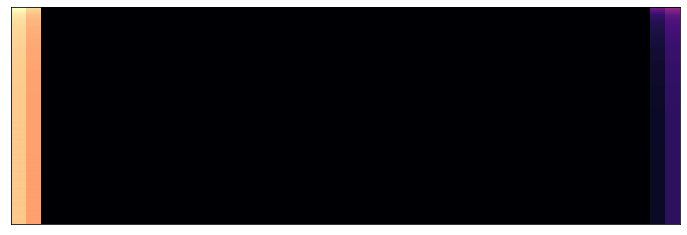

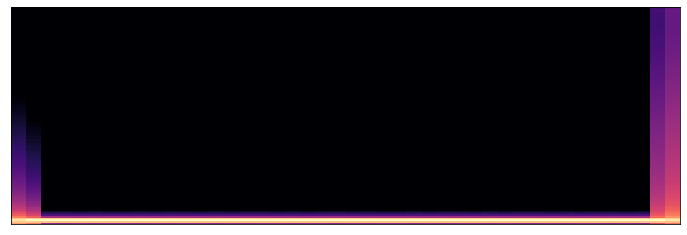

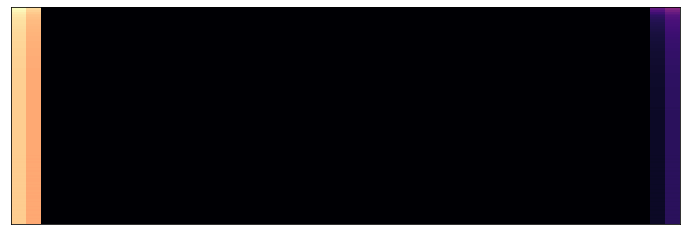

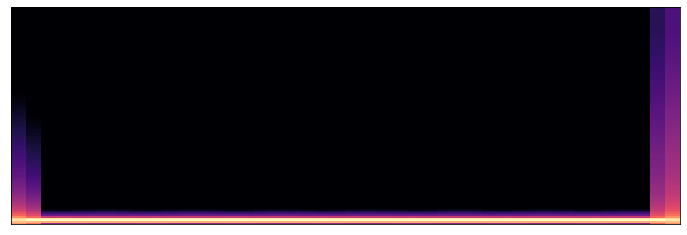

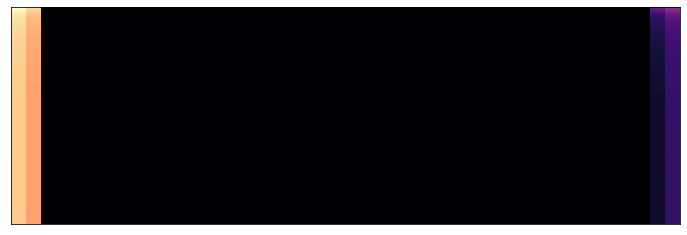

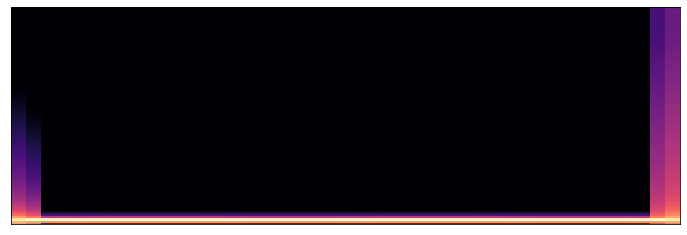

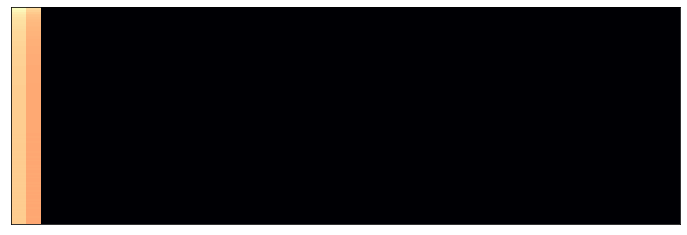

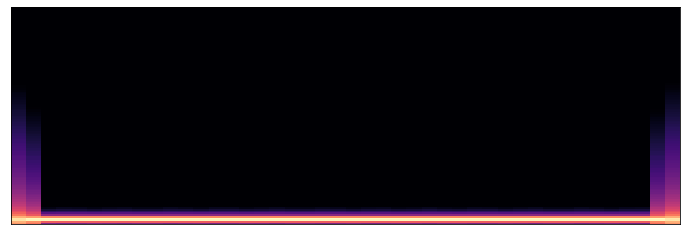

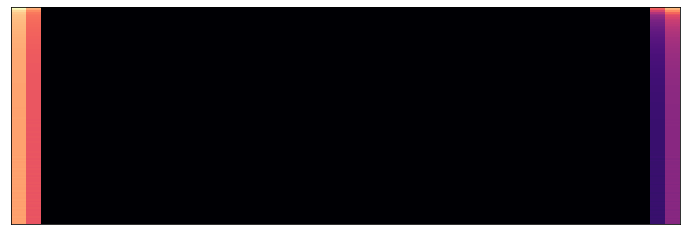

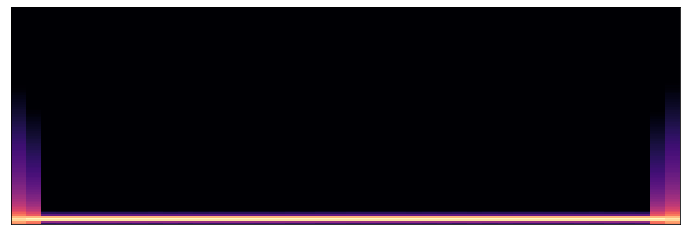

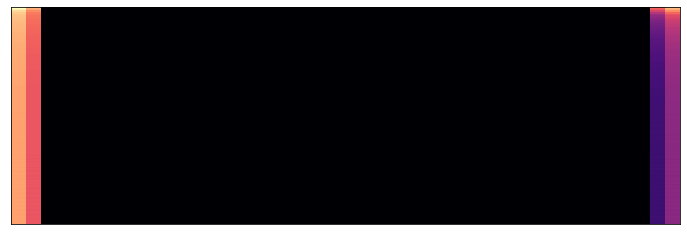

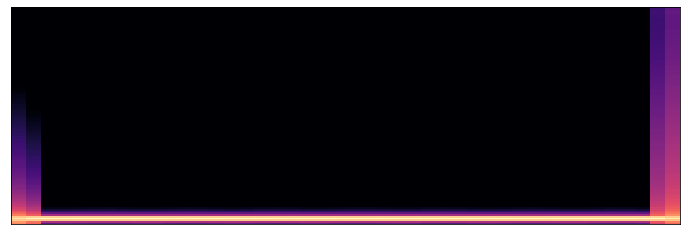

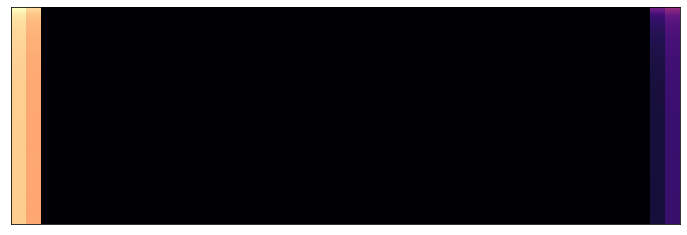

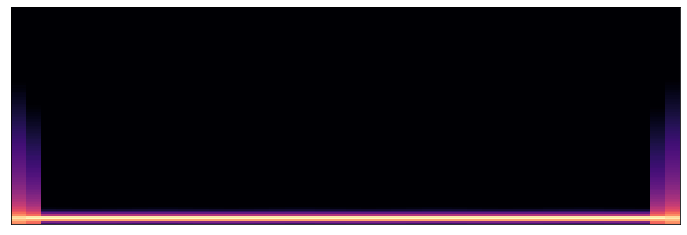

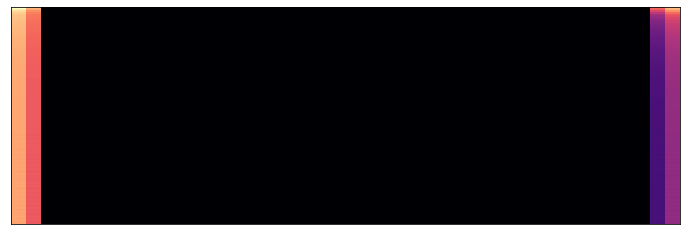

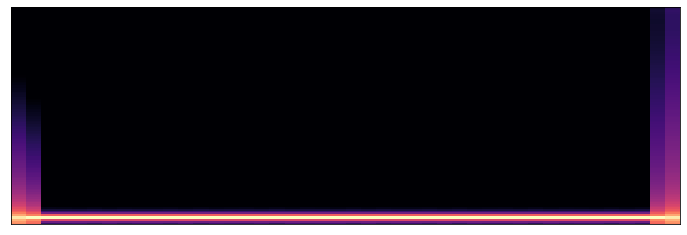

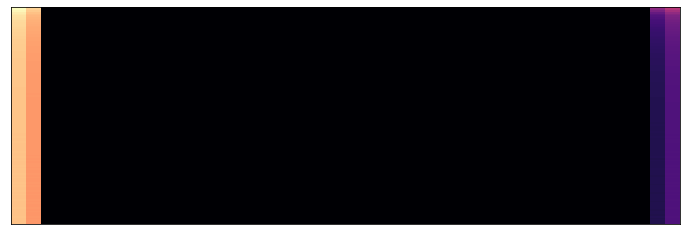

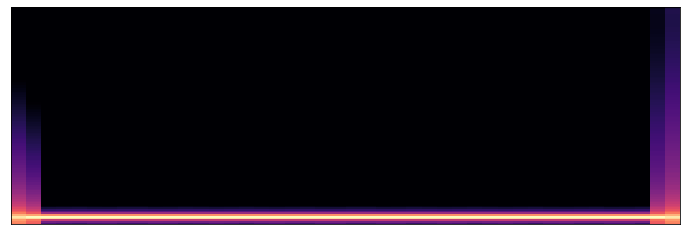

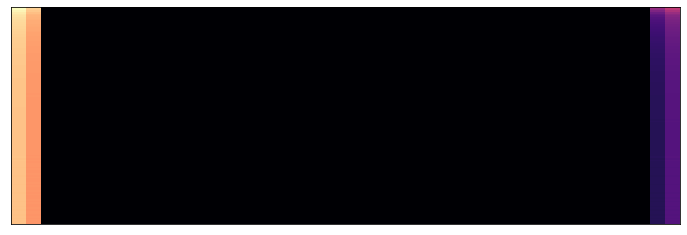

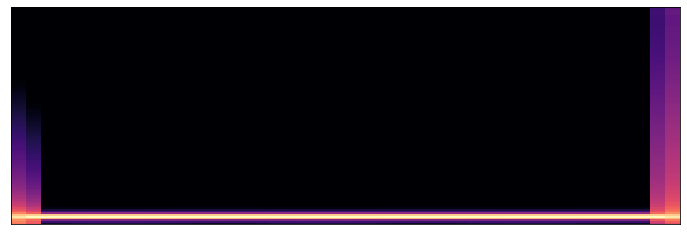

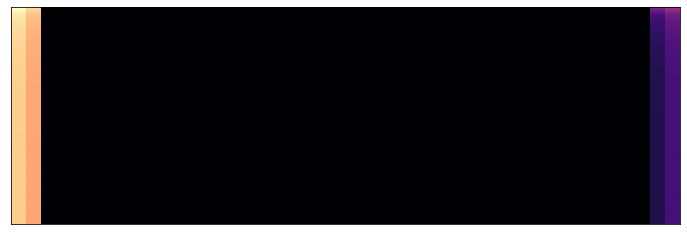

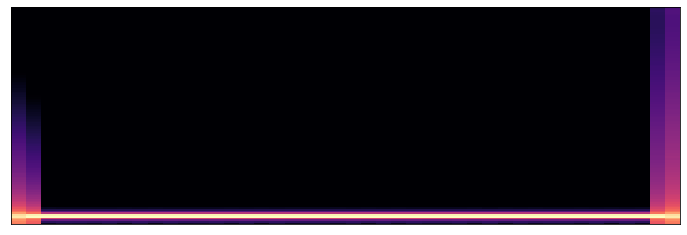

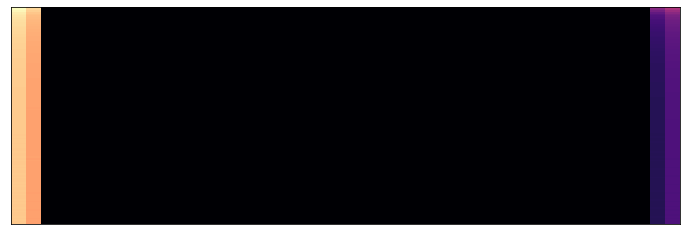

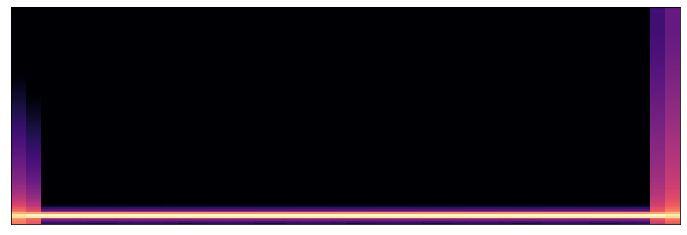

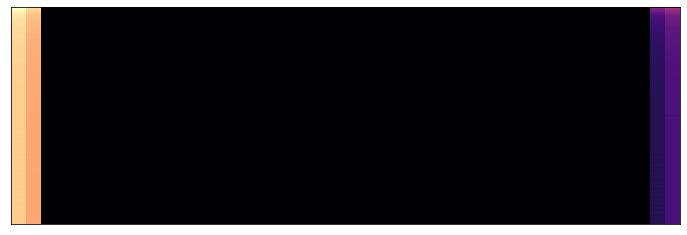

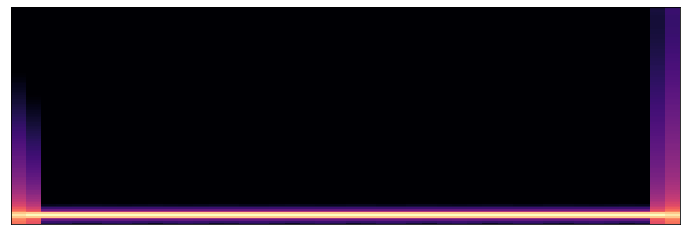

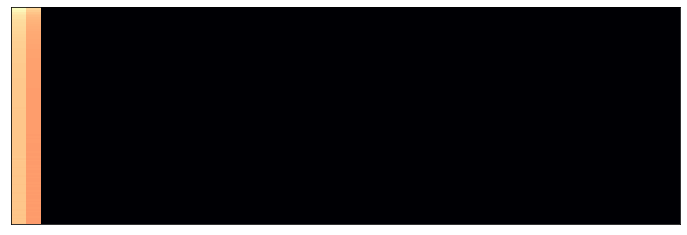

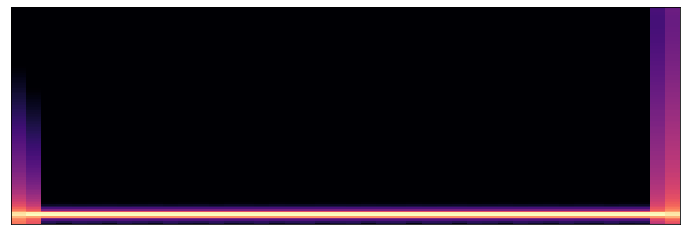

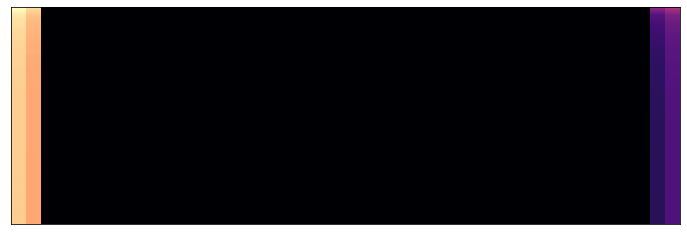

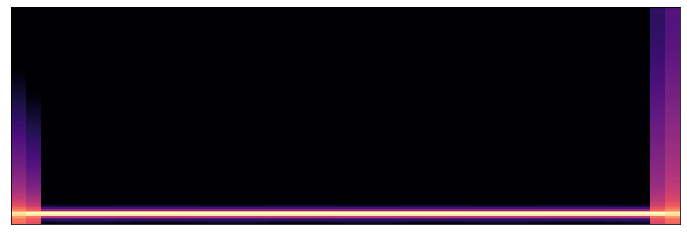

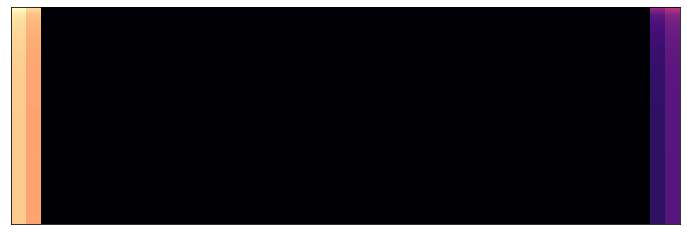

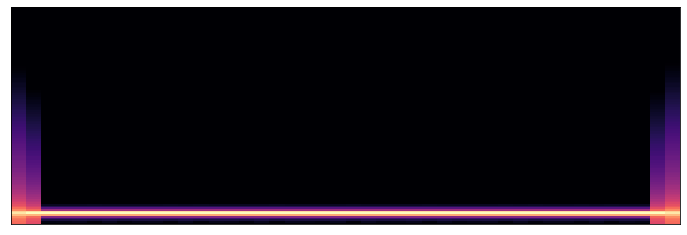

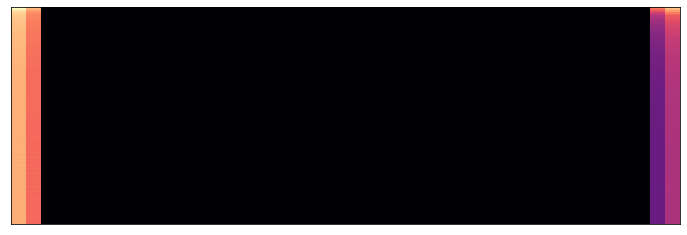

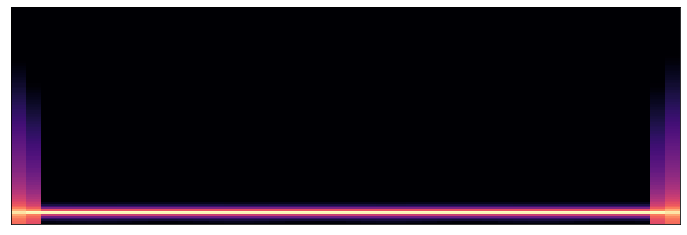

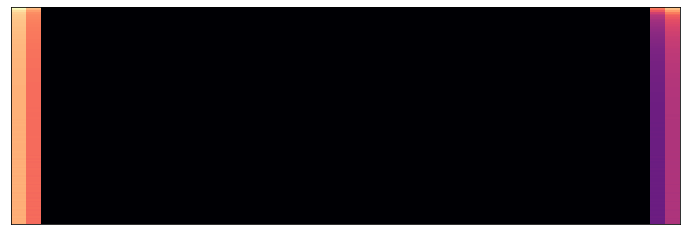

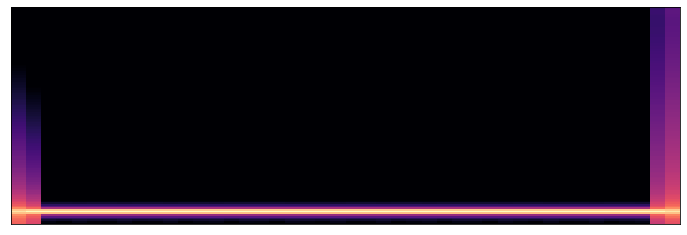

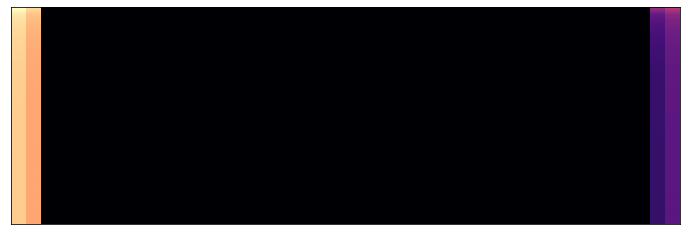

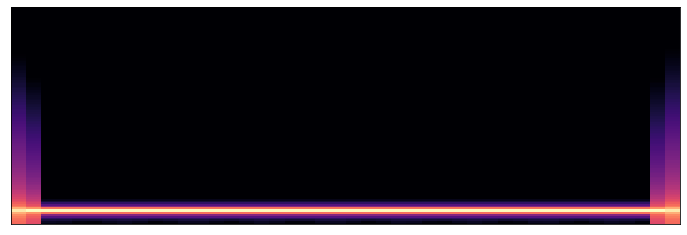

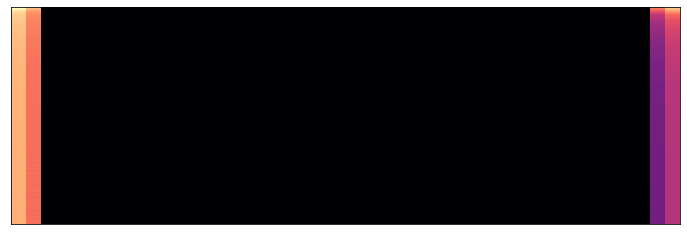

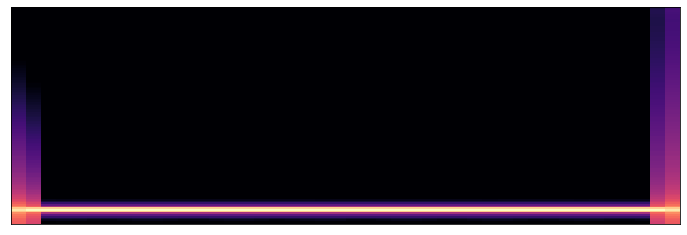

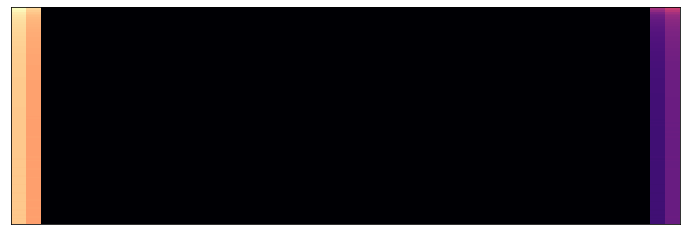

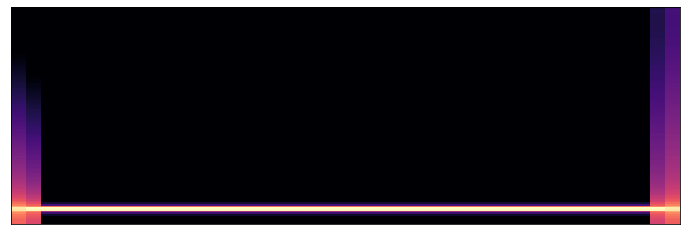

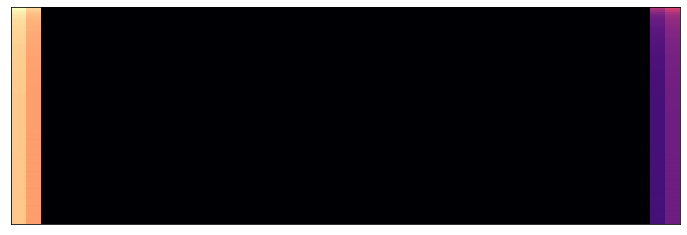

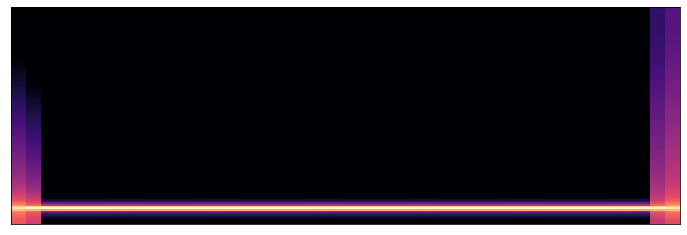

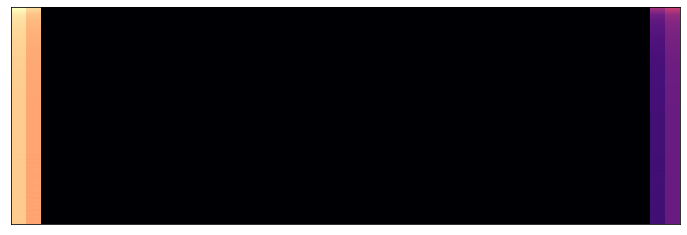

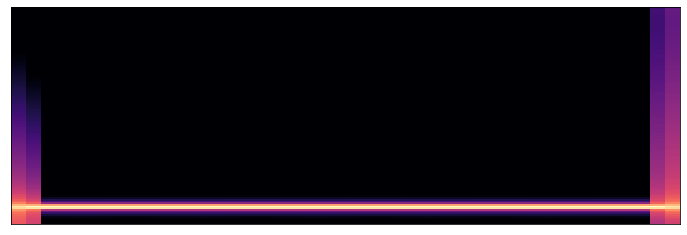

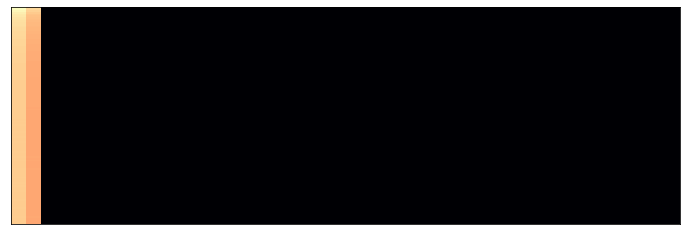

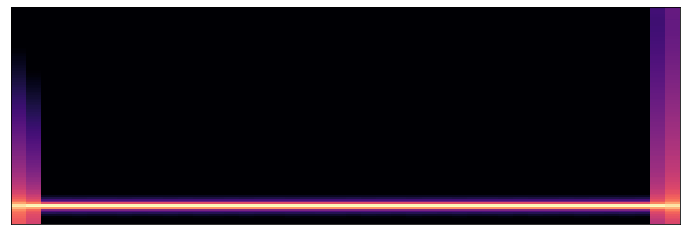

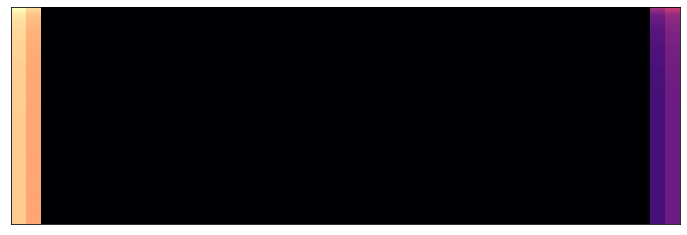

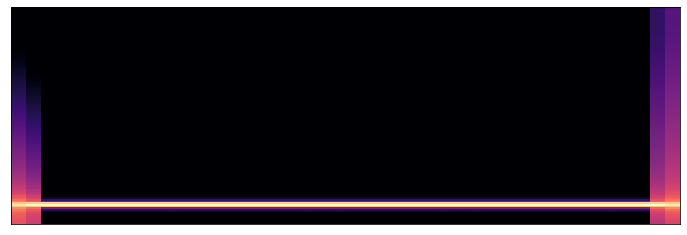

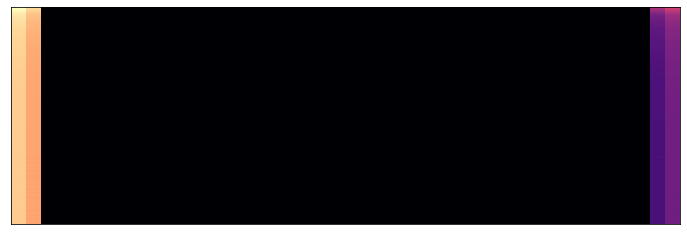

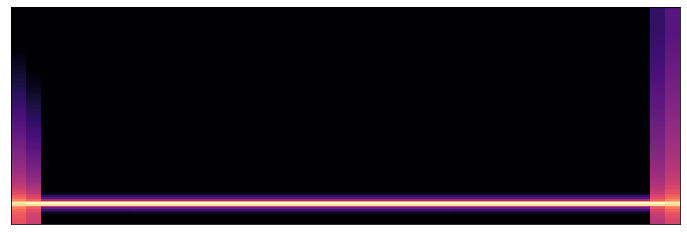

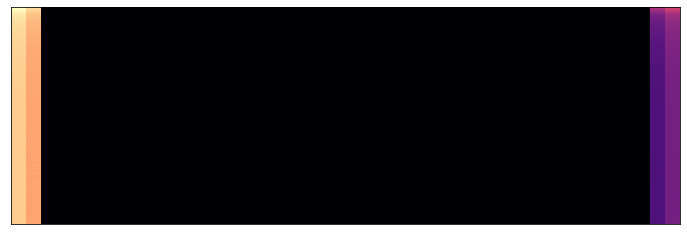

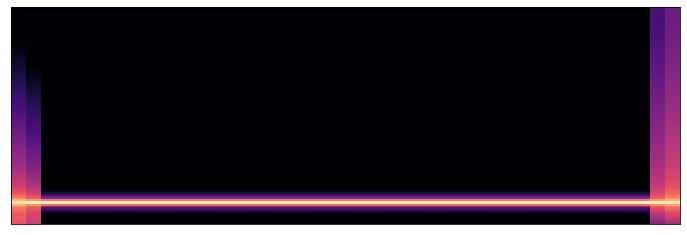

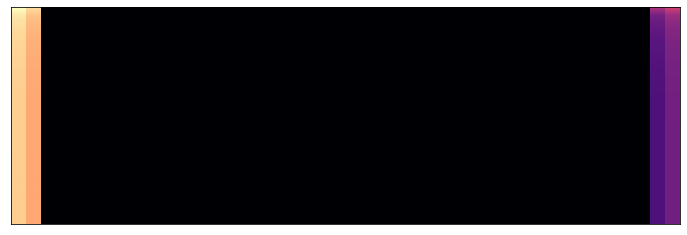

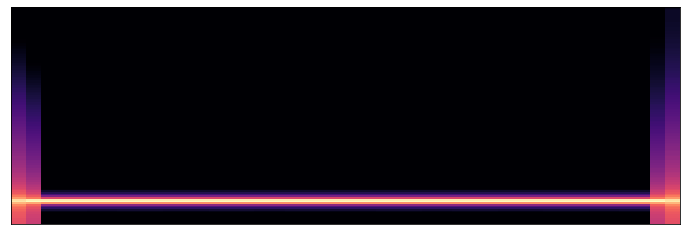

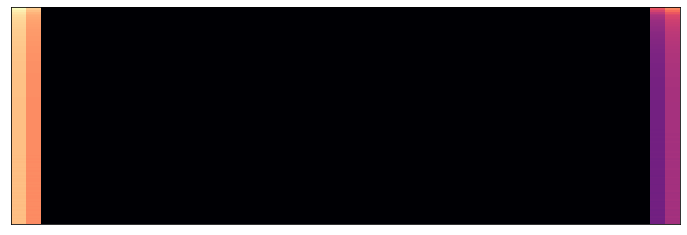

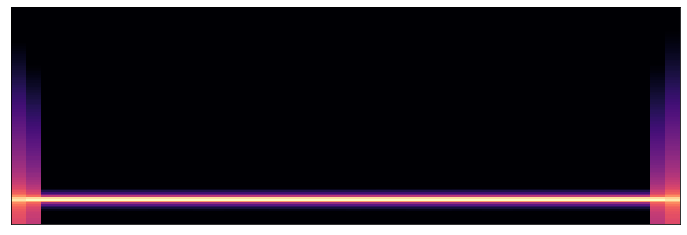

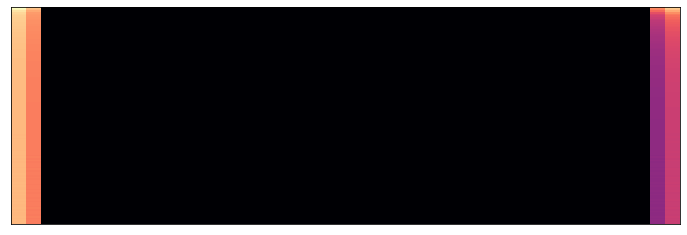

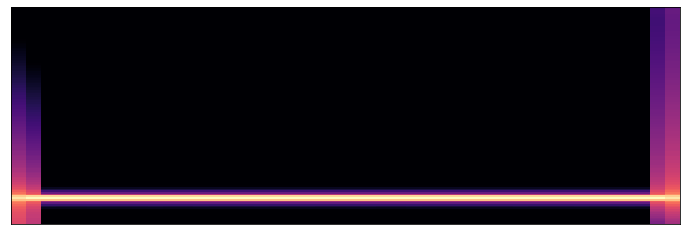

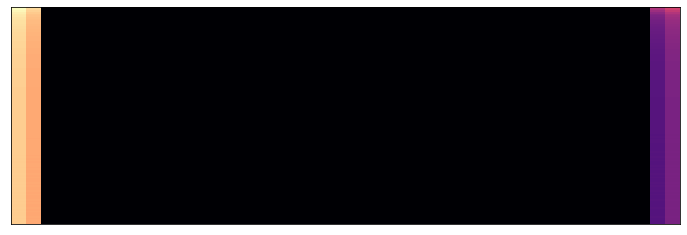

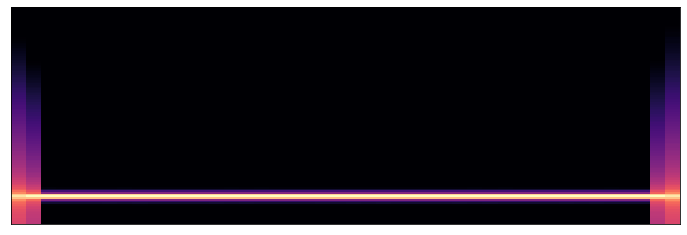

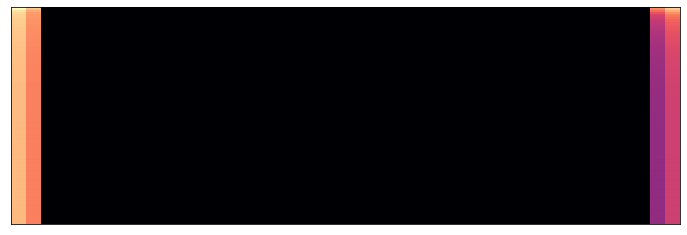

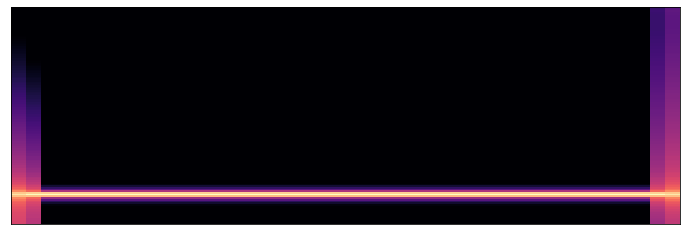

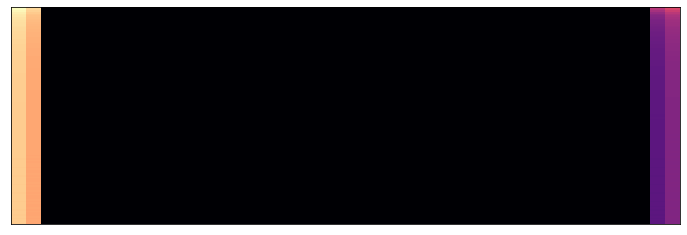

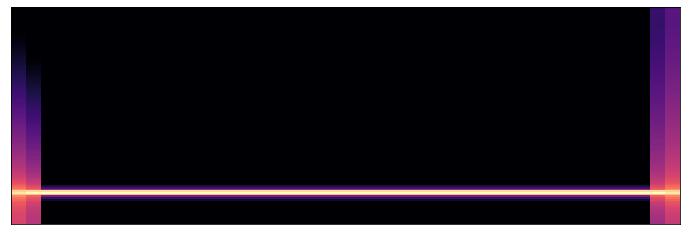

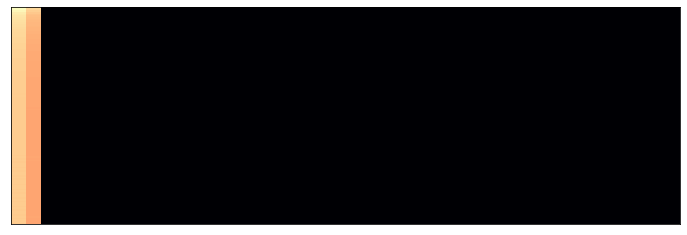

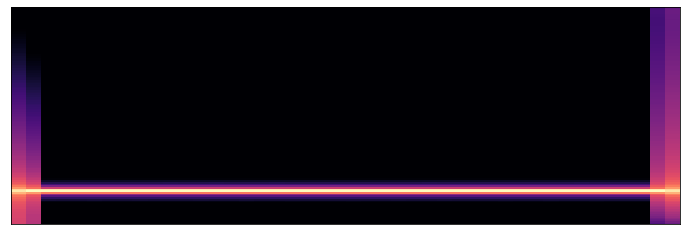

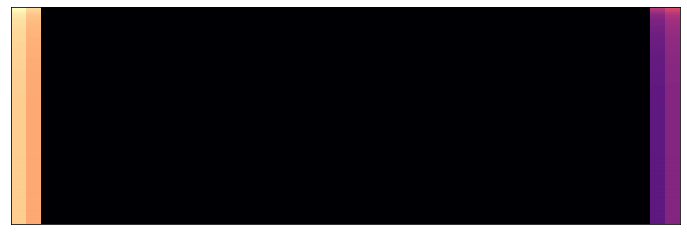

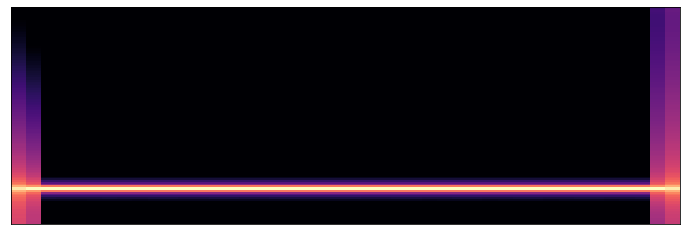

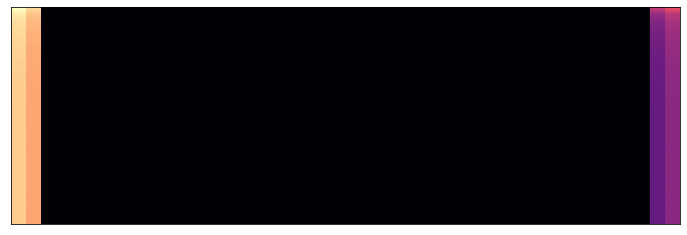

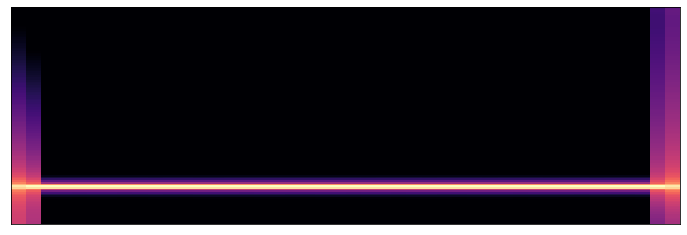

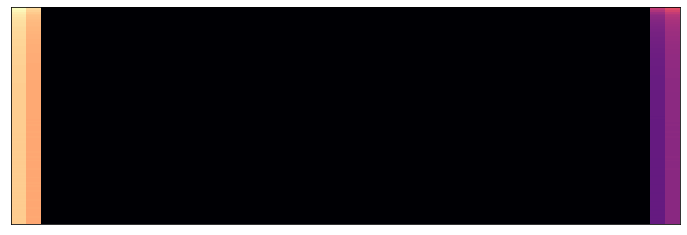

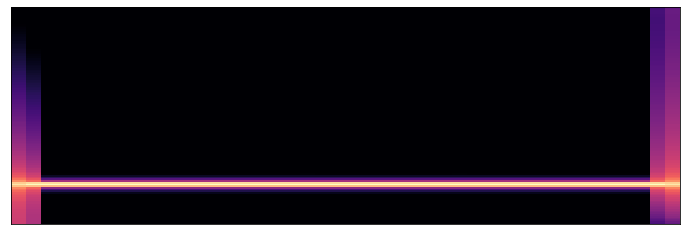

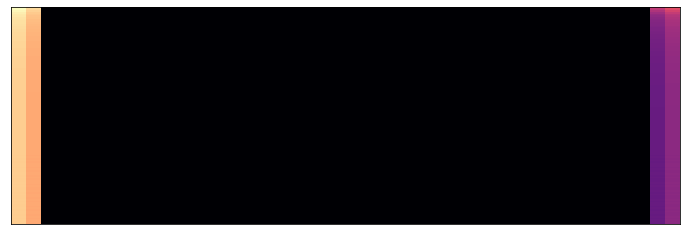

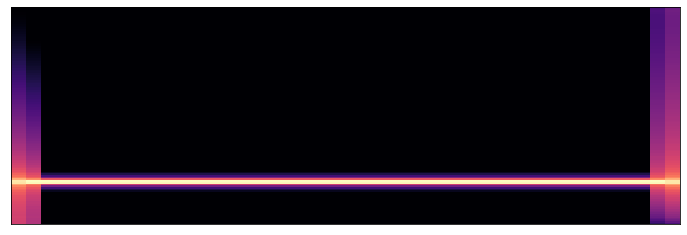

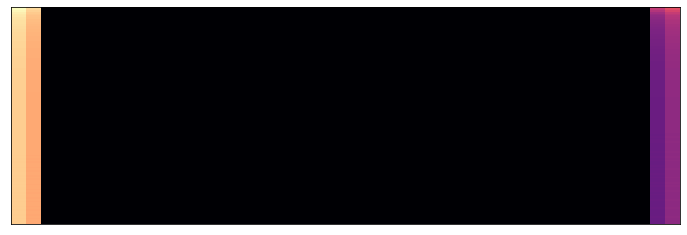

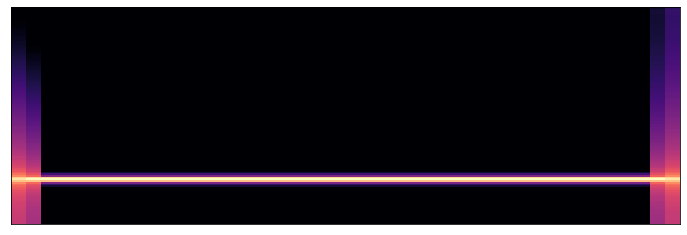

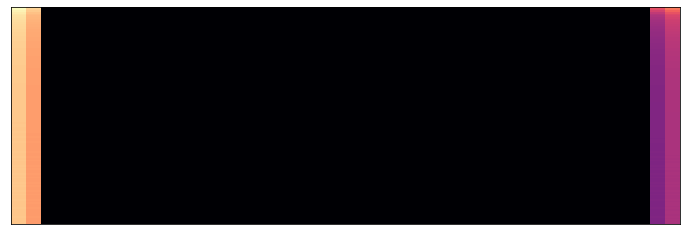

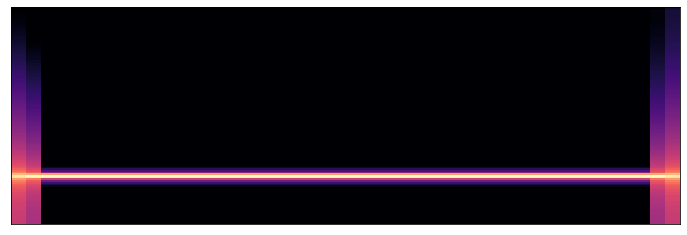

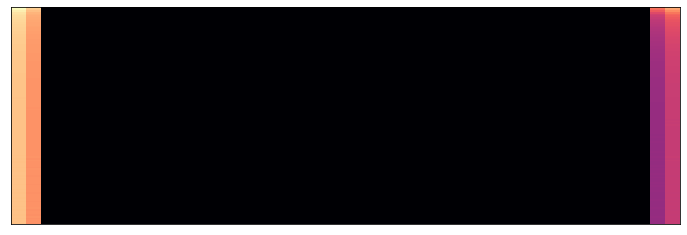

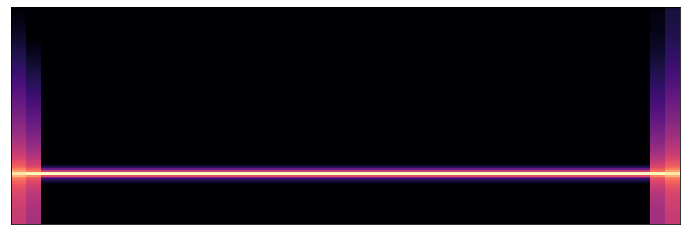

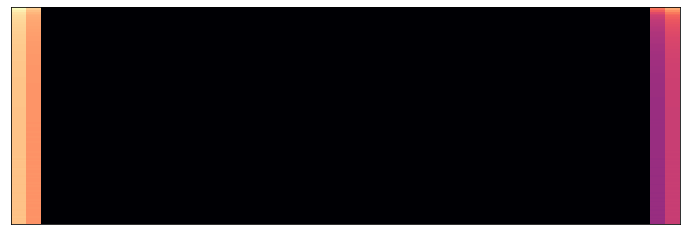

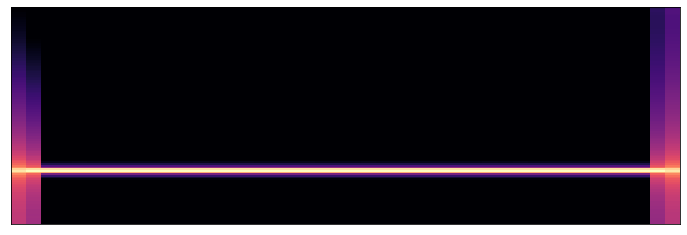

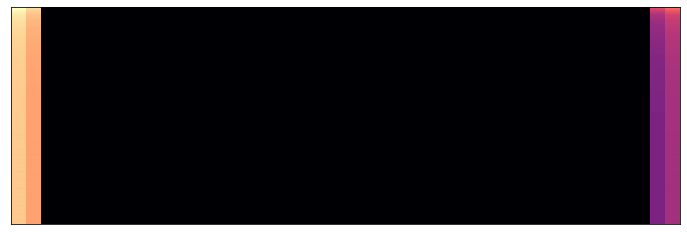

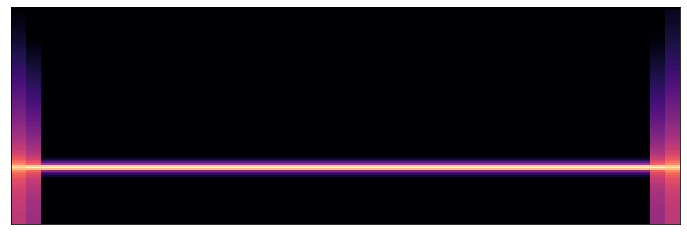

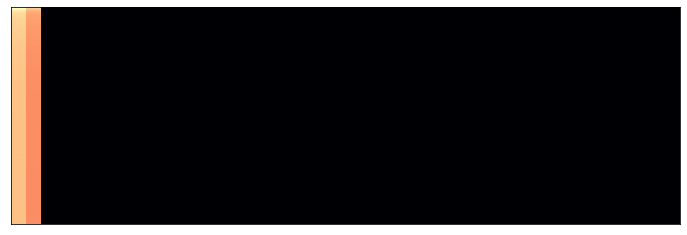

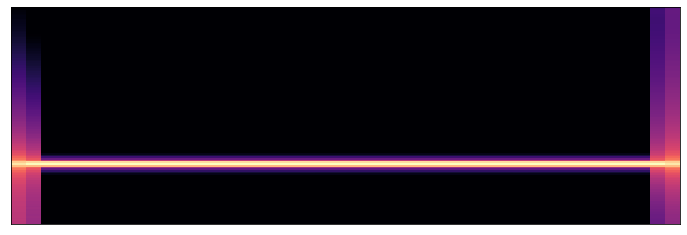

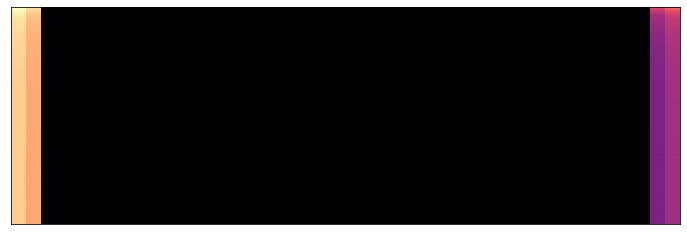

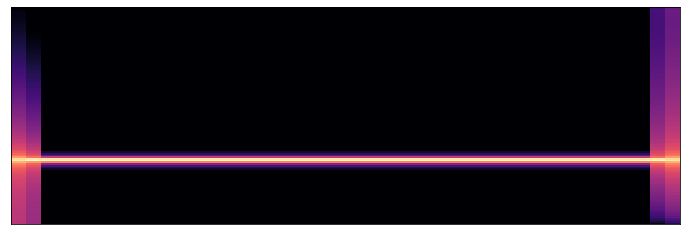

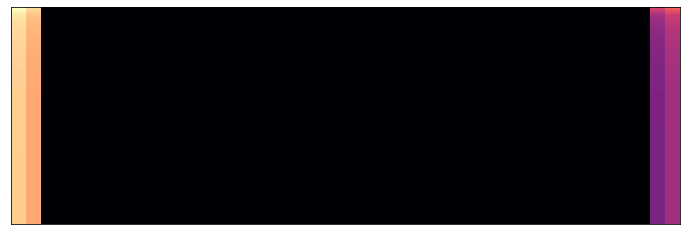

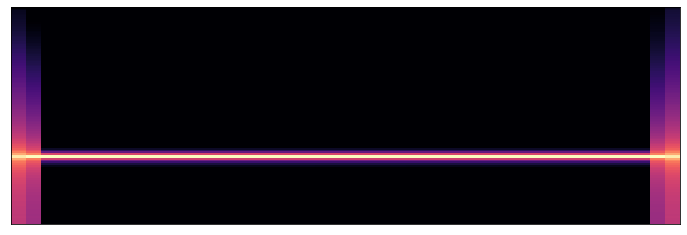

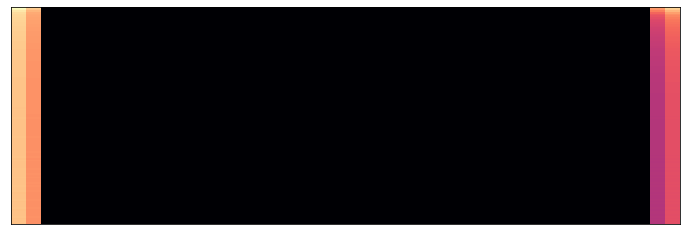

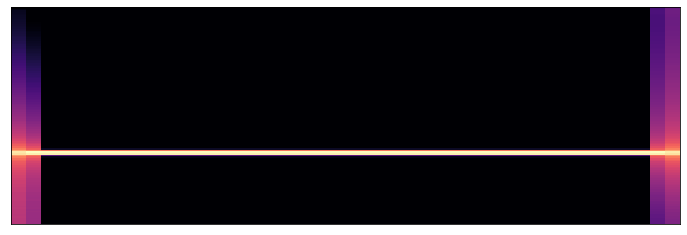

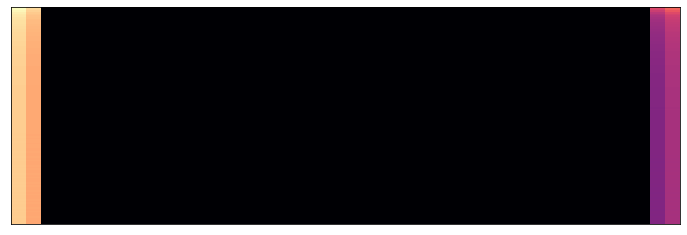

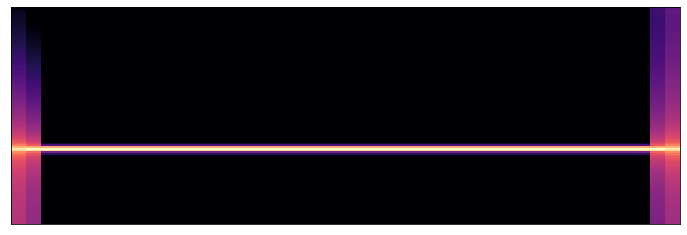

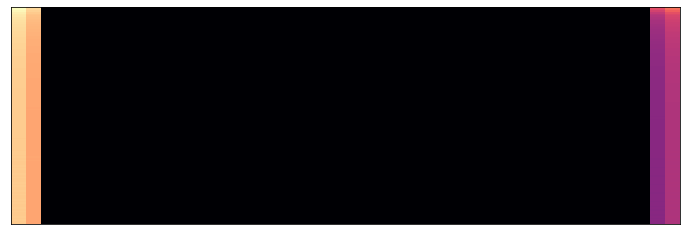

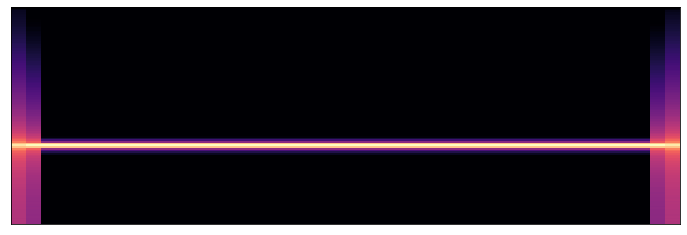

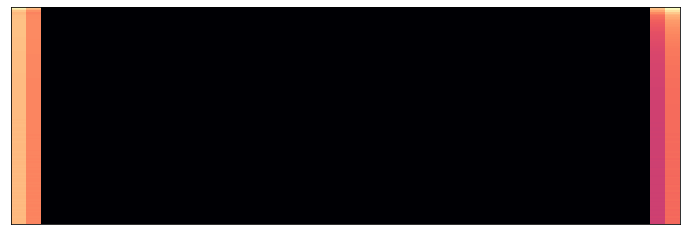

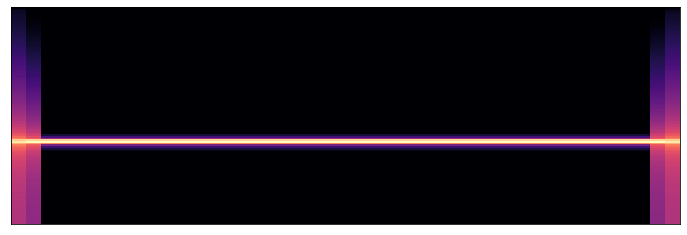

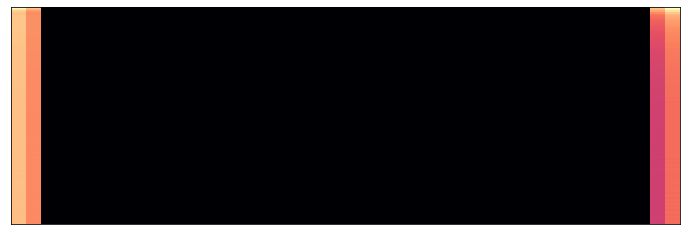

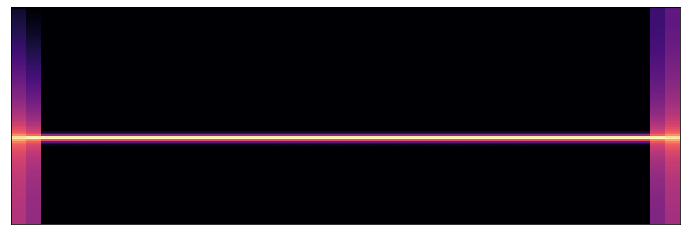

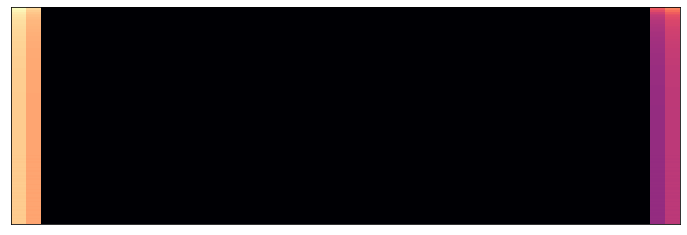

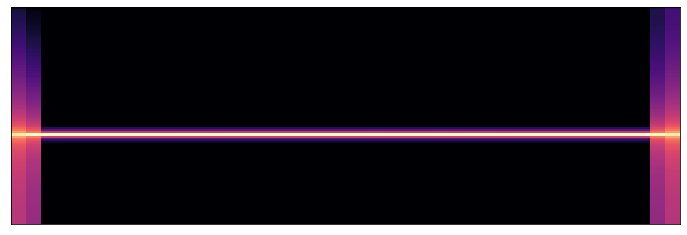

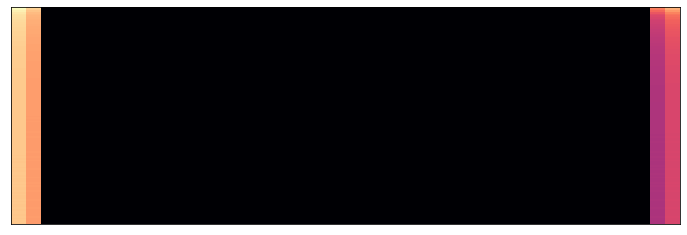

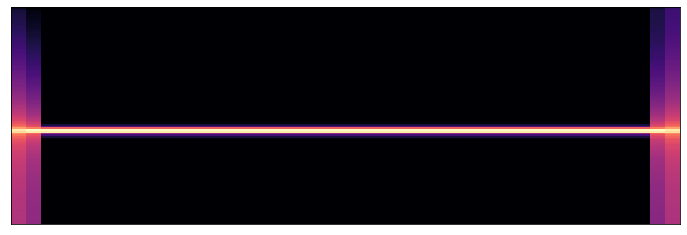

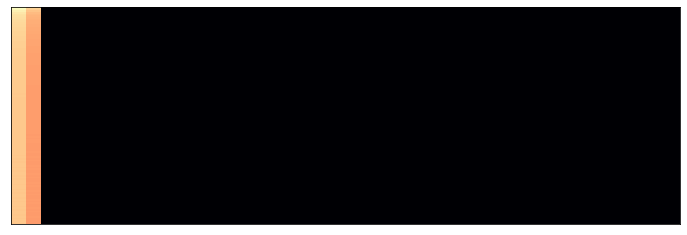

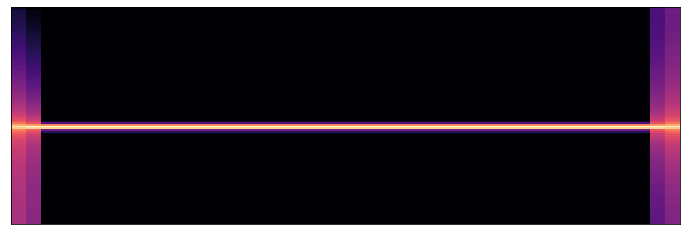

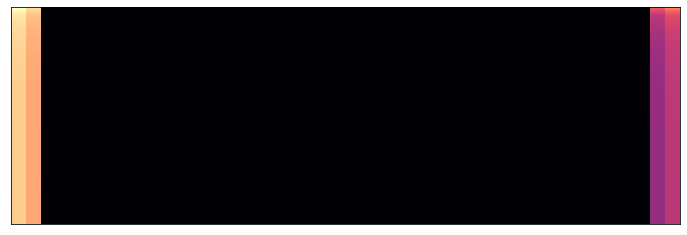

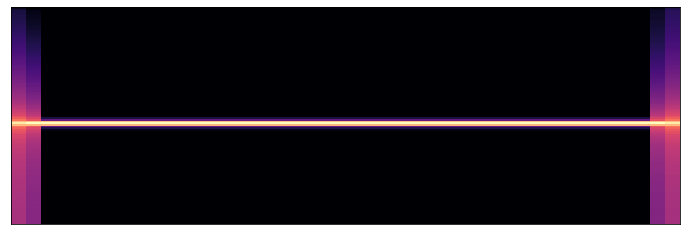

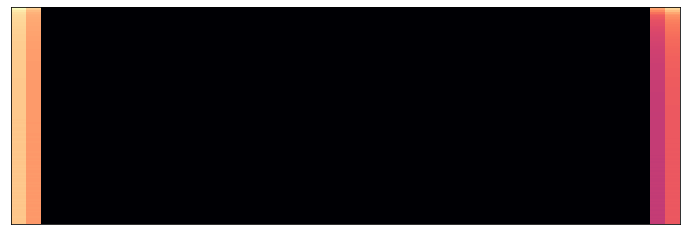

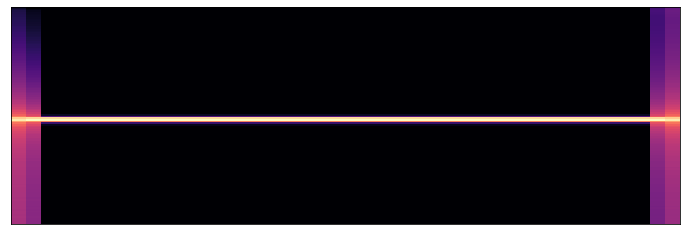

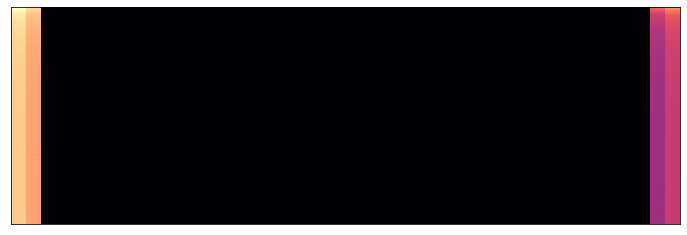

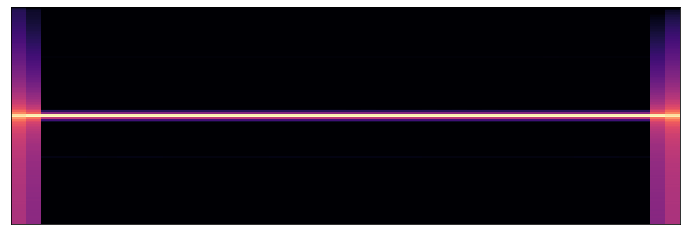

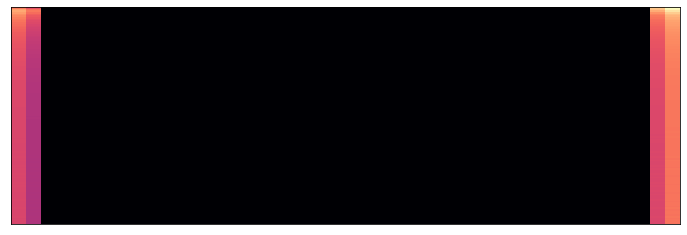

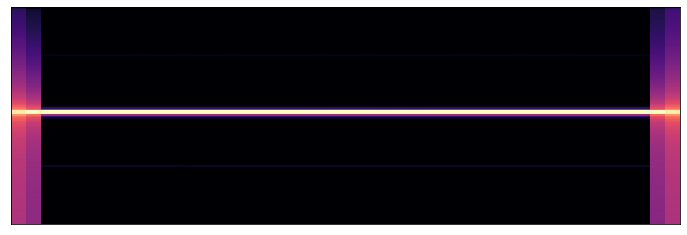

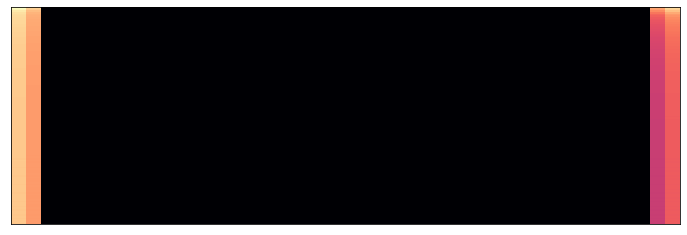

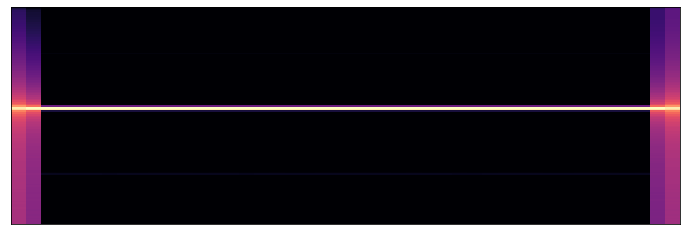

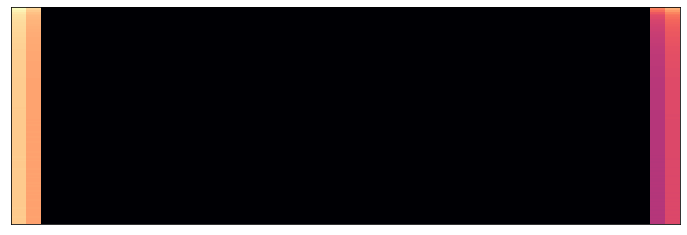

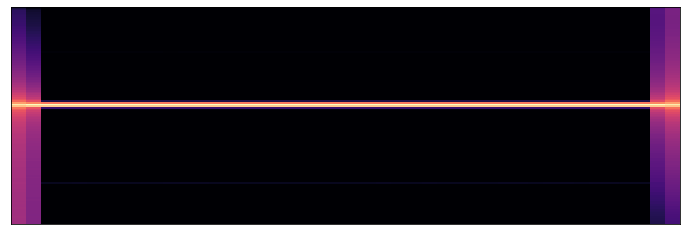

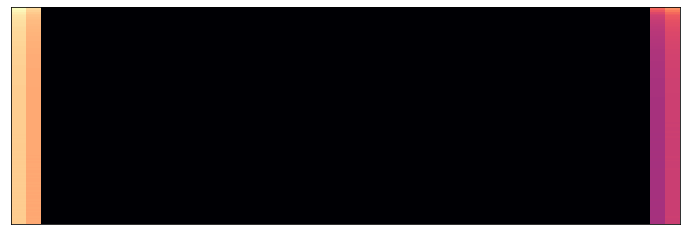

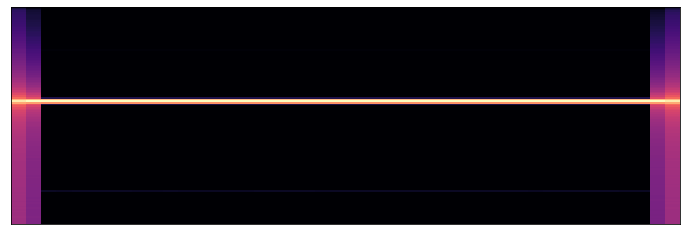

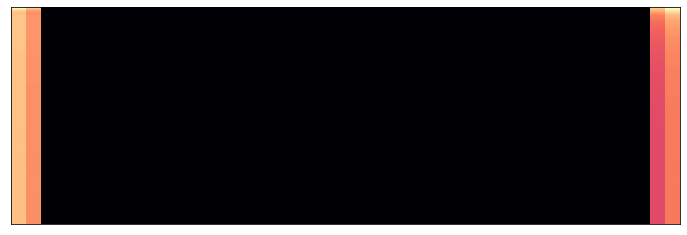

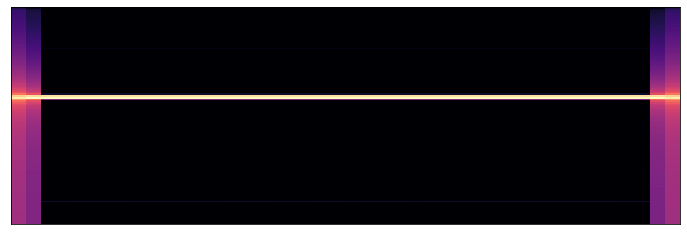

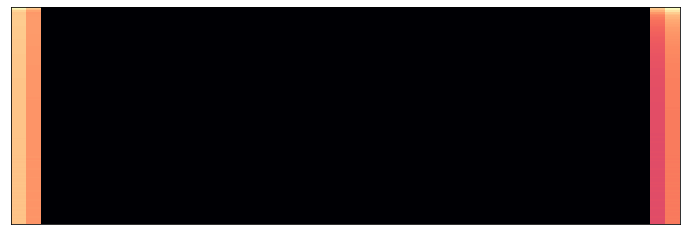

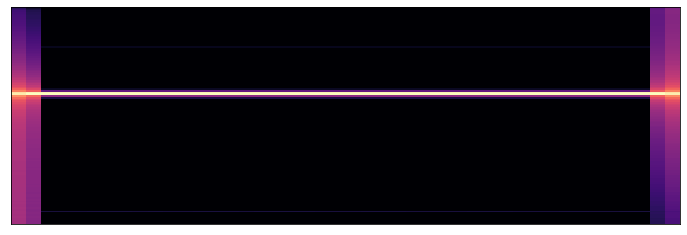

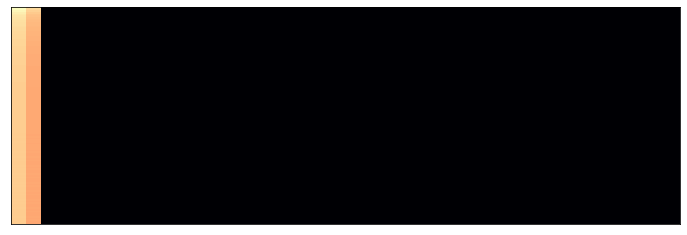

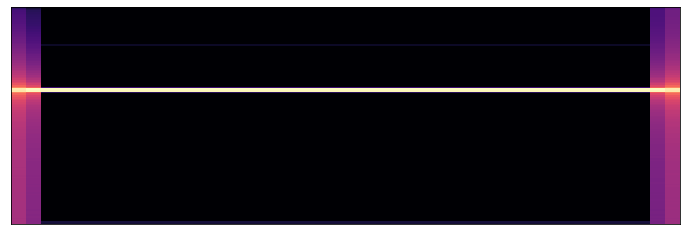

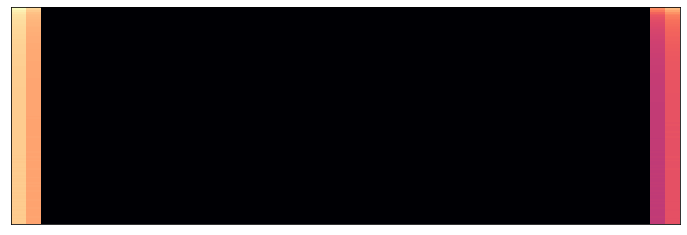

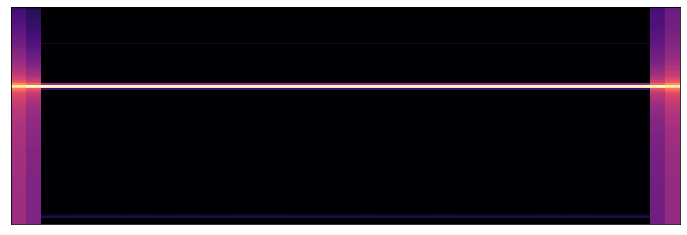

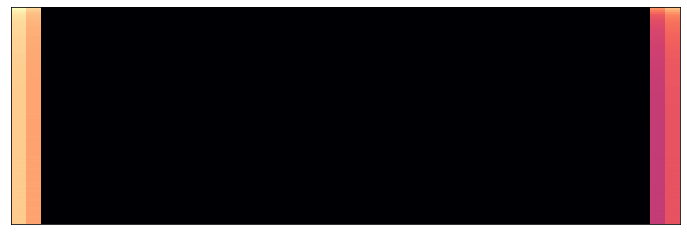

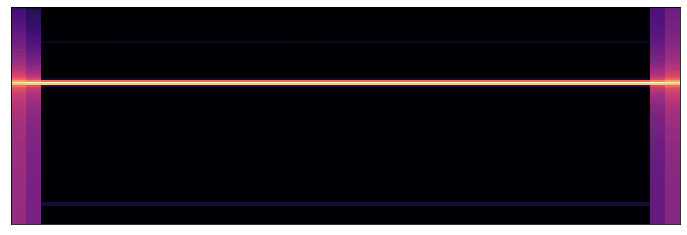

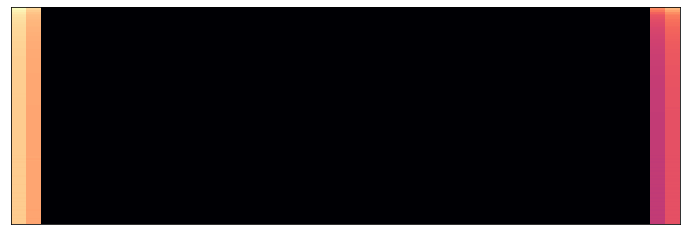

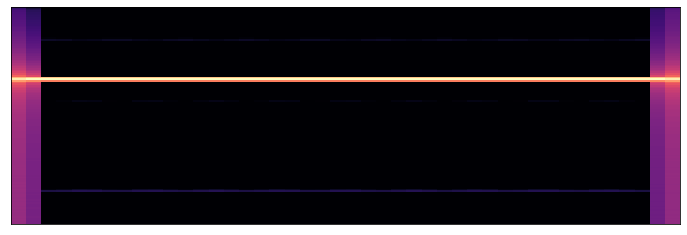

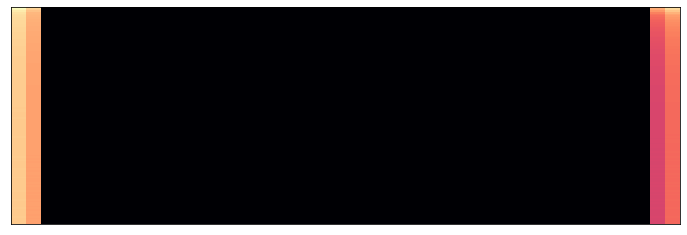

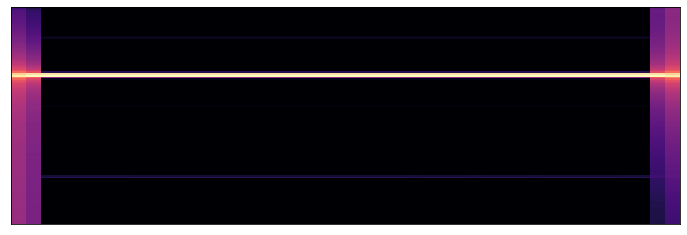

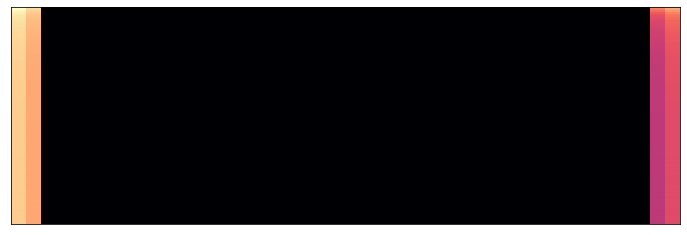

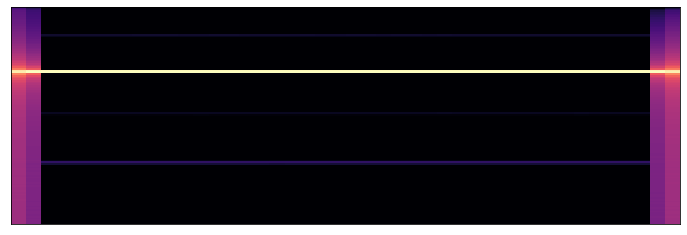

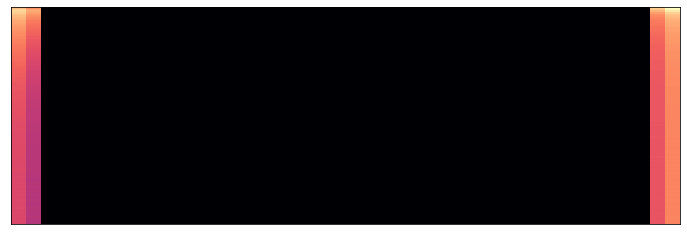

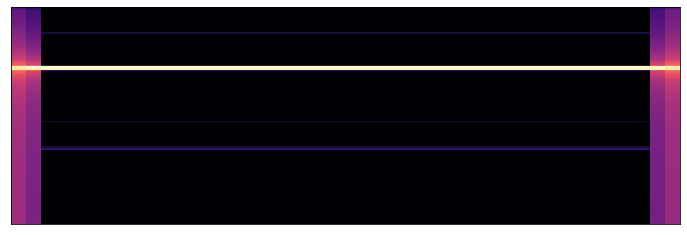

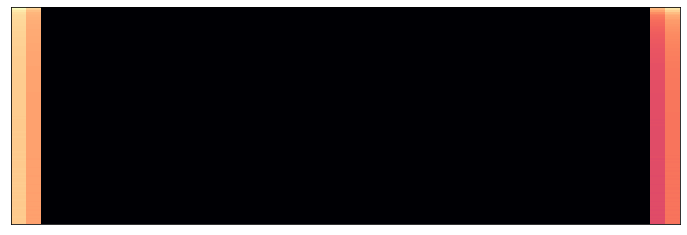

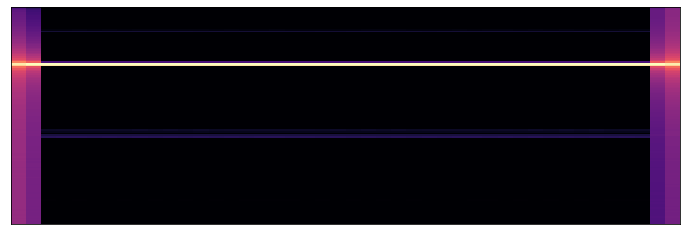

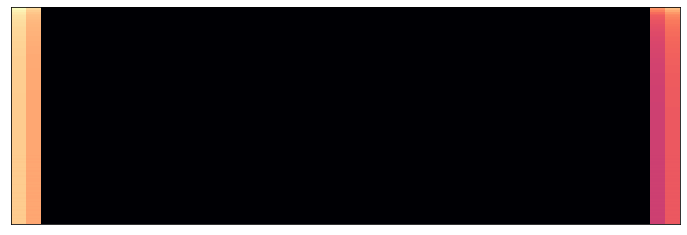

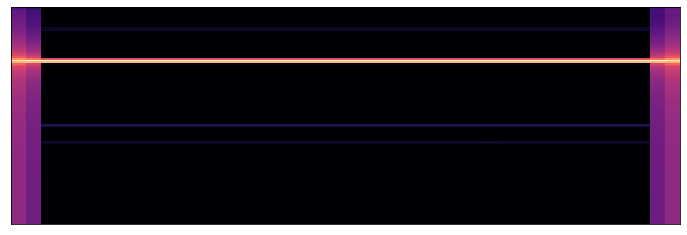

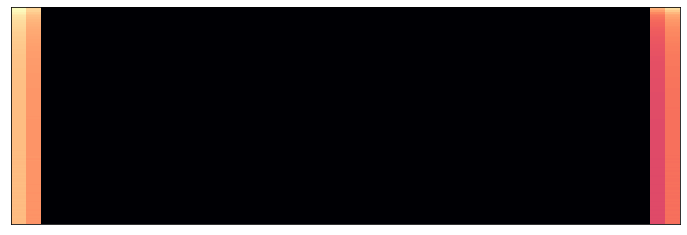

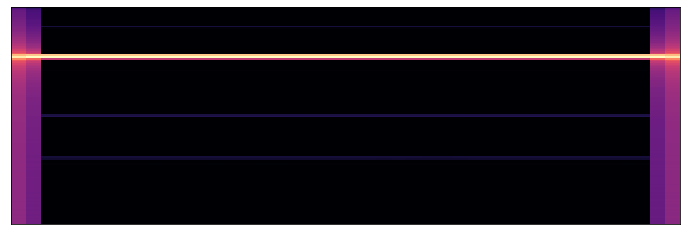

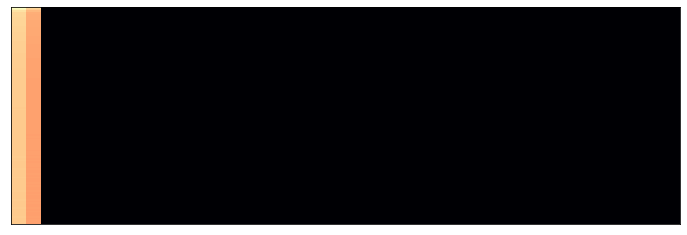

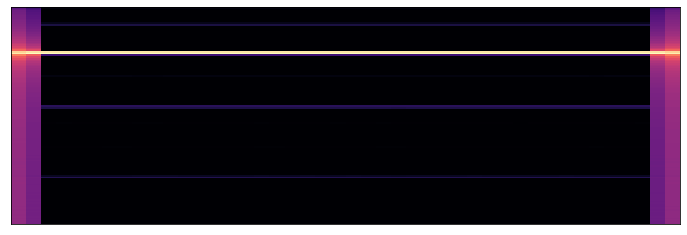

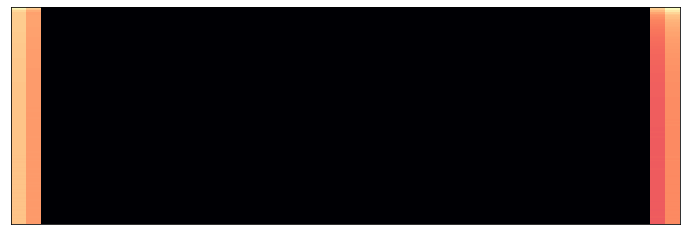

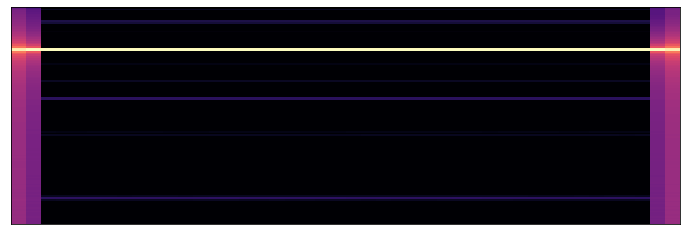

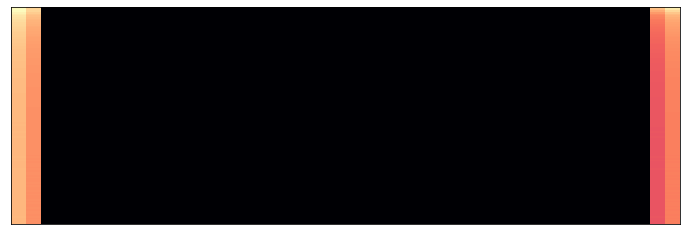

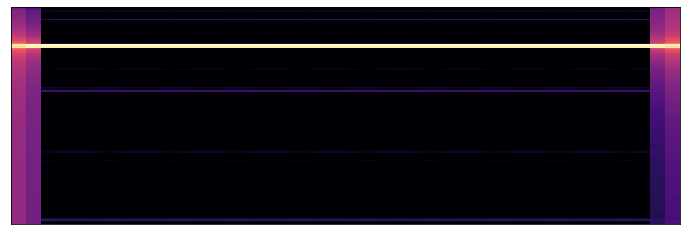

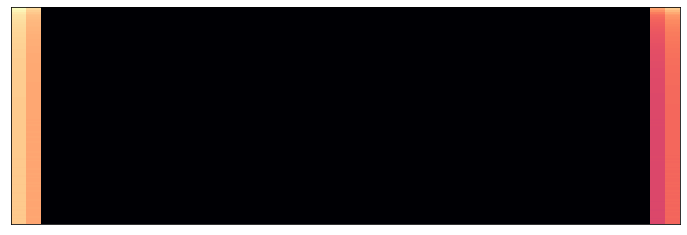

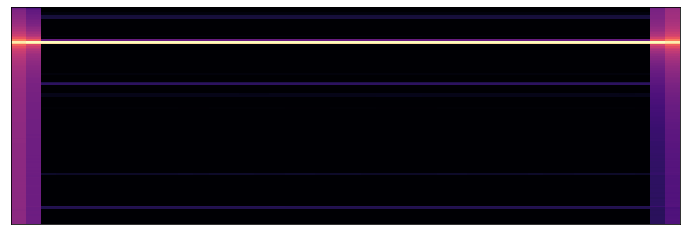

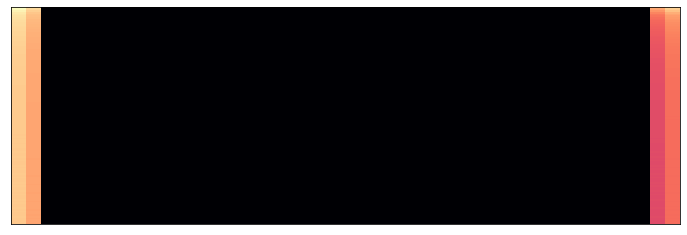

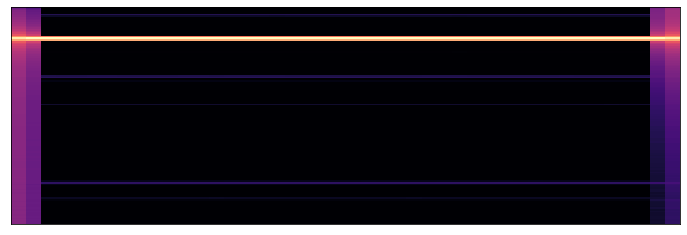

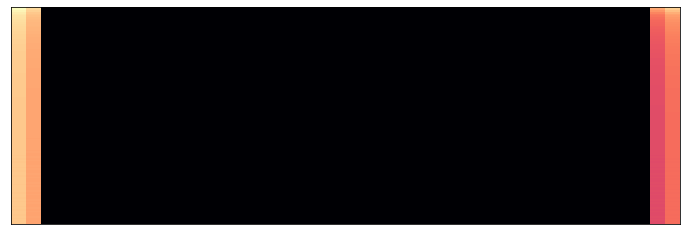

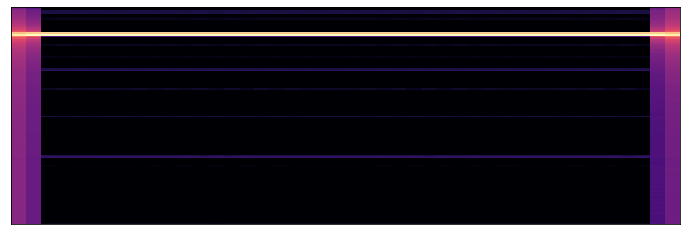

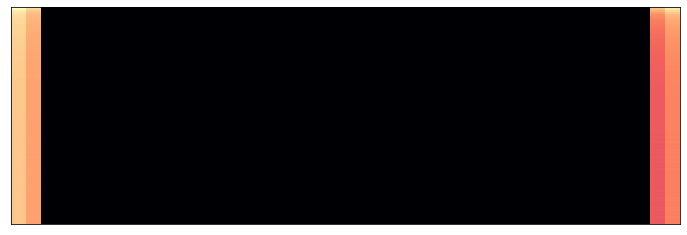

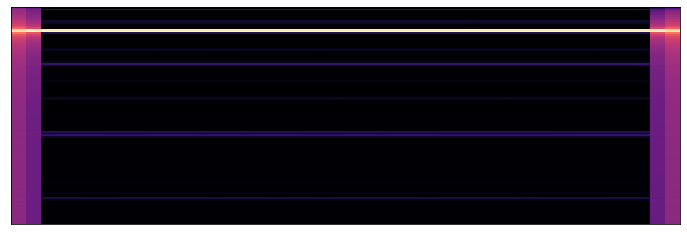

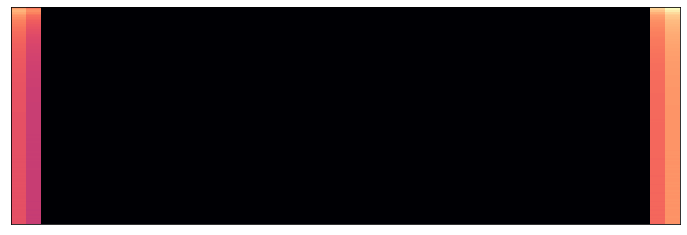

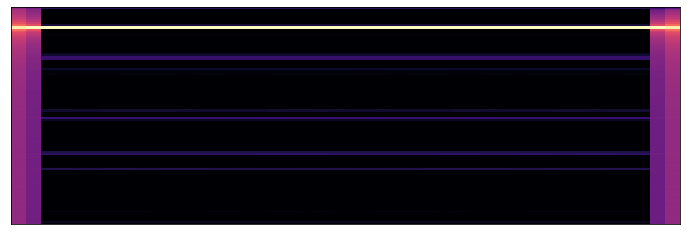

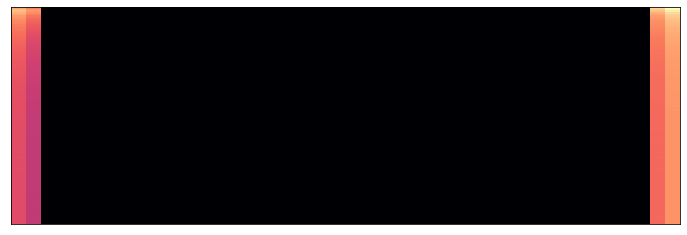

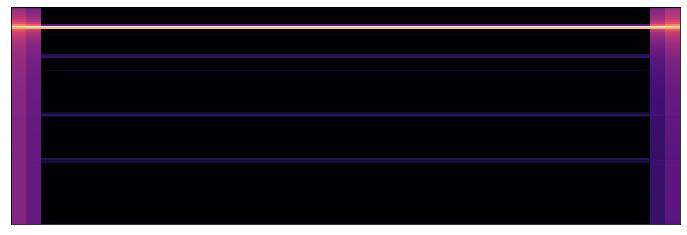

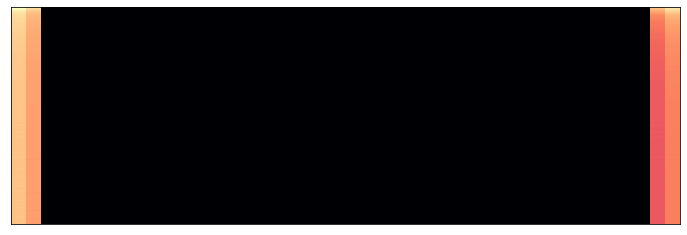

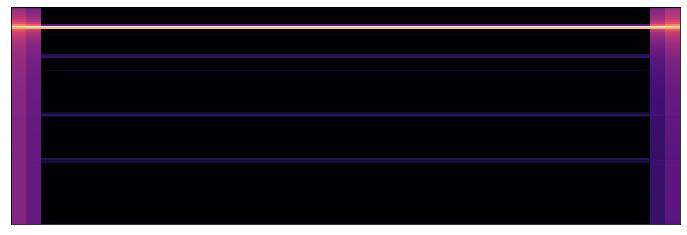

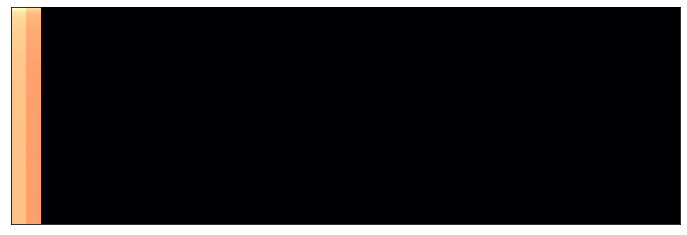

In [ ]:
for j in range(0,11):    
    create_dataset_notes(wav_nam[j],"datasetnotes" +str(j+11))

second_0_label_1.png
second_10_label_6.png
second_12_label_7.png
second_14_label_8.png
second_16_label_9.png
second_18_label_10.png
second_2_label_2.png
second_4_label_3.png
second_6_label_4.png
second_8_label_5.png
[ 1  6  7  8  9 10  2  3  4  5]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


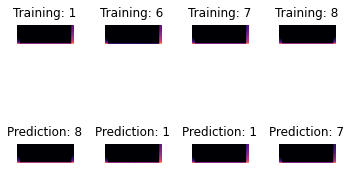

second_0_label_11.png
second_10_label_16.png
second_12_label_17.png
second_14_label_18.png
second_16_label_19.png
second_18_label_20.png
second_2_label_12.png
second_4_label_13.png
second_6_label_14.png
second_8_label_15.png
[11 16 17 18 19 20 12 13 14 15]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          11       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          14       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       1.0
          16       0.00      0.00      0.00       0.0
          20       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


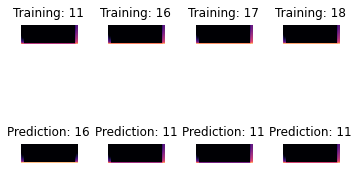

second_0_label_21.png
second_10_label_26.png
second_12_label_27.png
second_14_label_28.png
second_16_label_29.png
second_18_label_30.png
second_2_label_22.png
second_4_label_23.png
second_6_label_24.png
second_8_label_25.png
[21 26 27 28 29 30 22 23 24 25]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          21       0.00      0.00      0.00       0.0
          22       0.00      0.00      0.00       1.0
          23       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       1.0
          26       0.00      0.00      0.00       0.0
          27       0.00      0.00      0.00       0.0
          28       0.00      0.00      0.00       0.0
          30       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]]


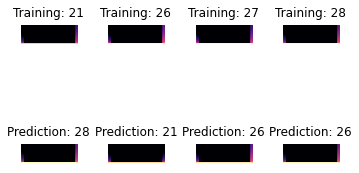

second_0_label_31.png
second_10_label_36.png
second_12_label_37.png
second_14_label_38.png
second_16_label_39.png
second_18_label_40.png
second_2_label_32.png
second_4_label_33.png
second_6_label_34.png
second_8_label_35.png
[31 36 37 38 39 40 32 33 34 35]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          31       0.00      0.00      0.00       0.0
          32       0.00      0.00      0.00       1.0
          33       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       1.0
          35       0.00      0.00      0.00       1.0
          36       0.00      0.00      0.00       0.0
          39       0.00      0.00      0.00       0.0
          40       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


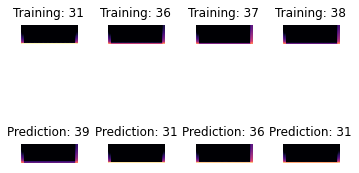

second_0_label_41.png
second_10_label_46.png
second_12_label_47.png
second_14_label_48.png
second_16_label_49.png
second_18_label_50.png
second_2_label_42.png
second_4_label_43.png
second_6_label_44.png
second_8_label_45.png
[41 46 47 48 49 50 42 43 44 45]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          41       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       1.0
          43       0.00      0.00      0.00       1.0
          44       0.00      0.00      0.00       1.0
          45       0.00      0.00      0.00       1.0
          46       0.00      0.00      0.00       0.0
          49       0.00      0.00      0.00       0.0
          50       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


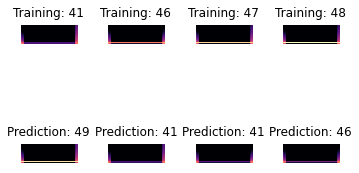

second_0_label_51.png
second_10_label_56.png
second_12_label_57.png
second_14_label_58.png
second_16_label_59.png
second_18_label_60.png
second_2_label_52.png
second_4_label_53.png
second_6_label_54.png
second_8_label_55.png
[51 56 57 58 59 60 52 53 54 55]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          51       0.00      0.00      0.00       0.0
          52       0.00      0.00      0.00       1.0
          53       0.00      0.00      0.00       1.0
          54       0.00      0.00      0.00       1.0
          55       0.00      0.00      0.00       1.0
          56       0.00      0.00      0.00       0.0
          59       0.00      0.00      0.00       0.0
          60       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


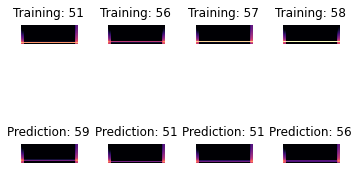

second_0_label_61.png
second_10_label_66.png
second_12_label_67.png
second_14_label_68.png
second_16_label_69.png
second_18_label_70.png
second_2_label_62.png
second_4_label_63.png
second_6_label_64.png
second_8_label_65.png
[61 66 67 68 69 70 62 63 64 65]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          61       0.00      0.00      0.00       0.0
          62       0.00      0.00      0.00       1.0
          63       0.00      0.00      0.00       1.0
          64       0.00      0.00      0.00       1.0
          65       0.00      0.00      0.00       1.0
          66       0.00      0.00      0.00       0.0
          69       0.00      0.00      0.00       0.0
          70       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


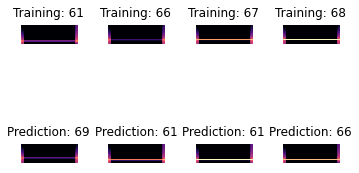

second_0_label_71.png
second_10_label_76.png
second_12_label_77.png
second_14_label_78.png
second_16_label_79.png
second_18_label_80.png
second_2_label_72.png
second_4_label_73.png
second_6_label_74.png
second_8_label_75.png
[71 76 77 78 79 80 72 73 74 75]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          71       0.00      0.00      0.00       0.0
          72       0.00      0.00      0.00       1.0
          73       0.00      0.00      0.00       1.0
          74       0.00      0.00      0.00       1.0
          75       0.00      0.00      0.00       1.0
          76       0.00      0.00      0.00       0.0
          79       0.00      0.00      0.00       0.0
          80       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


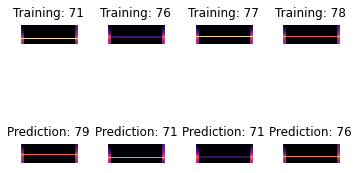

second_0_label_81.png
second_10_label_86.png
second_12_label_87.png
second_14_label_88.png
second_16_label_89.png
second_18_label_90.png
second_2_label_82.png
second_4_label_83.png
second_6_label_84.png
second_8_label_85.png
[81 86 87 88 89 90 82 83 84 85]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          81       0.00      0.00      0.00       0.0
          82       0.00      0.00      0.00       1.0
          83       0.00      0.00      0.00       1.0
          84       0.00      0.00      0.00       1.0
          85       0.00      0.00      0.00       1.0
          86       0.00      0.00      0.00       0.0
          89       0.00      0.00      0.00       0.0
          90       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


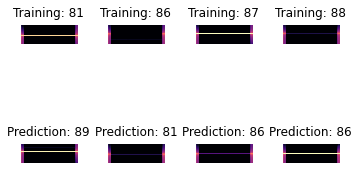

second_0_label_91.png
second_10_label_96.png
second_12_label_97.png
second_14_label_98.png
second_16_label_99.png
second_18_label_100.png
second_2_label_92.png
second_4_label_93.png
second_6_label_94.png
second_8_label_95.png
[ 91  96  97  98  99 100  92  93  94  95]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

          91       0.00      0.00      0.00       0.0
          92       0.00      0.00      0.00       1.0
          93       0.00      0.00      0.00       1.0
          94       0.00      0.00      0.00       1.0
          95       0.00      0.00      0.00       1.0
          98       0.00      0.00      0.00       0.0
         100       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


Confusion matrix:
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


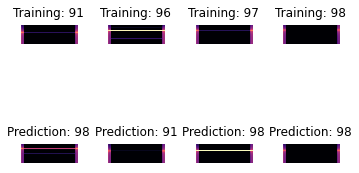

second_0_label_101.png
second_10_label_106.png
second_12_label_107.png
second_14_label_108.png
second_16_label_109.png
second_18_label_109.png
second_2_label_102.png
second_4_label_103.png
second_6_label_104.png
second_8_label_105.png
[101 106 107 108 109 109 102 103 104 105]


C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gja17002\Anaconda3\lib\site-packages\sklearn\

Classification report for classifier SVC(gamma=0.0001):
              precision    recall  f1-score   support

         102       0.00      0.00      0.00         1
         103       0.00      0.00      0.00         1
         104       0.00      0.00      0.00         1
         105       0.00      0.00      0.00         1
         106       0.00      0.00      0.00         0
         107       0.00      0.00      0.00         0
         109       1.00      1.00      1.00         1

    accuracy                           0.20         5
   macro avg       0.14      0.14      0.14         5
weighted avg       0.20      0.20      0.20         5


Confusion matrix:
[[0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]]


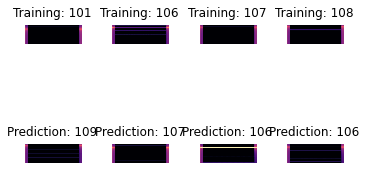

In [ ]:
for j in range(0,11):      
    data, images, labels = load_data("datasetnotes" +str(j+11))
    images_and_labels = list(zip(images, labels))
    for index, (image, label) in enumerate(images_and_labels[:4]):
        plt.subplot(2, 4, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Training: %i' % label)

    n_samples = len(images)

    # Create a classifier: a support vector classifier
    classifierSVM = svm.SVC(gamma=0.0001)

    # We learn the digits on the first half of the digits
    classifierSVM.fit(data[:n_samples // 2], labels[:n_samples // 2])
    # Now predict the value of the digit on the second half:
    expected = labels[n_samples // 2:]
    predicted = classifierSVM.predict(data[n_samples // 2:])
    pickle.dump(classifierSVM, open('classifierSVM'+str(j)+'.p','wb'))
    print("Classification report for classifier %s:\n%s\n"
          % (classifierSVM, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

    images_and_predictions = list(zip(images[n_samples // 2:], predicted))
    for index, (image, prediction) in enumerate(images_and_predictions[:4]):
        plt.subplot(2, 4, index + 5)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Prediction: %i' % prediction)

    plt.show()

In [ ]:
x = 0;
for j in range(0,11):
    pretrained_svm = pickle.load(open('classifierSVM'+str(j)+'.p', 'rb'))
    data, images, labels = load_data("datasetnotes"+str(j+11))
    pretrained_svm.predict(data)
    x += pretrained_svm.score(data, labels)
print("Total Accuracy is " + str(x/11))

second_0_label_1.png
second_10_label_6.png
second_12_label_7.png
second_14_label_8.png
second_16_label_9.png
second_18_label_10.png
second_2_label_2.png
second_4_label_3.png
second_6_label_4.png
second_8_label_5.png
[ 1  6  7  8  9 10  2  3  4  5]
second_0_label_11.png
second_10_label_16.png
second_12_label_17.png
second_14_label_18.png
second_16_label_19.png
second_18_label_20.png
second_2_label_12.png
second_4_label_13.png
second_6_label_14.png
second_8_label_15.png
[11 16 17 18 19 20 12 13 14 15]
second_0_label_21.png
second_10_label_26.png
second_12_label_27.png
second_14_label_28.png
second_16_label_29.png
second_18_label_30.png
second_2_label_22.png
second_4_label_23.png
second_6_label_24.png
second_8_label_25.png
[21 26 27 28 29 30 22 23 24 25]
second_0_label_31.png
second_10_label_36.png
second_12_label_37.png
second_14_label_38.png
second_16_label_39.png
second_18_label_40.png
second_2_label_32.png
second_4_label_33.png
second_6_label_34.png
second_8_label_35.png
[31 36 37 38 